<h1><center>Разработка моделей для оптимизации управления персоналом</center></h1>

# Описание исследования

HR-аналитики компании помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников.  


# Цель проекта

В данном проекте предстоит построить 2 модели, которые наилучшим образом помогут решить 2 задачи на основе данных заказчика:
1. Предсказать уровень удовлетворённости сотрудника.
2. Предсказать то, что сотрудник уволится из компании.

# Задачи исследования

Разработать 2 модели машинного обучения:
1. Для предсказания уровеня удовлетворённости сотрудника на основе данных заказчика;
2. Для предсказания того, что сотрудник уволится из компании.

Для этого нужно:

1. Загрузить и подготовить данные.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами.
4. Проверить данные на тестовой выборке и сделать выводы.


Критерием выбора лучшей модели для первой задачи является значение метрики качества **SMAPE** ≤ 15 на тестовой выборке.

<h2>Задача №1: Предсказание уровня удовлетворенности сотрудника</h2>

### Описание данных


Заказчик передал 3 csv-файла с данными:
- train_job_satisfaction_rate.csv - данные для тренировочной выборки
- test_features.csv - данные со входными признаками тестовой выборки
- test_target_job_satisfaction_rate.csv - данные с целевым признаком тестовой выборки

Название и описание столбцов:

- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, **целевой признак.**

### Загрузка данных

In [ ]:
!pip install phik -q

In [ ]:
!pip install --upgrade scikit-learn -q

In [ ]:
# импорт библиотек
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats as st


# загружаем необходимые инструменты
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from phik.report import plot_correlation_matrix
from phik import phik_matrix
from sklearn.feature_selection import SelectKBest, f_classif

# загружаем классы для преобразования данных
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    PolynomialFeatures
)

# загружаем инструмент для автоподбора гиперпараметров
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем нужные метрики
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, make_scorer, r2_score

# загружаем нужные модели
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.dummy import DummyClassifier

In [ ]:
# улучшение чёткости изображения
%config InlineBackend.figure_format = 'retina'

# настройка шрифтов заголовков и подписей для графиков
large = 16; med = 14; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large,
          'figure.titleweight': 'bold'}
plt.rcParams.update(params)
plt.style.use('seaborn-bright')

Для начала последовательно считаем исходные csv-файлы и сохраним их в отдельных переменных. Затем сделаем предварительный просмотр данных методом sample(10) и с помощью метода info() узнаем основные характеристики исходных датасетов.

In [ ]:
# сохранение данных тренировочной выборки
# в переменной df_train
df_train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
# просмотр 10 случайных строк датафрейма
df_train.sample(10)

id        dept   level workload  employment_years last_year_promo  \
2897  711872          hr  junior   medium                 1              no   
1460  194840   marketing  junior   medium                 1              no   
1939  287850       sales  junior   medium                 1              no   
1553  446469       sales  middle     high                 2              no   
1525  154102  technology  middle   medium                 6              no   
1683  688867  purchasing  junior   medium                 3              no   
2219  975893  purchasing  junior      low                 3              no   
2287  994677  purchasing  middle      low                 6              no   
3488  618813       sales  middle   medium                 3              no   
3033  369077          hr  middle     high                 7              no   

     last_year_violations  supervisor_evaluation  salary  \
2897                   no                      5   22800   
1460                   no                      4   27600   
1939                   no                      4   24000   
1553                  yes                      3   55200   
1525                   no                      4   51600   
1683                   no                      4   22800   
2219                   no                      4   13200   
2287                   no                      4   28800   
3488                   no                      3   31200   
3033                  yes                      1   57600   

      job_satisfaction_rate  
2897                   0.55  
1460                   0.69  
1939                   0.68  
1553                   0.24  
1525                   0.86  
1683                   0.67  
2219                   0.60  
2287                   0.78  
3488                   0.12  
3033                   0.25

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


<u>Выводы по первоначальному обзору данных в датафрейме **df_train**</u>

- Названия столбцов менять не надо.
- Проверить неявные дубликаты в строковых столбцах.
- В таблице 4000 строчек и 10 столбцов.
- 6 пропусков в столбце 'dept' и 4  в столбце 'level'.
- Типы данных преобразовывать не надо.

In [ ]:
# сохранение данных со входными признаками тестовой выборки
# в переменной df_X_test
df_X_test = pd.read_csv('/datasets/test_features.csv')
df_X_test.sample(10)

id        dept   level workload  employment_years last_year_promo  \
1255  965090          hr  junior   medium                 2              no   
1527  303017       sales  junior   medium                 1              no   
805   489547  technology  middle     high                 2              no   
378   472068       sales  junior   medium                 2              no   
1995  393147   marketing  junior      low                 3              no   
1129  597443  purchasing  junior   medium                 2              no   
720   372444   marketing  junior   medium                 3              no   
349   827527   marketing  junior   medium                 1              no   
975   605519  technology  sinior     high                 3              no   
239   632435  purchasing  middle      low                 1              no   

     last_year_violations  supervisor_evaluation  salary  
1255                   no                      3   28800  
1527                   no                      3   21600  
805                    no                      4   62400  
378                    no                      5   27600  
1995                   no                      3   20400  
1129                   no                      4   26400  
720                    no                      4   27600  
349                    no                      4   31200  
975                    no                      3   84000  
239                    no                      4   28800

In [ ]:
df_X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


<u>Выводы по первоначальному обзору данных в датафрейме **df_X_test**</u>

- Названия столбцов менять не надо.
- Проверить неявные дубликаты в строковых столбцах.
- В таблице 2000 строчек и 9 столбцов.
- 2 пропуска в столбце 'dept' и 1  в столбце 'level'.
- Типы данных преобразовывать не надо.

In [ ]:
# сохранение данных с целевым признаком тестовой выборки
# в переменной df_y_test
df_y_test = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
df_y_test.sample(10)

id  job_satisfaction_rate
818   595214                   0.15
1172  980459                   0.28
1176  130978                   0.61
1882  408935                   0.63
1454  275269                   0.67
191   343666                   0.53
1434  324986                   0.37
413   424987                   0.44
1551  438445                   0.40
1488  207434                   0.20

In [ ]:
df_y_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


<u>Выводы по первоначальному обзору данных в датафрейме **df_y_test**</u>

- Названия столбцов менять не надо.
- В таблице 2000 строчек и 2 столбца.
- Пропусков нет.
- Типы данных преобразовывать не надо.

Перед началом анализа и моделирования объединим данные в X_test и y_test в один датафрейм, чтобы данные для разных сотрудников не сбились. Объединим с помощью метода merge() по столбцу "id".

In [ ]:
# объединение X_test и y_test
df_test = df_X_test.merge(df_y_test, on='id')

Исследуем столбец с id сотрудников в тренировочной и тестовой выборке: узнаем сколько всего сотрудников в исходных данных и не пересекаются ли сотрудники в тренировочной и тестовой выборке.

In [ ]:
# цикл для подсчета уникальных значений id для каждого датафрейма
for data, title in zip((df_train, df_test), ("df_train", "df_test")):
    print(f'Количество уникальных id в датафрейме {title}: {data["id"].nunique()} \n')

Количество уникальных id в датафрейме df_train: 4000 

Количество уникальных id в датафрейме df_test: 2000 



In [ ]:
print('id, которые есть в датафрейме train, но нет в df_test', df_train['id'][~df_train['id'].isin(df_test['id'])])

id, которые есть в датафрейме train, но нет в df_test 0       155278
1       653870
2       184592
3       171431
4       693419
         ...  
3995    457950
3996    957499
3997    533318
3998    706868
3999    338347
Name: id, Length: 4000, dtype: int64


**В компании всего 6000 сотрудников. 4000 из них попали в тренировочную выборку, 2000 - в тестовую. Пересечений в выборках нет.**

In [ ]:
# установка столбца 'id' в качестве индекса для датафреймов train, X_test
df_train = df_train.set_index('id')
df_test = df_test.set_index('id')

###  Предобработка данных

Этап предобработки данных необходим для подготовки данных для их более корректого анализа.
Он включает в себя следующие пункты, которые проводятся при необходимости:
- переименование названий столбцов;
- обработка пропусков;
- преобразование типов данных;
- обработка дубликатов.

На первом этапе было выявлено, что название столбцов и типы данных преобразовывать не надо.
Пропуски есть в датафреймах df_X_train и df_X_test. Они будут обработаны в пайплайне.
Проверим наличие неявных и явных дубликатов.

#### Обработка дубликатов

Проверим наличие дубликатов в столбцах с категориальными признаками с помощью метода unique(), который выдает список всех уникальных значений в столбце.

In [ ]:
# список столбцов, в которых необходимо проверить дубликаты
object_columns = df_train.select_dtypes(include=['object']).columns
object_columns

Index(['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations'], dtype='object')

In [ ]:
# цикл для вывода на экран уникальных значений каждого столбца
for c in object_columns:
    for data, title in zip((df_train, df_test), ("df_train", "df_test")):
        print(f'Датафрейм {title}, cтолбец {c}: {data[c].unique()} \n')

Датафрейм df_train, cтолбец dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan] 

Датафрейм df_test, cтолбец dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' '] 

Датафрейм df_train, cтолбец level: ['junior' 'middle' 'sinior' nan] 

Датафрейм df_test, cтолбец level: ['junior' 'middle' 'sinior' nan] 

Датафрейм df_train, cтолбец workload: ['medium' 'high' 'low'] 

Датафрейм df_test, cтолбец workload: ['medium' 'low' 'high' ' '] 

Датафрейм df_train, cтолбец last_year_promo: ['no' 'yes'] 

Датафрейм df_test, cтолбец last_year_promo: ['no' 'yes'] 

Датафрейм df_train, cтолбец last_year_violations: ['no' 'yes'] 

Датафрейм df_test, cтолбец last_year_violations: ['no' 'yes'] 



Неявных дубликатов нет. Есть пробелы (' ') в столбцах dept и workload в тестовой выборке. Необходимо это учесть в пайплайне.

Проверим есть ли явные дубликаты в датафреймах.

In [ ]:
# цикл для проверка явных дубликатов
for data, title in zip((df_train, df_test), ("df_train", "df_test")):
    print('Количество явных строк-дубликатов в датафрейме', title, data.duplicated().sum())

Количество явных строк-дубликатов в датафрейме df_train 245
Количество явных строк-дубликатов в датафрейме df_test 83


В обоих датафреймах обнаружились дубликаты: в df_train - 245, в df_test - 83. Удалим их с помощью метода drop_duplicates().

In [ ]:
# удаление дубликатов в датафреймах df_train и df_test
for data in (df_train, df_test):
    data.drop_duplicates(inplace=True)

In [ ]:
# проверка удаления явных дубликатов
for data, title in zip((df_train, df_test), ("df_train", "df_test")):
    print('Количество явных строк-дубликатов в датафрейме', title, data.duplicated().sum())

Количество явных строк-дубликатов в датафрейме df_train 0
Количество явных строк-дубликатов в датафрейме df_test 0


**Вывод по этапу предобработки данных:**

- Пропуски есть в обоих датафреймах df_train и df_test. Они будут обработаны в пайплане.
- Типы данных распознаны при загрузке верно и их не надо преобразовывать.
- Названия столбцов менять не надо.
- Явные дубликаты обнаружены в обоих датафреймах. Они были удалены.
- Неявных дубликатов нет.
- Есть пробелы в 2 столбцах тестовой выборки.

### Исследовательский анализ данных

На данном этапе изучим свойства каждого признака из исходного датасета. Количественным и категориальным признакам соответствуют различные графики и диаграммы.
Для количественных признаков будет рассчитана описательная статистика методом describe(), а также для количественных непрерывных признаков будут построены гистограммы распределения значений и диаграммы размаха. А для количественных дискретных признаков - горизонтальные столбчатые диаграммы.
Для категориальных признаков будет построена круговая диаграмма.

#### Просмотр описательной статистики

In [ ]:
# получение описательной статистики для датафрейма train
df_train.describe().T

count          mean           std       min       25%  \
employment_years       3755.0      3.817044      2.557142      1.00      2.00   
supervisor_evaluation  3755.0      3.463648      1.026265      1.00      3.00   
salary                 3755.0  34457.416778  15050.643870  12000.00  22800.00   
job_satisfaction_rate  3755.0      0.532554      0.226393      0.03      0.35   

                            50%       75%      max  
employment_years           3.00      6.00     10.0  
supervisor_evaluation      4.00      4.00      5.0  
salary                 31200.00  44400.00  98400.0  
job_satisfaction_rate      0.55      0.71      1.0

Обзор описательной статистики датафрейма train показал, что явно аномальных значений нет ни по одному из признаков. Все значения лежат в допустимом, соответствующем реальным значениям, диапазоне.

In [ ]:
# получение описательной статистики для датафрейма X_test
df_test.describe().T

count          mean           std       min       25%  \
employment_years       1917.0      3.741262      2.542095      1.00      2.00   
supervisor_evaluation  1917.0      3.513824      1.006991      1.00      3.00   
salary                 1917.0  34491.392801  15504.514596  12000.00  22800.00   
job_satisfaction_rate  1917.0      0.547992      0.221328      0.03      0.37   

                            50%       75%      max  
employment_years           3.00      6.00     10.0  
supervisor_evaluation      4.00      4.00      5.0  
salary                 30000.00  43200.00  96000.0  
job_satisfaction_rate      0.58      0.72      1.0

В тестовой выборке также нет аномальных значений. Входные признаки в тренировочной и тестовой выборках имеют сходные диапазоны значений, средние и разбросы значений также близки.

#### Построение и анализ гистограмм и диаграмм количественных признаков

Непрерывными признаками являются данные столбцов:
- salary - зарплата сотрудника,
- job_satisfaction_rate - уровень удовлетворенности работой.

Для более детального изучения непрерывных данных построим гистограмму распределения и боксплот отдельно для каждого количественного параметра. Для этого используем функцию, которая будет выдавать описательную статистику и строить гистограмму распределения и боксплот.

Дискретными признаками являются данные столбцов:
- employment_years - количество проработанных лет в компании,
- supervisor_evaluation - оценка качества работы руководителем,

Для дискретных данных будет построена горизонтальная столбчатая диаграмма.

In [ ]:
def build_hist_cont_feature(feature, feature_name, b):
    # входные данные:
    # feature - название столбца с количественным признаком,
    # feature_name - название признака
    # b - количество бинов для гистограммы,

    print(f'Статистика для тренировочной выборки\n\n {df_train[feature].describe()}')
    print(f'Статистика для тестовой выборки\n\n {df_test[feature].describe()}')

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
    plt.suptitle(feature_name+' в тренировочной и тестовой выборке')

    axes[0].hist(df_train[feature], histtype='step', bins = b, linewidth=5, alpha=0.7, label='Тренировочная', density=True)
    axes[0].hist(df_test[feature], histtype='step', bins = b, linewidth=5, alpha=0.7, label='Тестовая', density=True)
    axes[0].set_title('Распределение признака в тренировочной и тестовой выборке')
    axes[0].set_ylabel('Плотность')
    axes[0].legend()

    axes[1].boxplot(df_train[feature], positions=[1], widths=0.6, vert=False)
    axes[1].boxplot(df_test[feature], positions=[2], widths=0.6, vert=False)
    axes[1].set_title('Разброс значений признака')
    axes[1].set_yticklabels(['Тренировочная', 'Тестовая'])
    axes[1].set_xlabel(feature_name)
    plt.show()

Статистика для тренировочной выборки

 count     3755.000000
mean     34457.416778
std      15050.643870
min      12000.000000
25%      22800.000000
50%      31200.000000
75%      44400.000000
max      98400.000000
Name: salary, dtype: float64
Статистика для тестовой выборки

 count     1917.000000
mean     34491.392801
std      15504.514596
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64


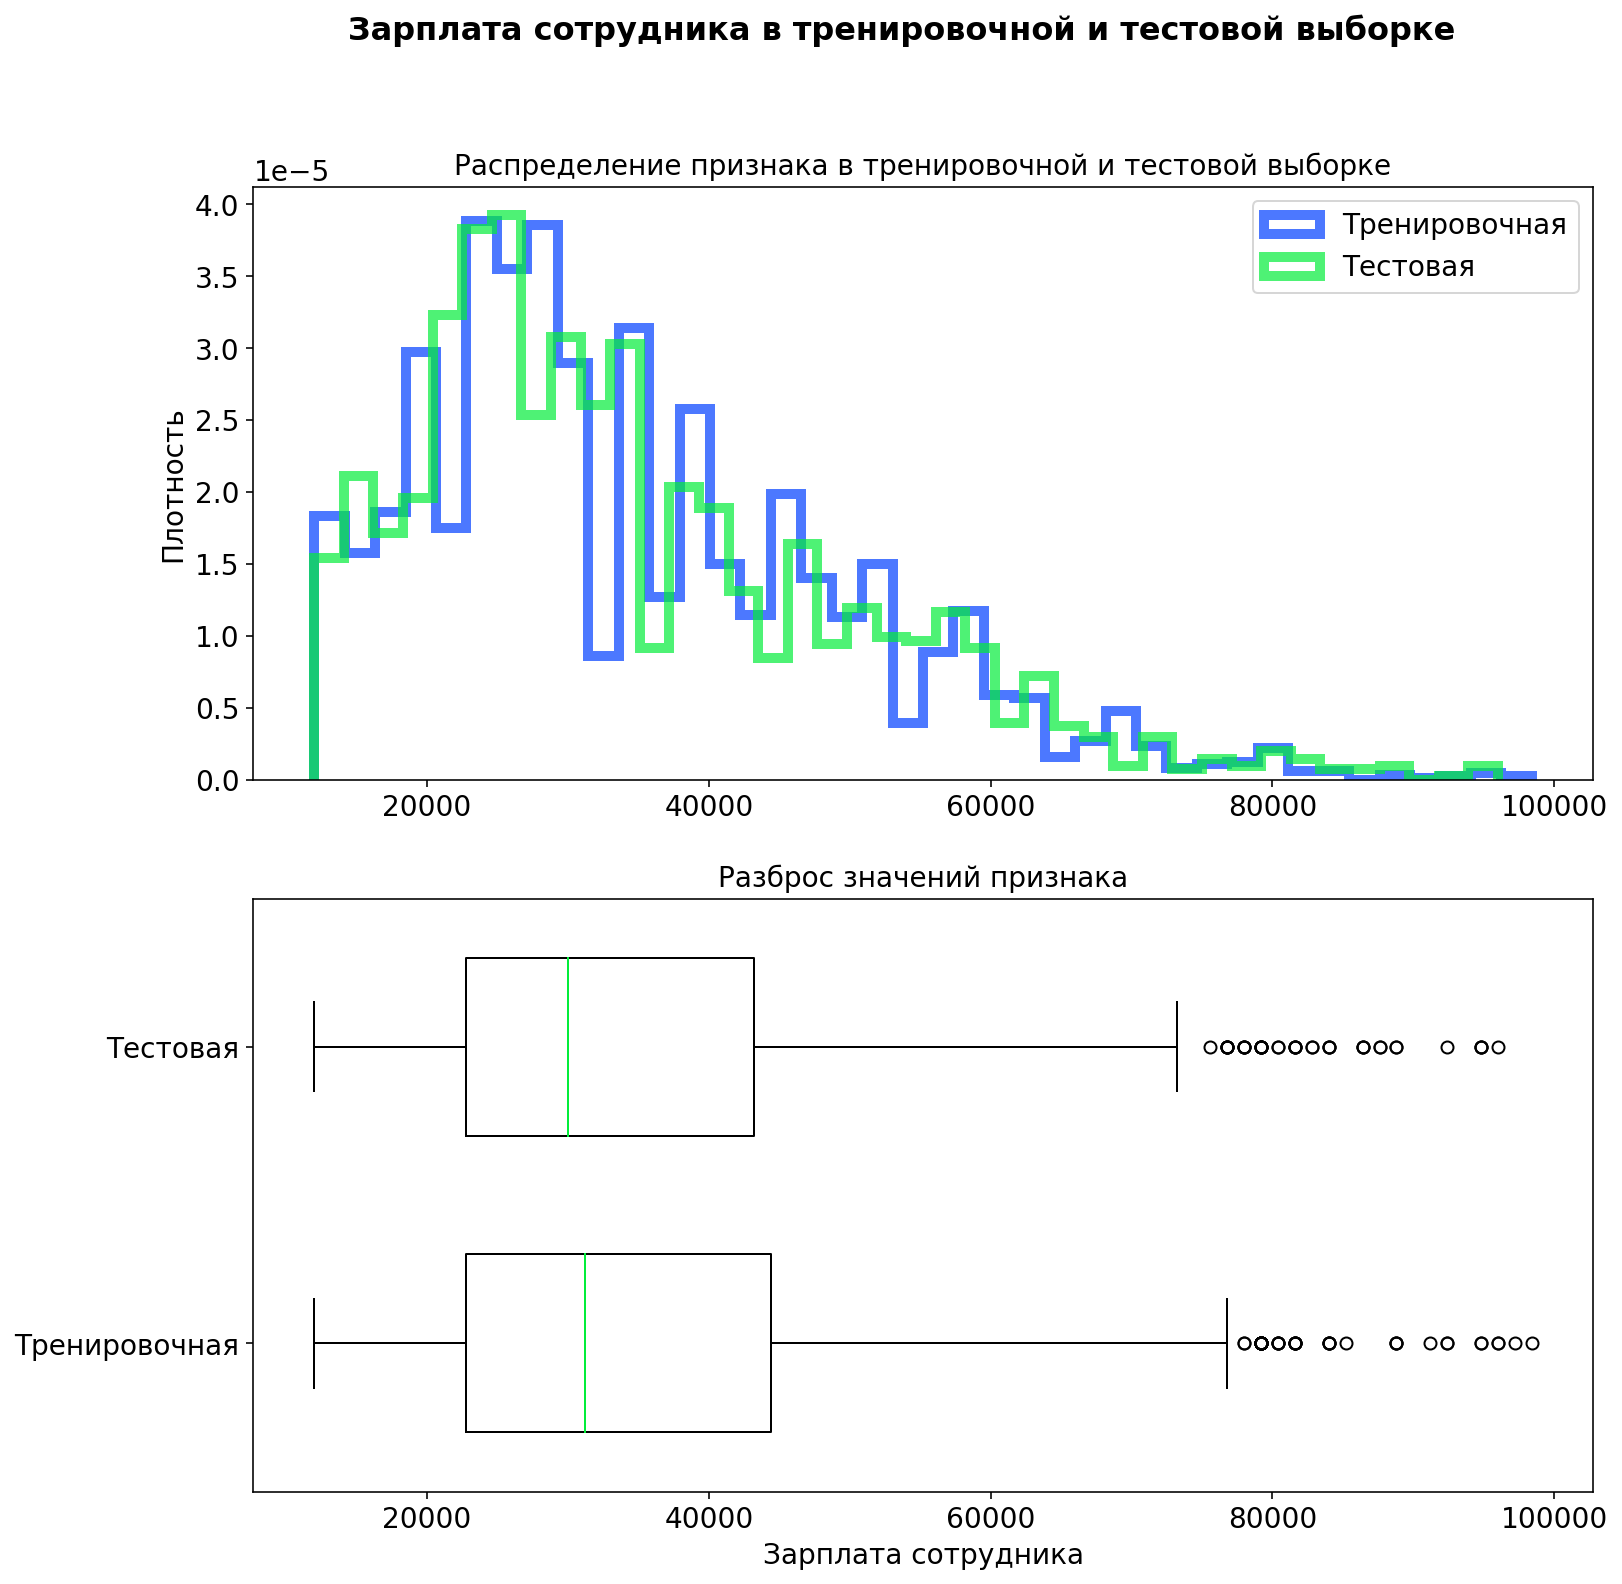

In [ ]:
# вызов функции для вывода описательной статистики и построения гистограммы и боксплота
build_hist_cont_feature('salary', 'Зарплата сотрудника', 40)

In [ ]:
# расчет значений верхнего "уса" на диаграмме размаха
q3, q1 = np.percentile (df_train['salary'], [75 ,25])
iqr = q3 - q1
upper = q3 + 1.5 * iqr

print(f'Верхняя граница {upper}')

Верхняя граница 76800.0


Распределения данных в тренировочной и тестовой выборке имеет одинакововую форму. Они различаются только частотностью. Значит данные разбиты верно с сохранением исходного распределения.

Пик смещен влево. Имеется длинный правый "хвост". Это значит, что большая часть сотрудников (75%) получают зарплаты до 43200р.
А также в обеих выборках присутствует 0.35% топ-менеджеров с зарплатами выше 73800р. На диаграмме размаха данные по топ-менеджерам выходят за пределы нормального размаха (верхнего "уса").

Статистика для тренировочной выборки

 count    3755.000000
mean        0.532554
std         0.226393
min         0.030000
25%         0.350000
50%         0.550000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64
Статистика для тестовой выборки

 count    1917.000000
mean        0.547992
std         0.221328
min         0.030000
25%         0.370000
50%         0.580000
75%         0.720000
max         1.000000
Name: job_satisfaction_rate, dtype: float64


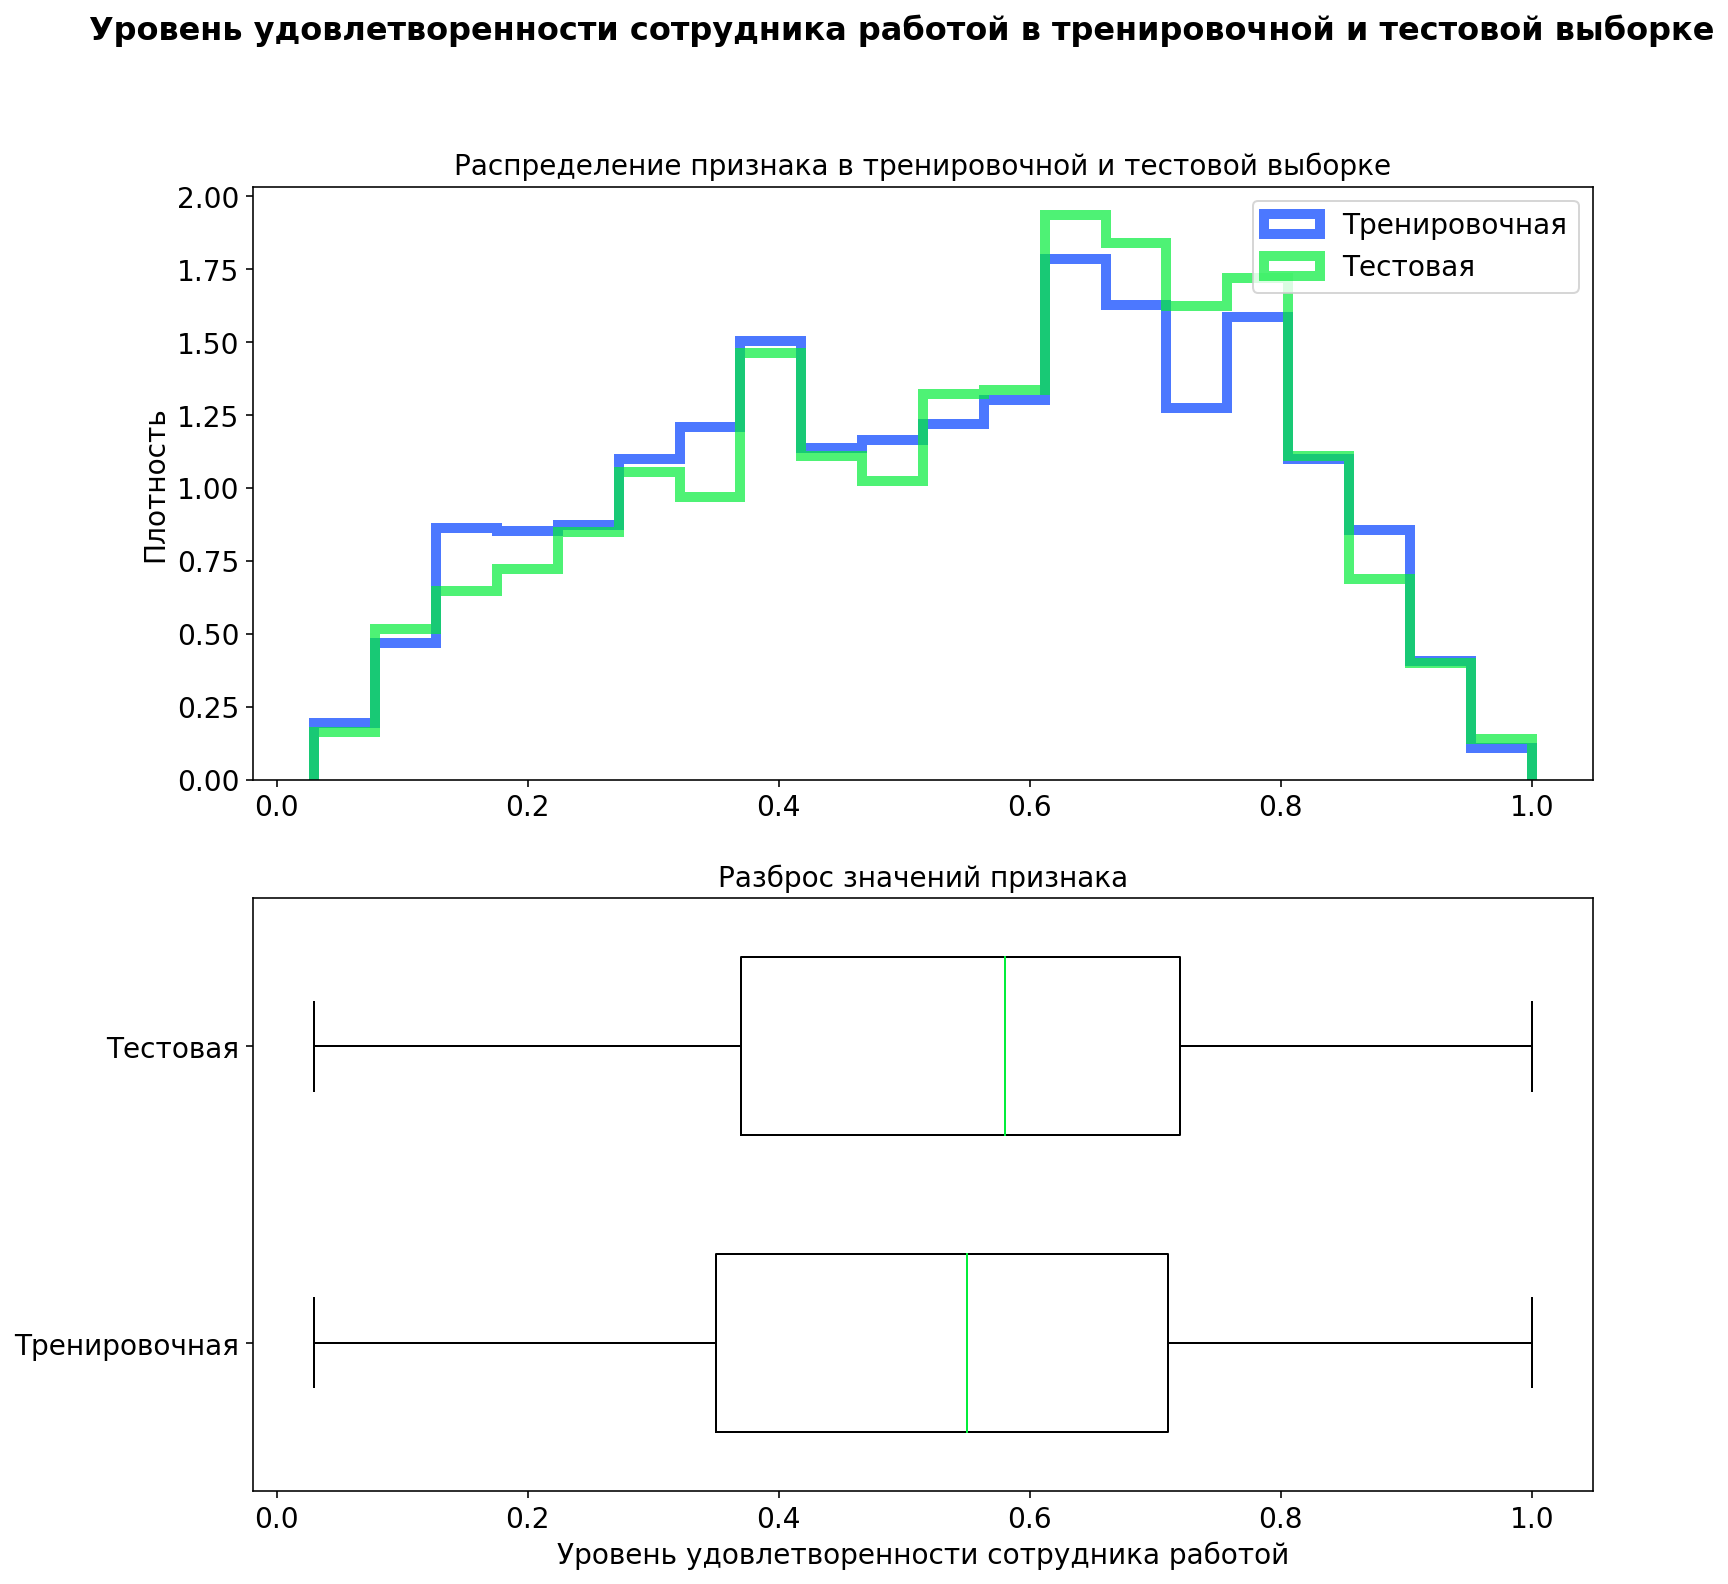

In [ ]:
build_hist_cont_feature('job_satisfaction_rate', 'Уровень удовлетворенности сотрудника работой', 20)

50% всех сотрудников оценивают свою удовлетворенность работой от 0.36 до 0.71. Распределение близкое к нормальному. Пик немного смещен вправо. Медиана на тренировочной выборке равна 0.56, на тестовой - 0.58. Значит, что довольных сотрудников с оценкой выше 0.5 немного больше, чем недовольных.

Рассмотрим дискретные признаки.

In [ ]:
# функция для построения горизонтальной столбчатой диаграммы для дискретного признака
# получение уникальных значений в столбце методом value_counts()
# преобразование полученного объекта Series в датафрейм методом to_frame()
# построение гистограммы методом plot() с типом kind='barh'

def disc_plot(feature, title, xlabel):
    # входные данные:
    # feature - название столбца с количественным признаком,
    # title - название признака для заголовка
    # xlabel - подпись оси

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
    plt.suptitle(title)

    df_train[feature] \
            .value_counts(ascending=True) \
            .to_frame() \
            .plot(y=feature, kind='barh',
                  xlabel=xlabel, legend=False, ax=axes[0])
    axes[0].set_title('Тренировочная выборка')
    # добавим метки для каждого столбца
    for index, value in enumerate(df_train[feature].value_counts(ascending=True)):
        axes[0].text(value, index, str(value), ha='left', va='center', fontsize=12)

    df_X_test[feature] \
            .value_counts(ascending=True) \
            .to_frame() \
            .plot(y=feature, kind='barh',
                  xlabel=xlabel, legend=False, ax=axes[1])
    axes[1].set_title('Тестовая выборка')
    # добавим метки для каждого столбца
    for index, value in enumerate(df_X_test[feature].value_counts(ascending=True)):
        axes[1].text(value, index, str(value), ha='left', va='center', fontsize=12)

    plt.show()

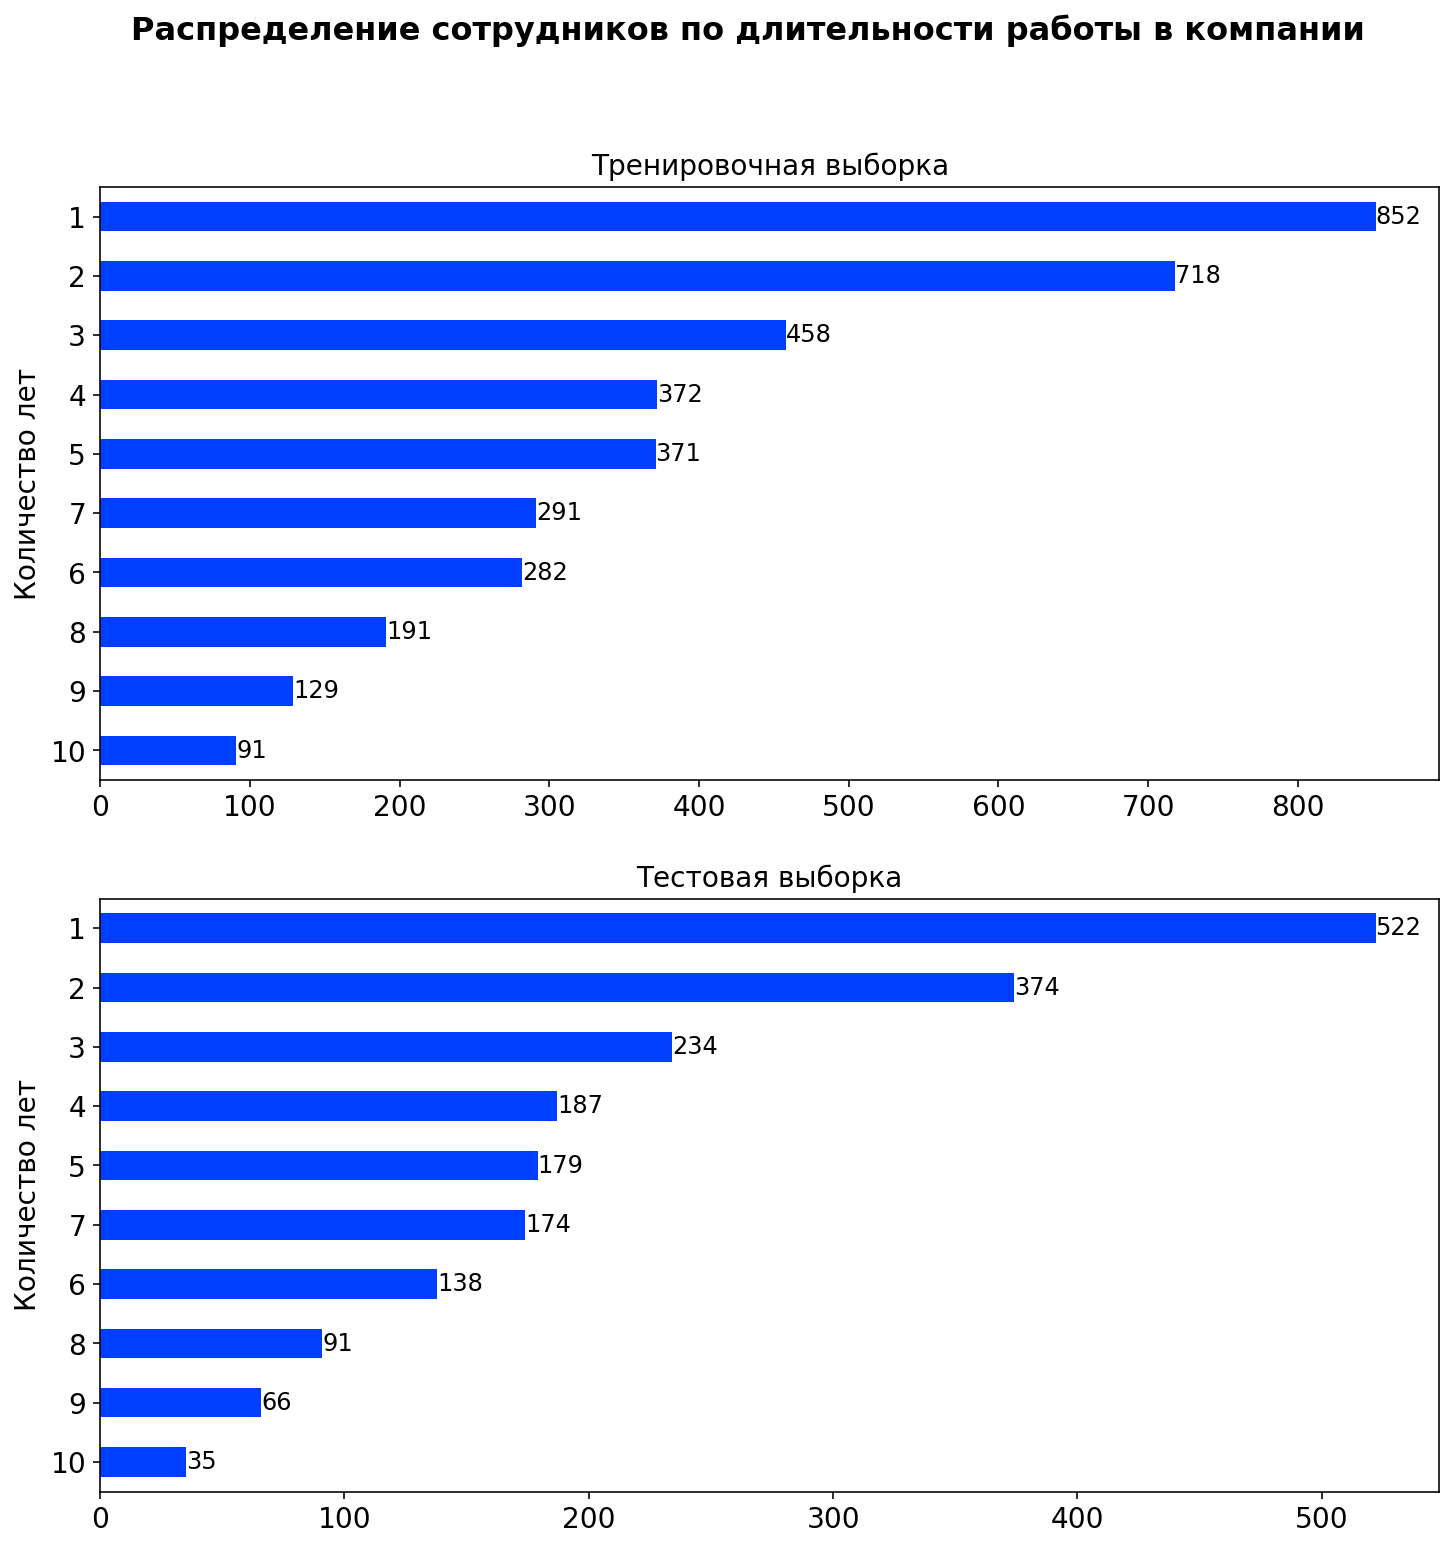

In [ ]:
# вызов функции для построения горизонтальной столбчатой диаграммы для столбца 'employment_years'
disc_plot('employment_years', 'Распределение сотрудников по длительности работы в компании',
          'Количество лет')

In [ ]:
df_train['employment_years'].value_counts()

1     852
2     718
3     458
4     372
5     371
7     291
6     282
8     191
9     129
10     91
Name: employment_years, dtype: int64

Согласно полученной столбчатой диаграмме, большинство сотрудников (966 чел. в тренировочной выборке) работают всего год. И меньше всего сотрудников (91 чел. в тренировочной выборке) работают 10 лет.

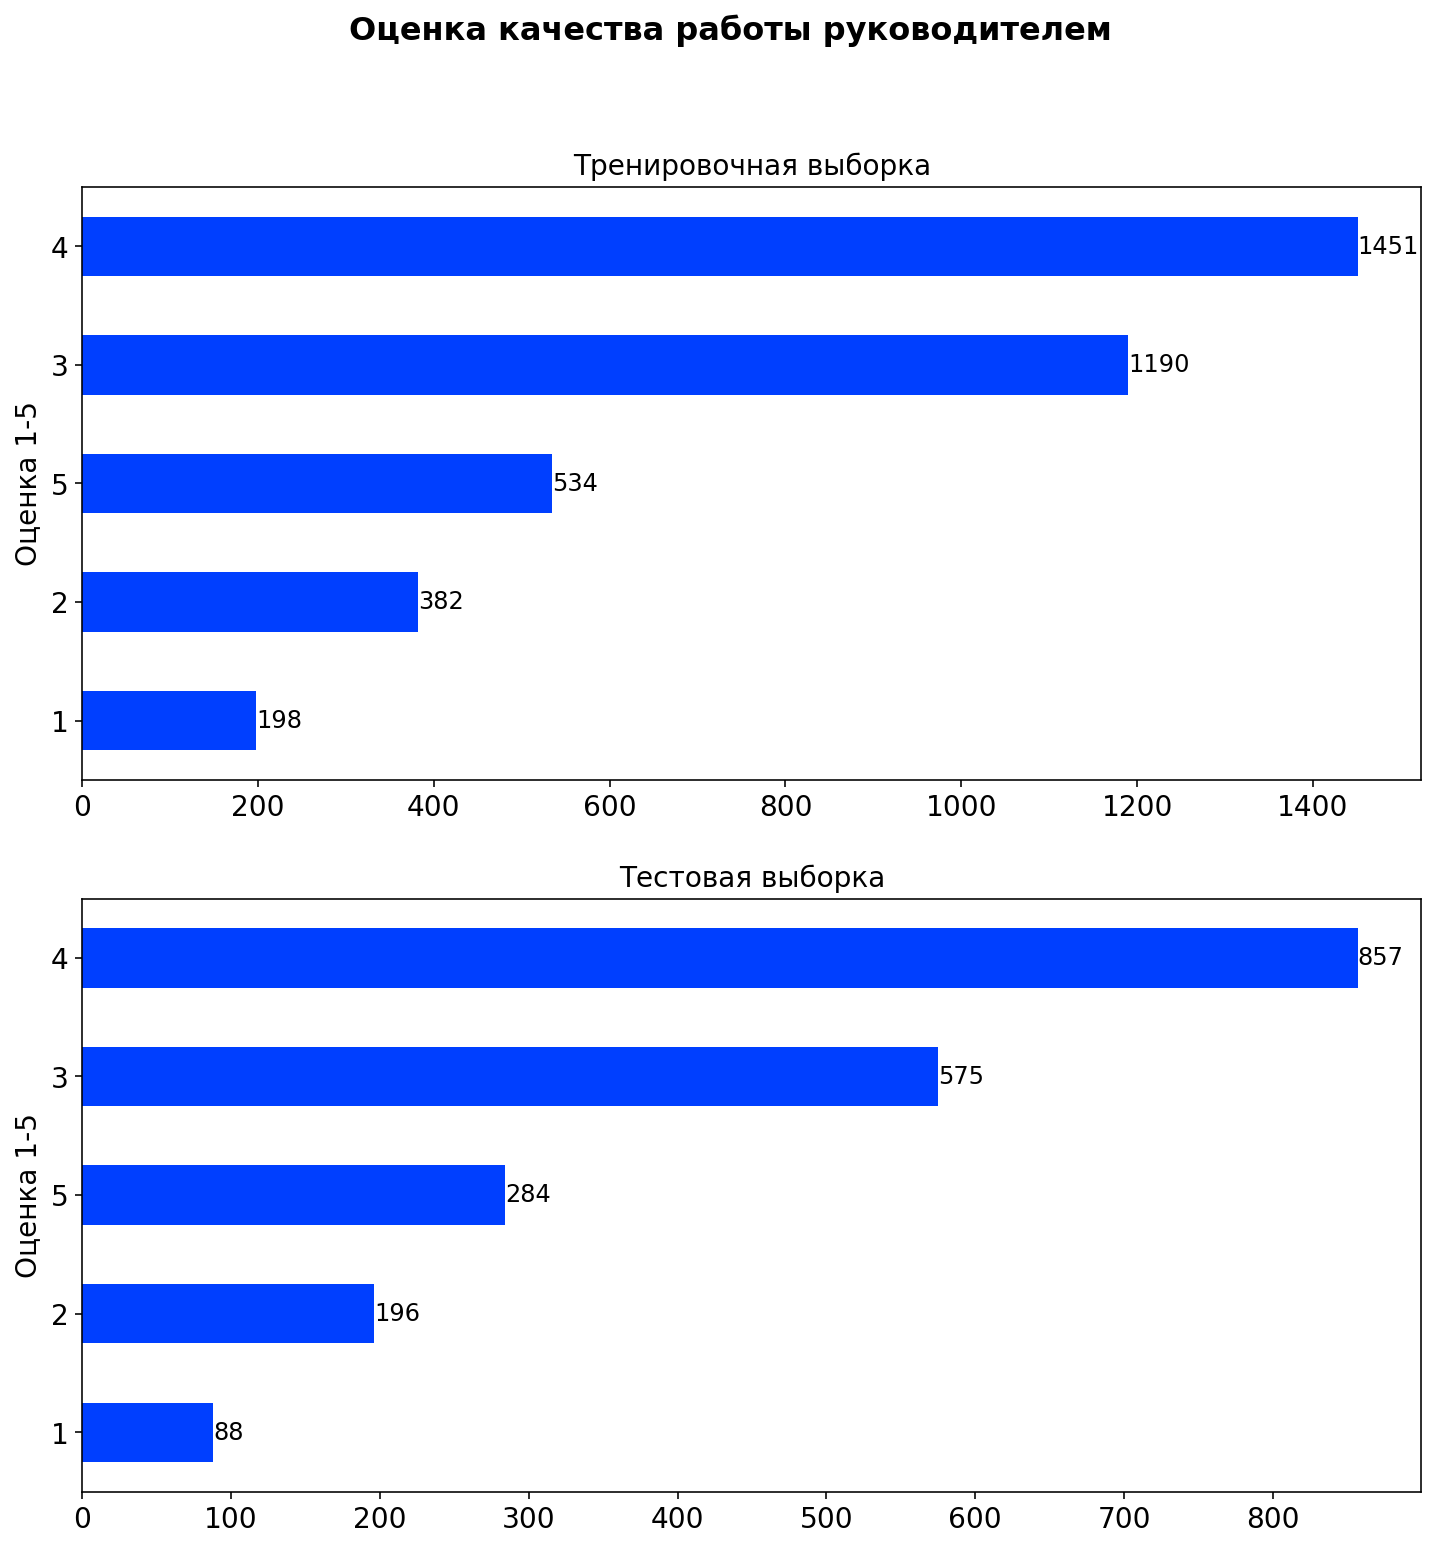

In [ ]:
# вызов функции для построения горизонтальной столбчатой диаграммы для столбца 'supervisor_evaluation'
disc_plot('supervisor_evaluation', 'Оценка качества работы руководителем',
          'Оценка 1-5')

In [ ]:
df_train['supervisor_evaluation'].value_counts()

4    1451
3    1190
5     534
2     382
1     198
Name: supervisor_evaluation, dtype: int64

Согласно полученным диаграммам большинство сотрудников получают от своих руководителей оценку 4 (1603 чел. на тренировочной выборке). Разбивка на выборки проведена корректно. Значения каждого класса присутствуют пропорционально в каждой из выборок.

#### Построение графиков для категориальных признаков

Для категориальных признаков построим круговые диаграммы для того, чтобы оценить долю каждой категории в общем объеме данных по этому признаку.

Для этого создадим функцию cat_plot, которая с помощью метода value_counts() подсчитает количество всех уникальных значений признака. Затем из полученного объекта Series сделаем датафрейм методом to_frame() и построим круговую диаграмму передав методу plot() параметр kind='pie'.

In [ ]:
# функция build_pie_cat_feature для создания двух круговых диаграм по тренировочной и тестовой выборке
def build_pie_cat_feature(title, feature):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 7))
    plt.suptitle(title)

    df_train[feature] \
        .value_counts() \
        .to_frame() \
        .plot(y=feature, kind='pie', ax=axes[0], autopct='%1.1f%%', legend=False, ylabel='',
              cmap='cividis', wedgeprops=dict(width=0.5))
    axes[0].set_title('Тренировочная')

    df_test[feature] \
        .value_counts() \
        .to_frame() \
        .plot(y=feature, kind='pie', ax=axes[1], autopct='%1.1f%%', legend=False, ylabel='',
              cmap='cividis', wedgeprops=dict(width=0.5))
    axes[1].set_title('Тестовая')
    plt.show()

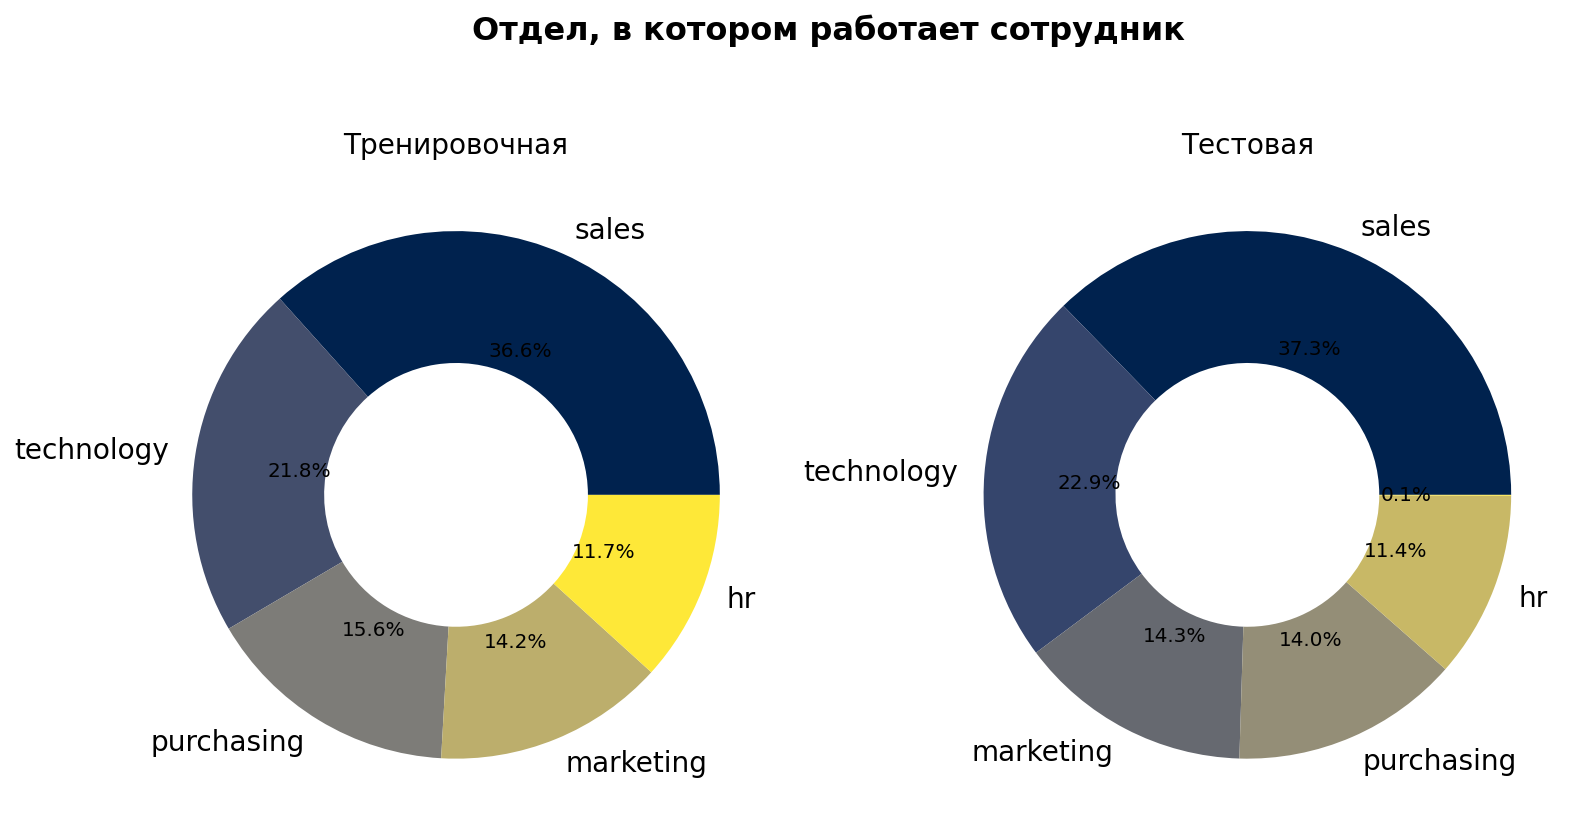

In [ ]:
# вызов функции build_pie_cat_feature для категории Отдел
build_pie_cat_feature('Отдел, в котором работает сотрудник', 'dept')

Большинство сотрудников компании работают в отделе продаж. Данные в обеих выборках распределены пропорционально.

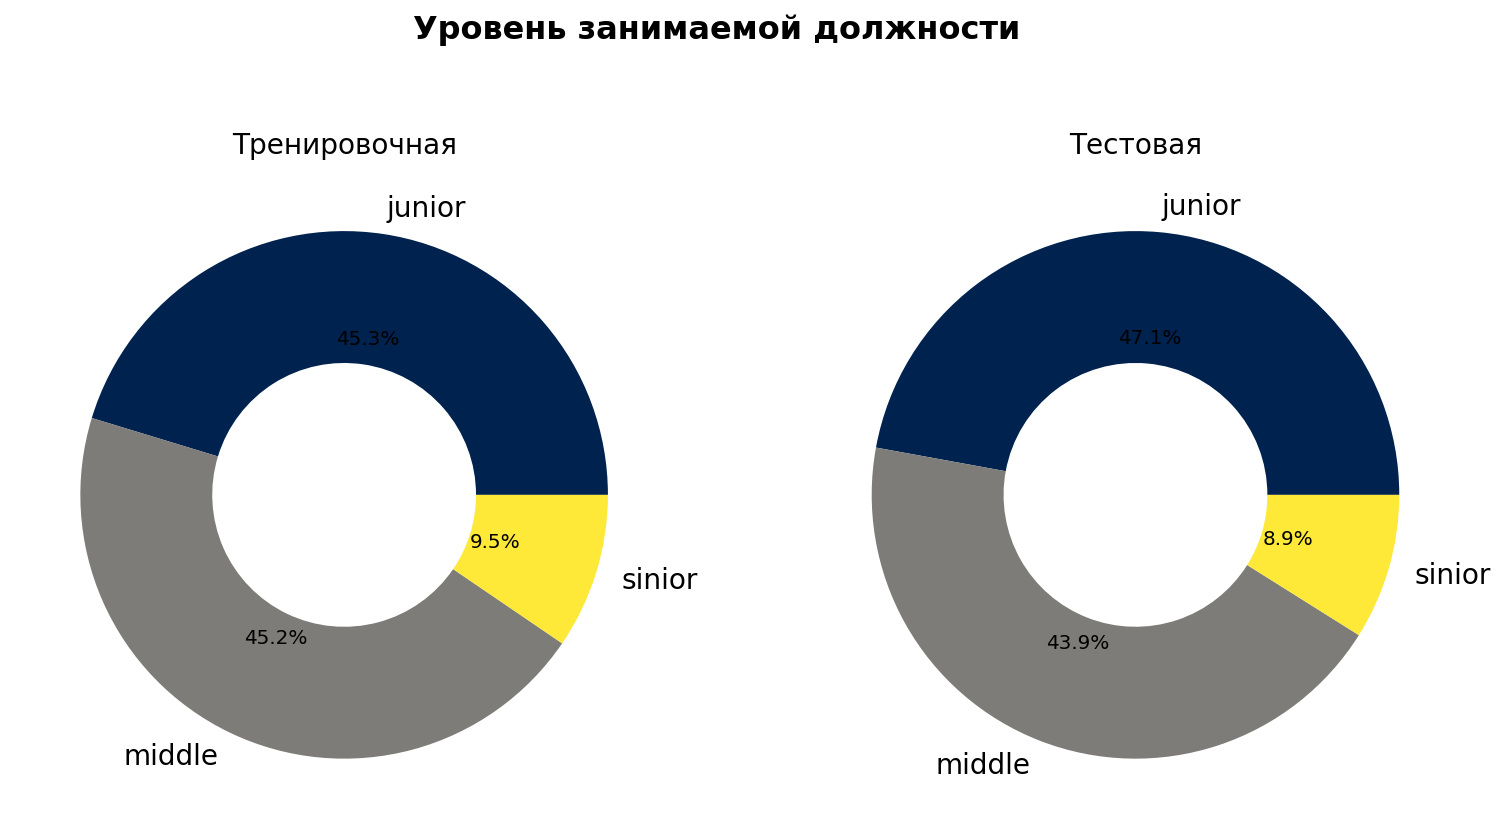

In [ ]:
# вызов функции build_pie_cat_feature для категории Уровень занимаемой должности
build_pie_cat_feature('Уровень занимаемой должности', 'level')

В компании преобладают сотрудники уровня Junior, чуть меньше уровня Middle и менее 10% Sinior. Данные разделены пропорционально.

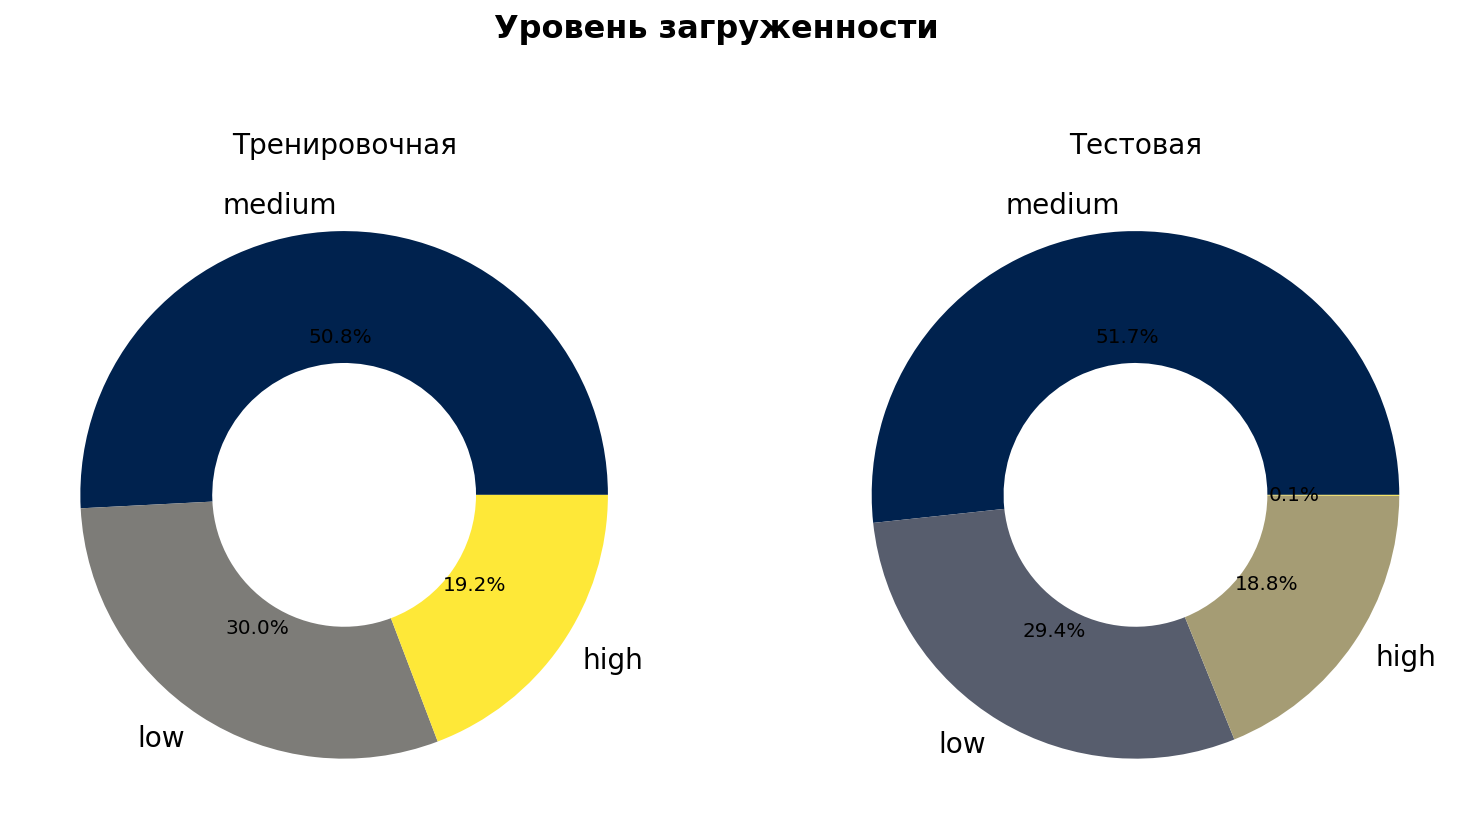

In [ ]:
# вызов функции build_pie_cat_feature для категории Уровень загруженности
build_pie_cat_feature('Уровень загруженности', 'workload')

Чуть более половины сотрудников имеют среднюю загрузку, около 30% - низкую и около 18% сильно загружены. Выборки стратифицированы.

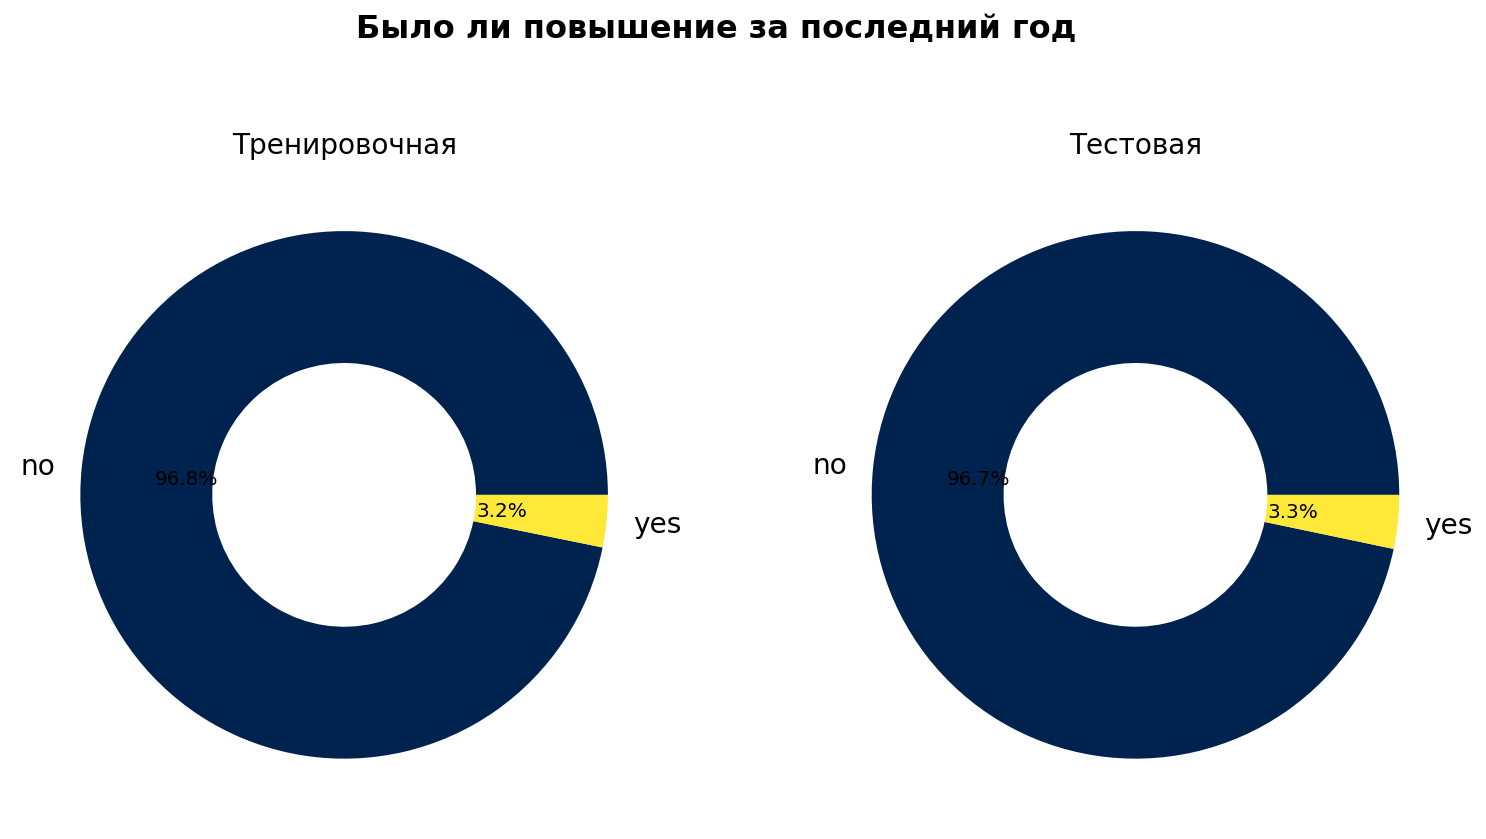

In [ ]:
# вызов функции build_pie_cat_feature для категории Повышение
build_pie_cat_feature('Было ли повышение за последний год', 'last_year_promo')

Только у 3% сотрудников за последний год было повышение. Выборки разбиты пропорционально.

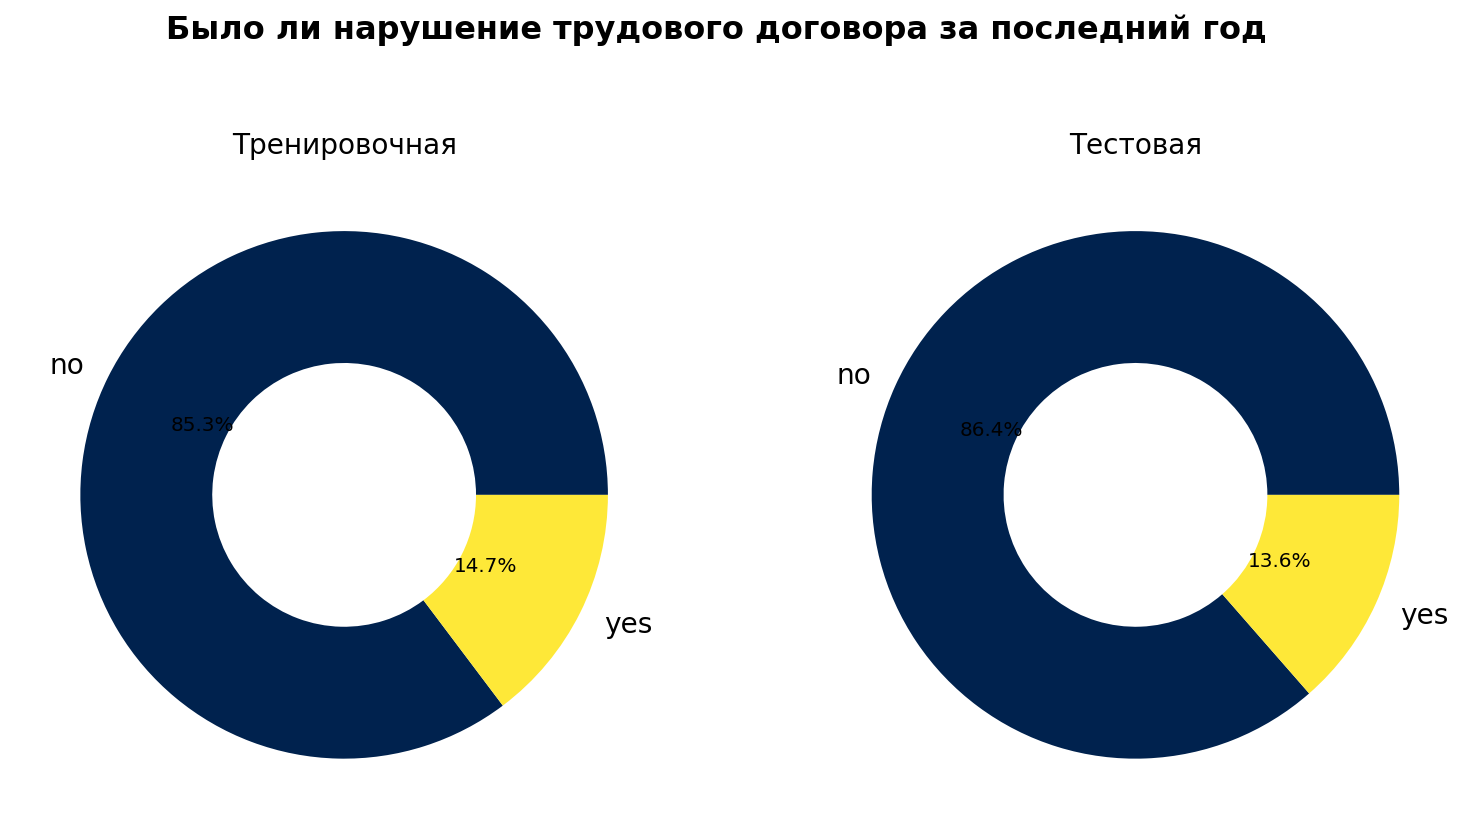

In [ ]:
# вызов функции build_pie_cat_feature для категории Нарушение
build_pie_cat_feature('Было ли нарушение трудового договора за последний год', 'last_year_violations')

У большинства сотрудников (86%) нарушений не было. Выборки стратифицированны.

### Корреляционный анализ

Создадим функцию, которая в цикле будет строить диаграммы рассеяния между количественными признаками и уровенем удовлетворенности работой, а в качестве раскраски точек будут использоваться категориальные признаки.

In [ ]:
def build_in_loop(cat_feature, feature_name):
    fig = plt.subplots(figsize=(15, 15))
    plt.suptitle('Диаграмма рассеяния\n Цвет точек: '+feature_name)
    a = 2 # количество рядов
    b = 2 # количество столбцов
    c = 1 # номер сабплота

    features = [('salary', 'Зарплата сотрудника'), ('employment_years', 'Годы работы'),
               ('supervisor_evaluation', 'Оценка руководителем')]

    for i, feature in enumerate(features):
        plt.subplot(a, b, c)
        plt.grid(True)
        plt.title('Уровень удовлетворенности работой vs. '+feature[1])
        plt.xlabel(feature[1])
        plt.ylabel('Уровень удовлетворенности работой')
        sns.scatterplot(x=feature[0], y='job_satisfaction_rate', data=df_test, hue=cat_feature)
        c = c + 1

    plt.show()

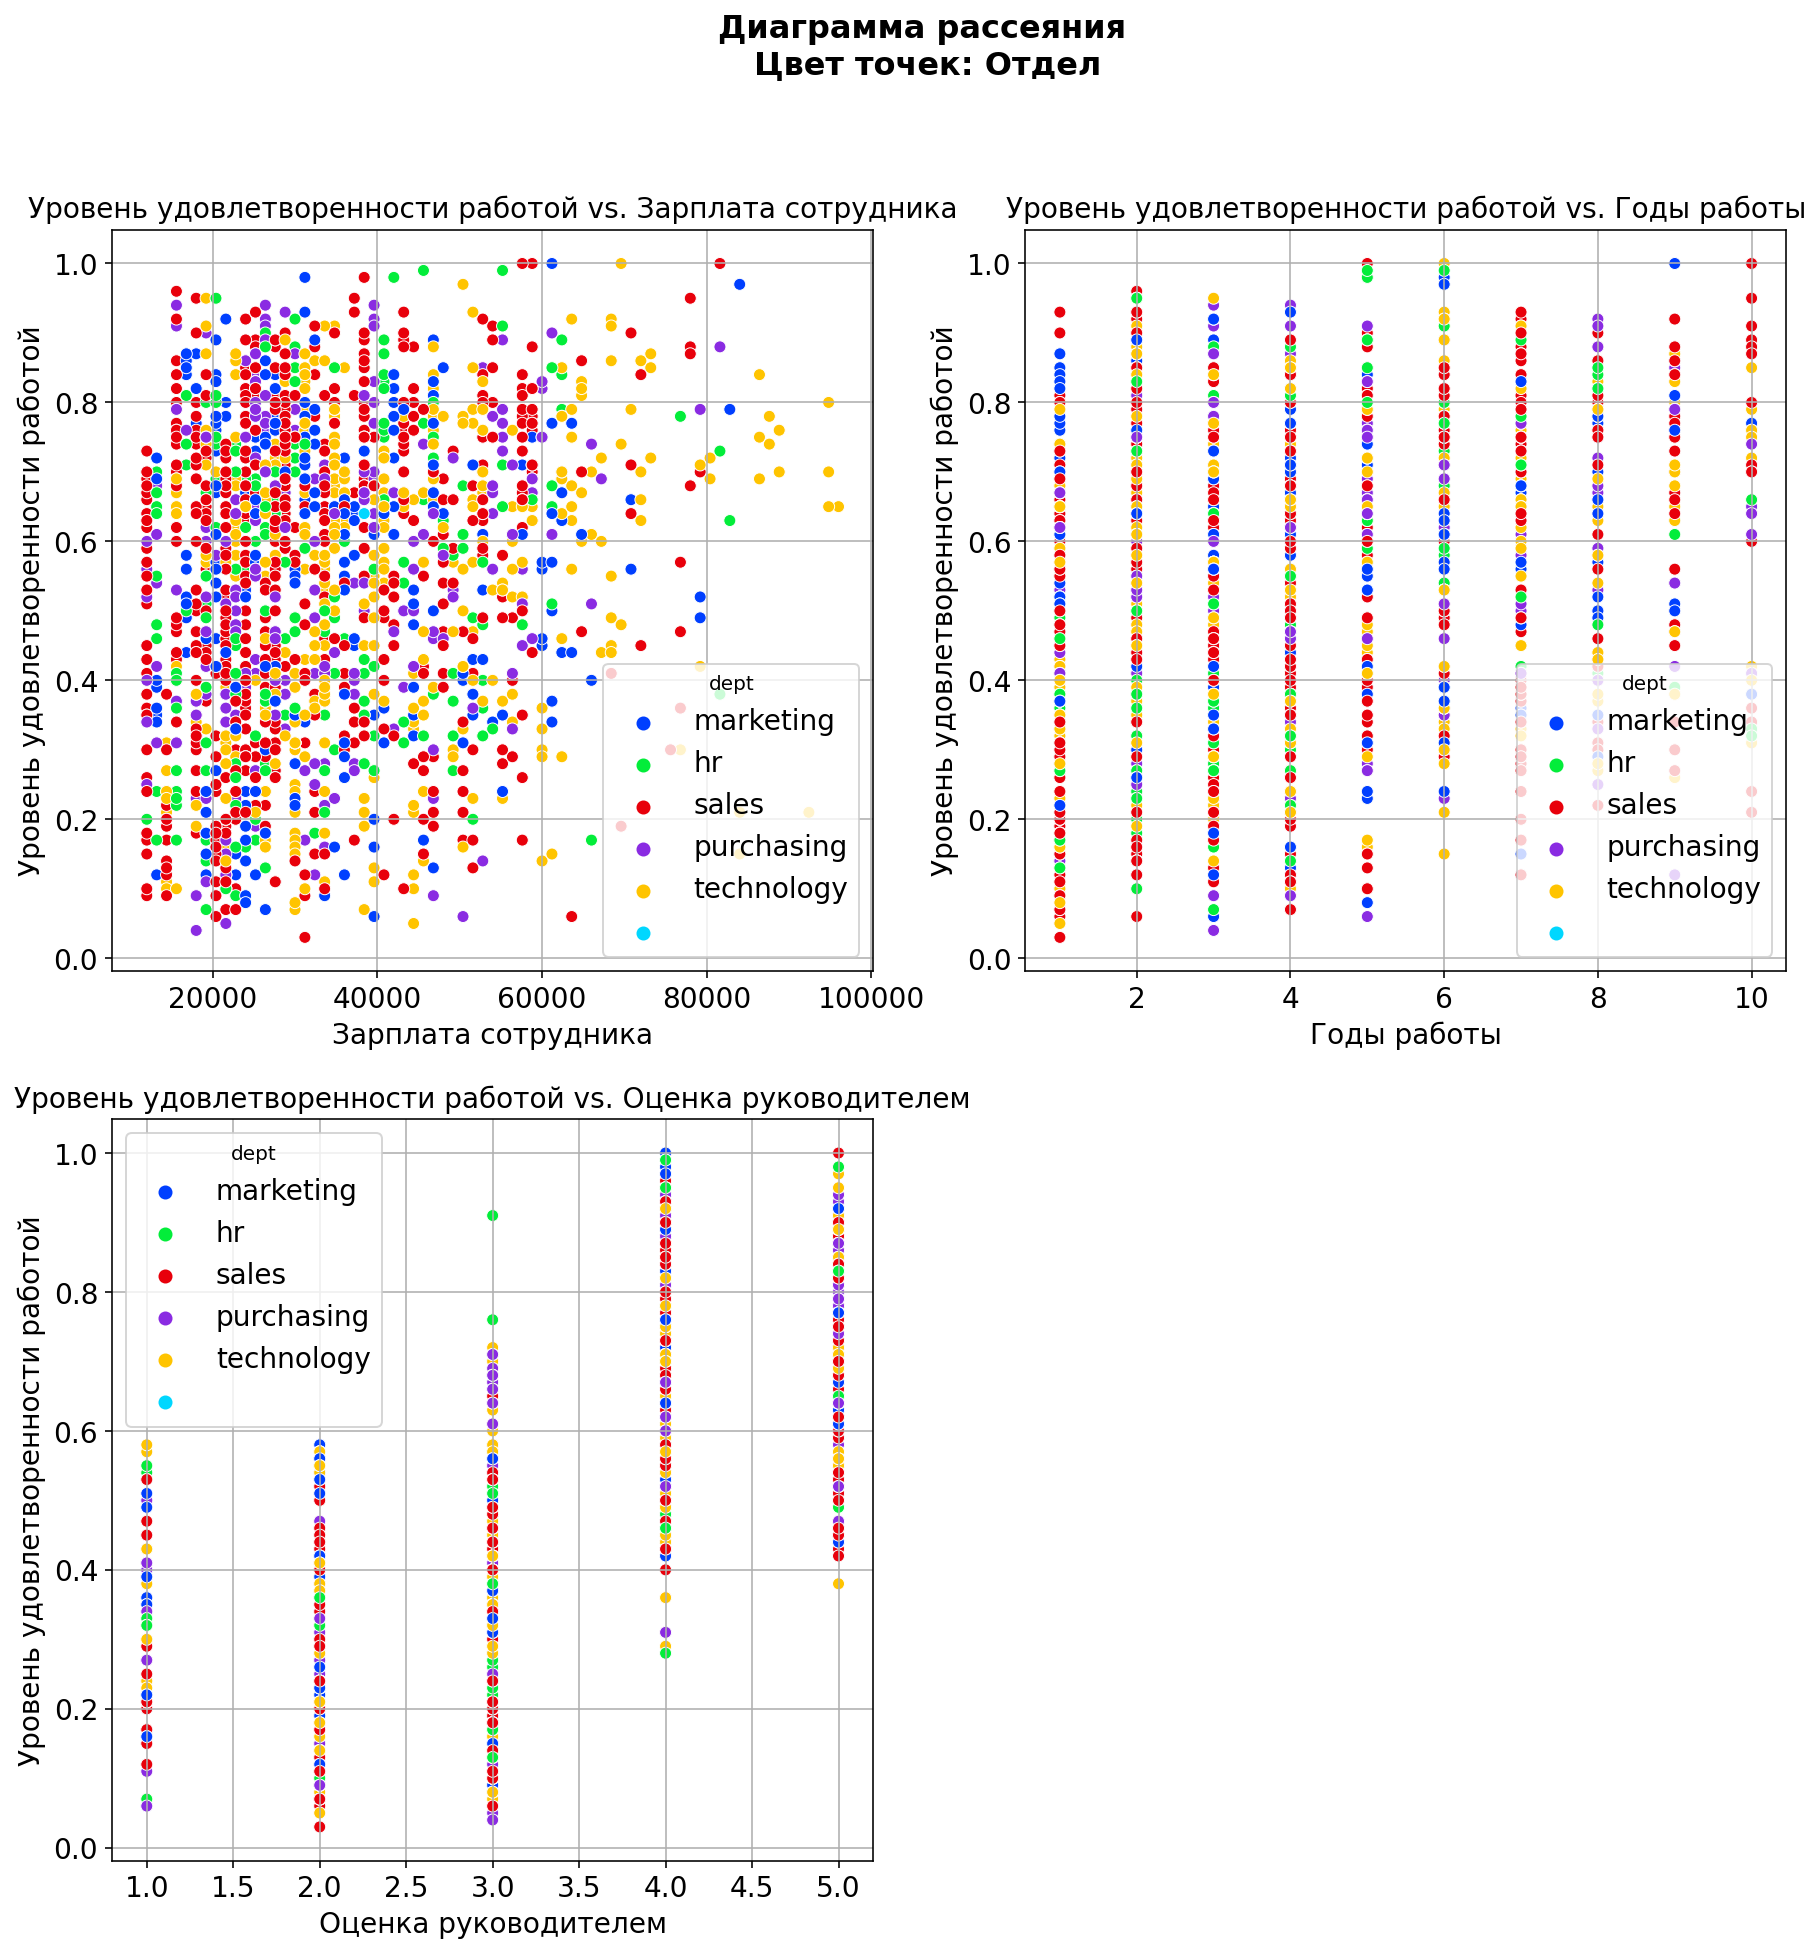

In [ ]:
build_in_loop('dept', 'Отдел')

По данным диаграммам не прослеживается какая-то корреляционная связь между названием отдела и другими признаками.
Прослеживается определенная прямая связь между уровнем удовлетворенности и признаками "зарплата" и "оценка".

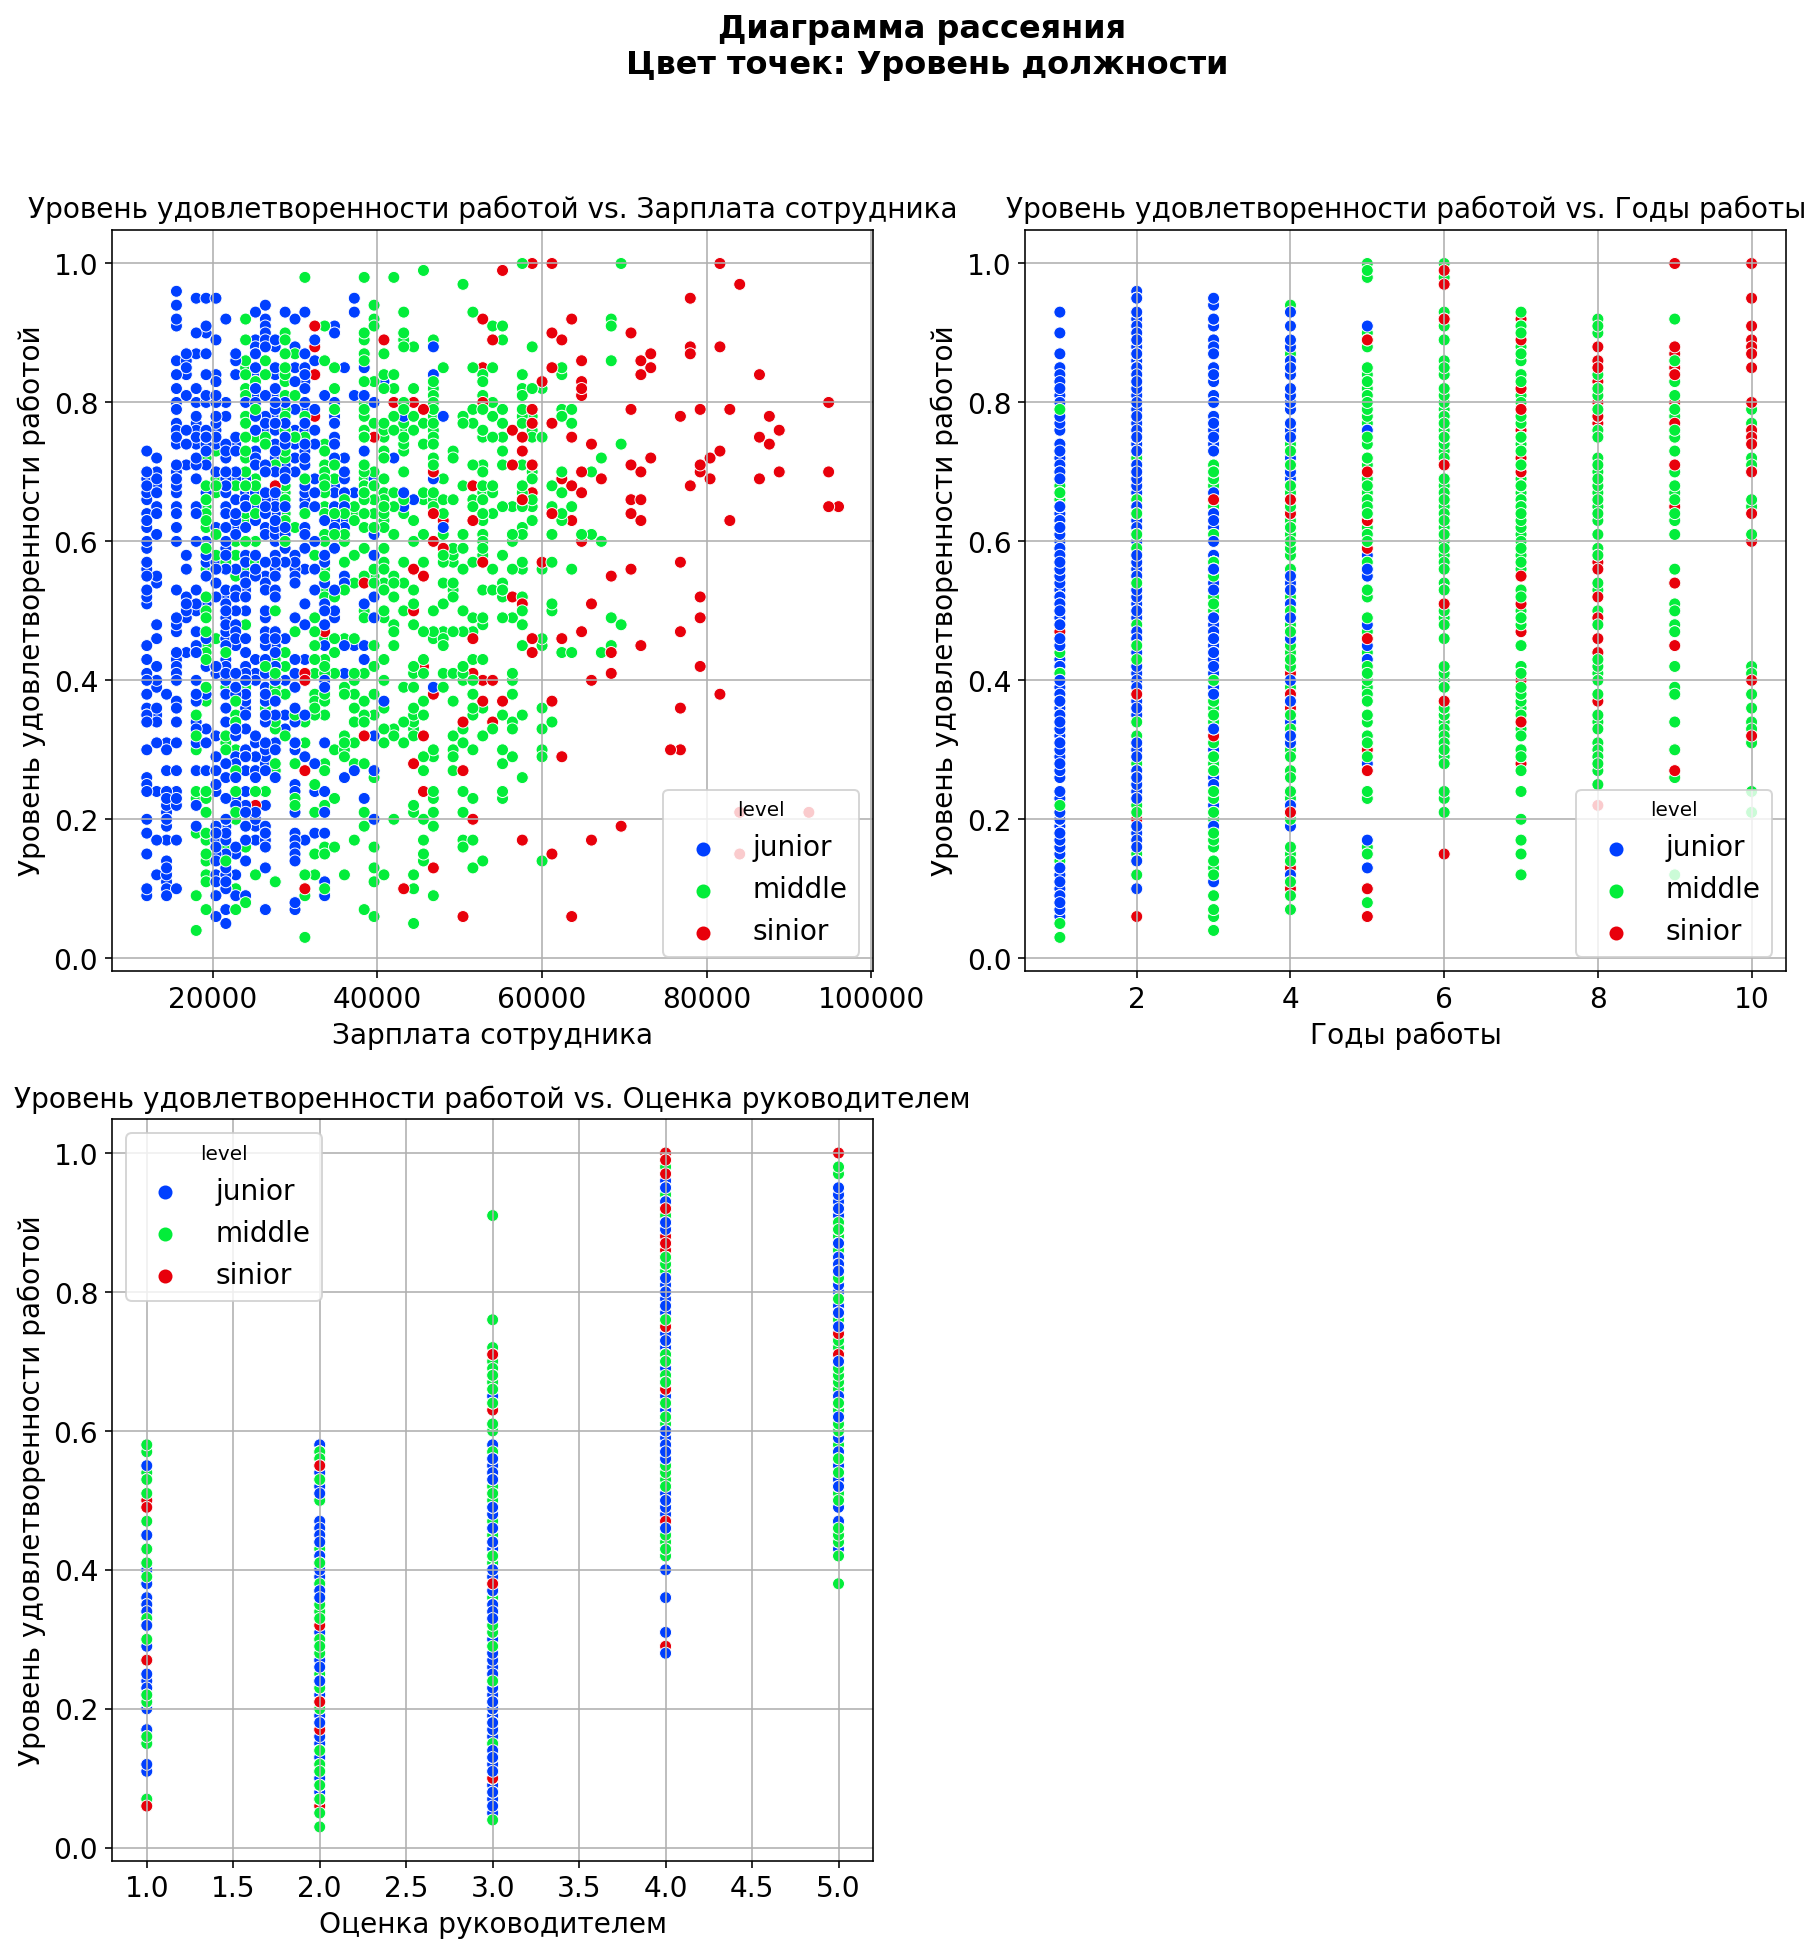

In [ ]:
build_in_loop('level', 'Уровень должности')

Присутствует достаточно заметная взаимосвязь между уровнем занимаемой должности и зарплатой. Junior имеют преимущественно зарплату до 40 тыс.р, middle от 40 до 60 тыс., а sinior выше 60 тыс.руб.

По длительности работы также прослеживается связь с уровнем должности. Junior работают преимущественно менее 4 лет, а middle - более 4 лет. Для sinior какой-то определенной закономерности нет. С целевым признаком тоже не прослеживается определенной взаимосвязи.

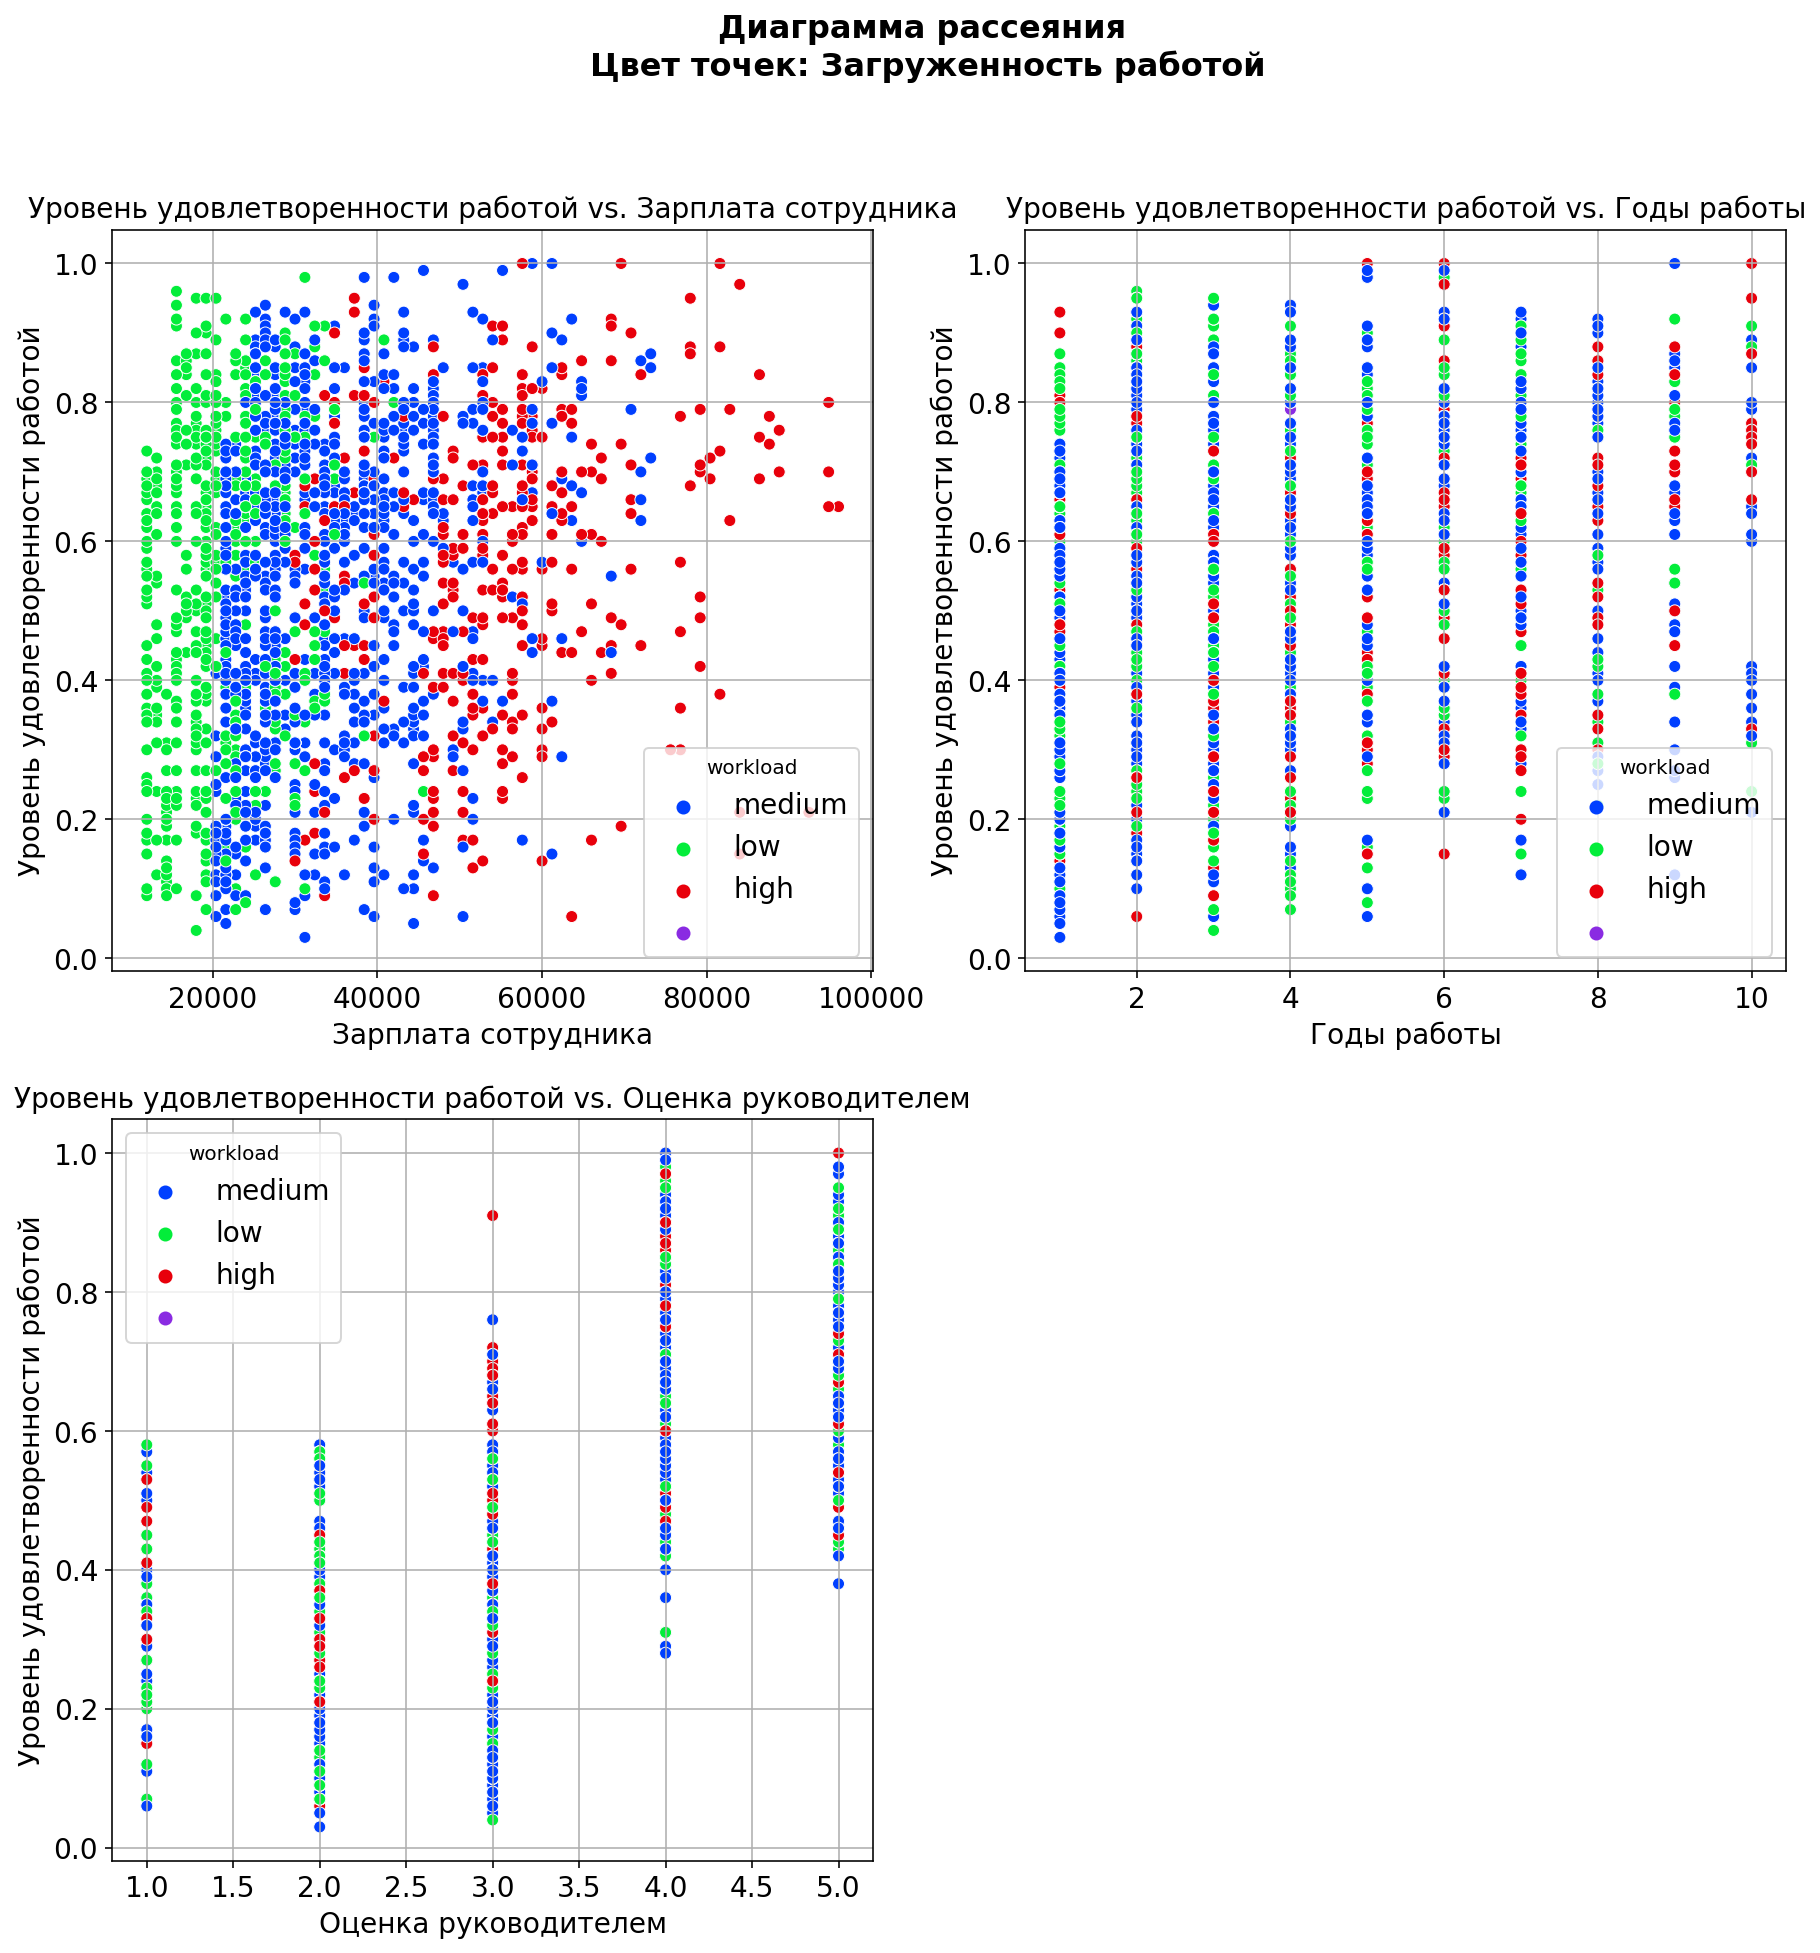

In [ ]:
build_in_loop('workload', 'Загруженность работой')

Прослеживается четкая связь загруженности на работе и зарплатой сотрудников. Более низкооплачиваемые работают меньше, а высокооплачиваемые больше.

Загруженность не имеет заметной связи с количеством лет в компании, оценкой руководителя и уровнем удовлетворенности работой.

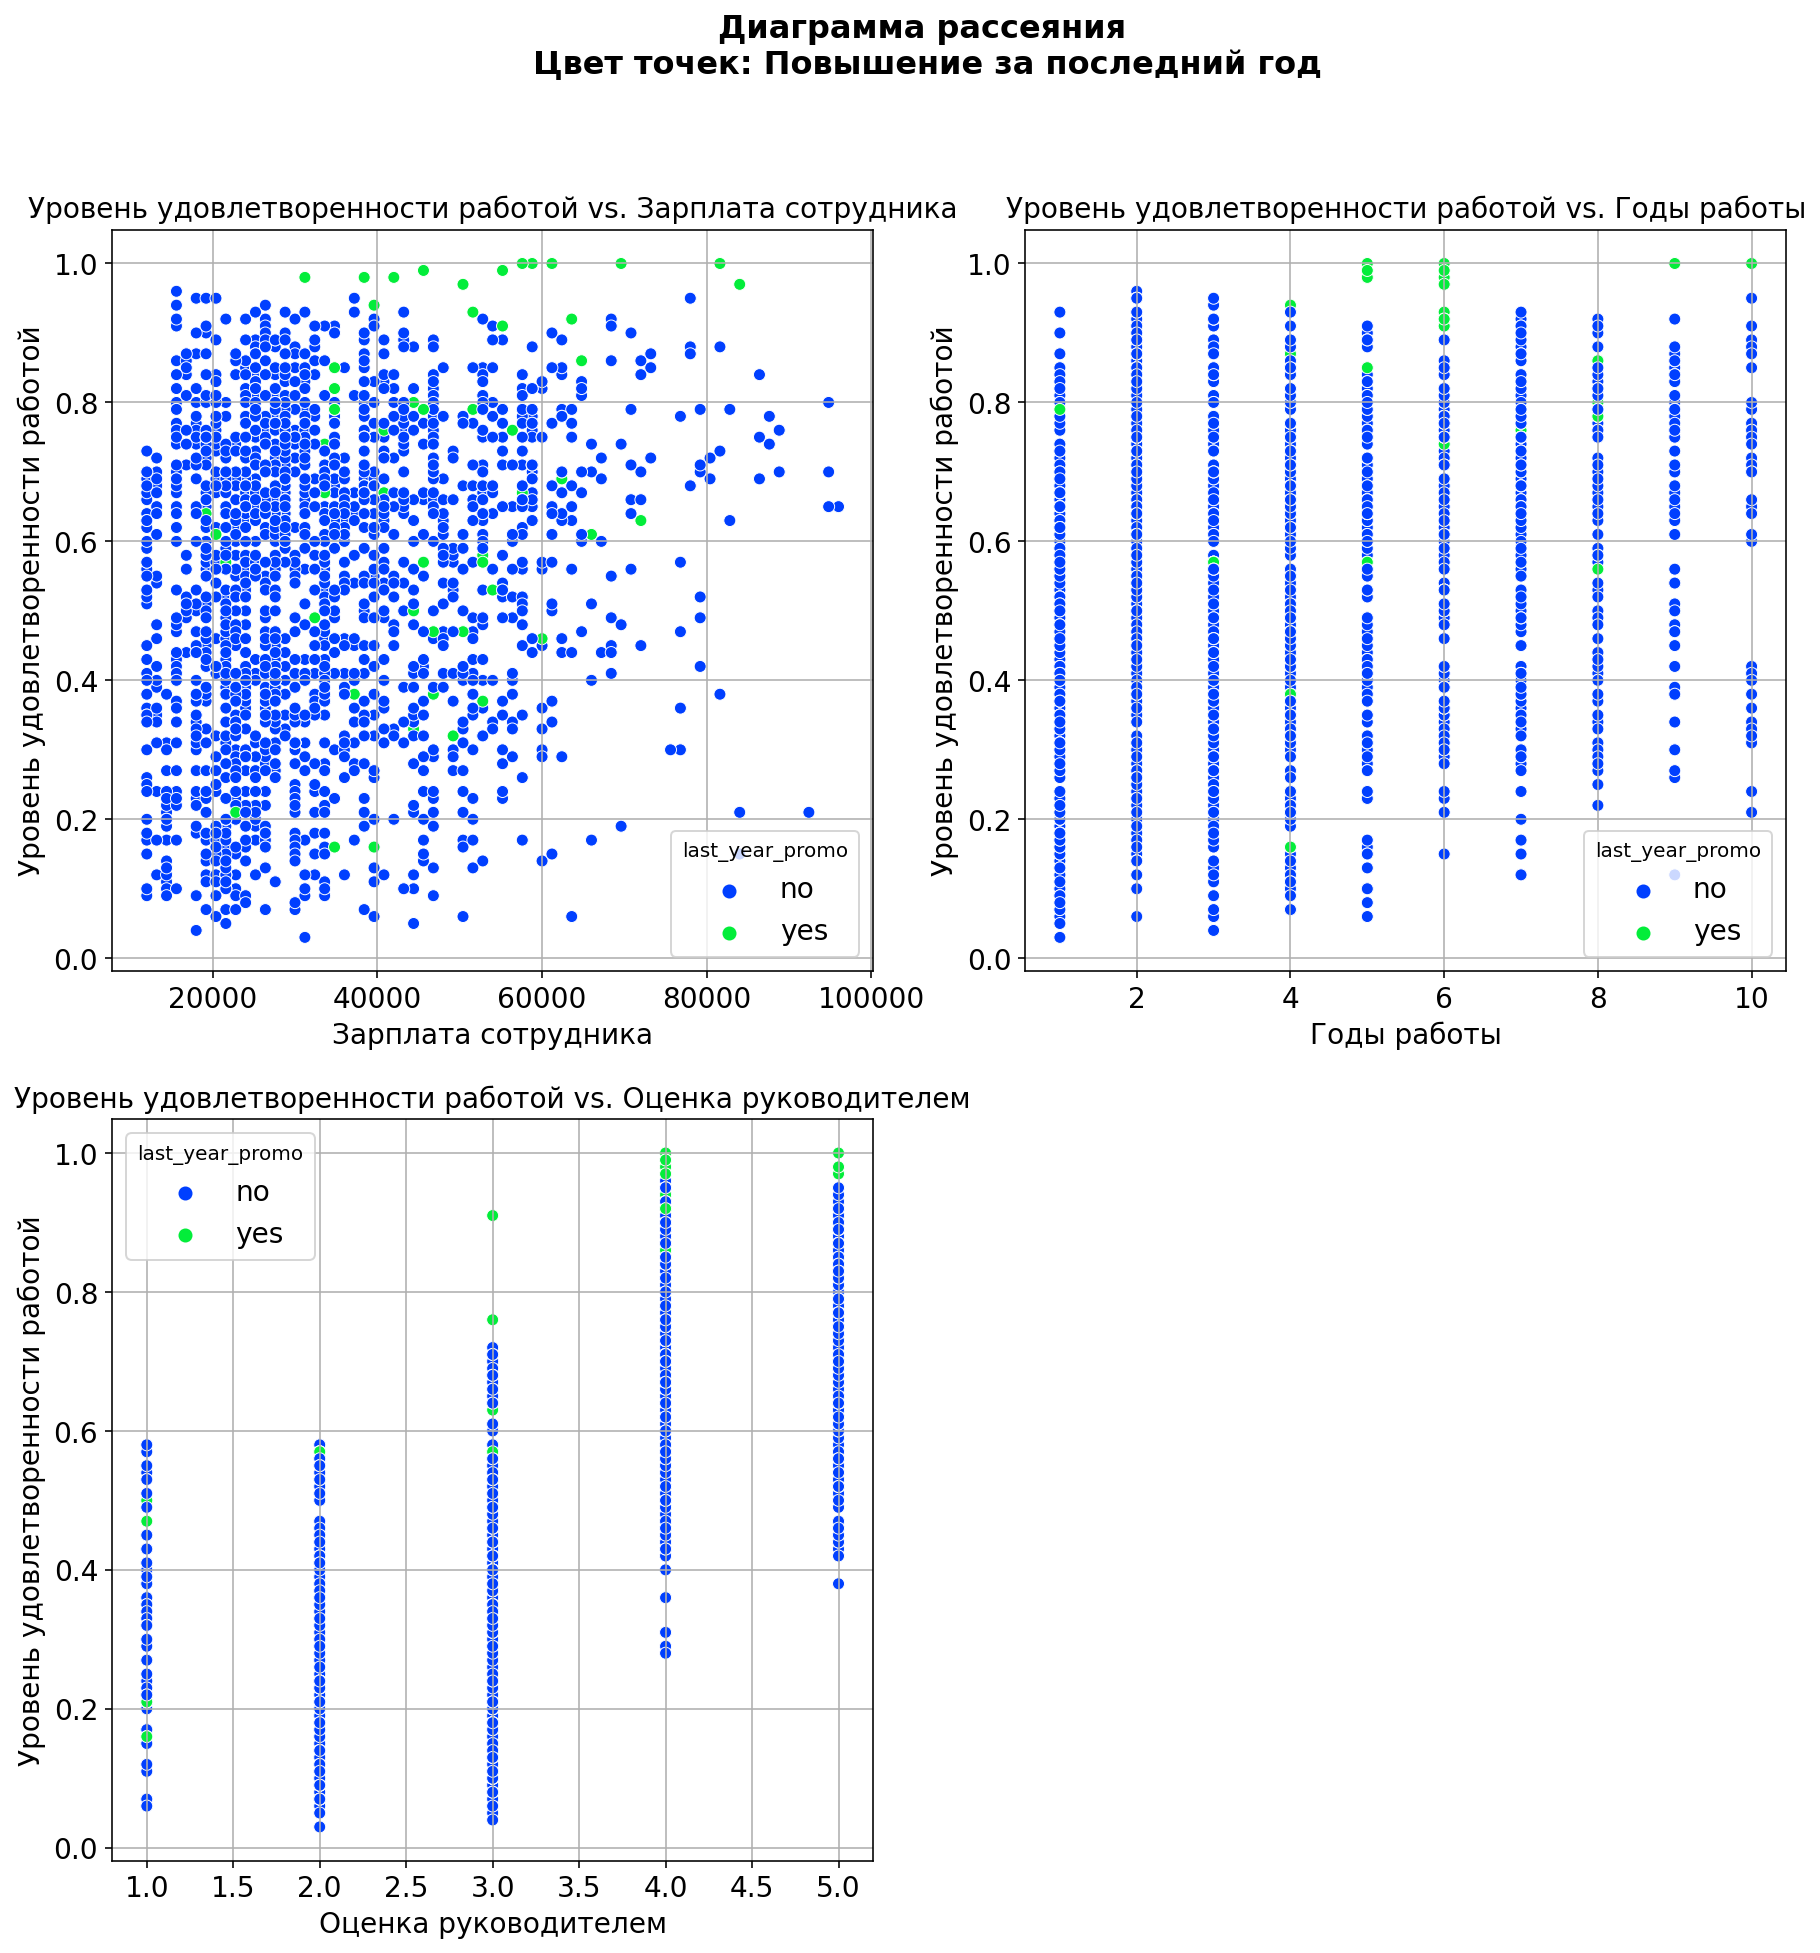

In [ ]:
build_in_loop('last_year_promo', 'Повышение за последний год')

Заметна определенная закономерность, что те, у кого было повышение за последний год преимущественно имеют высокий уровень удовлетворенности. Но есть сотрудники, у которых было повышение, но их уровнь удовлетворения не более 0.2.

Сотрудники, у которых было повышение преимущественно имеют зарплату от 20 до 60 тыс.руб.. Они проработали в компании более 5 лет. У большинства оценка руководителем равна 4.

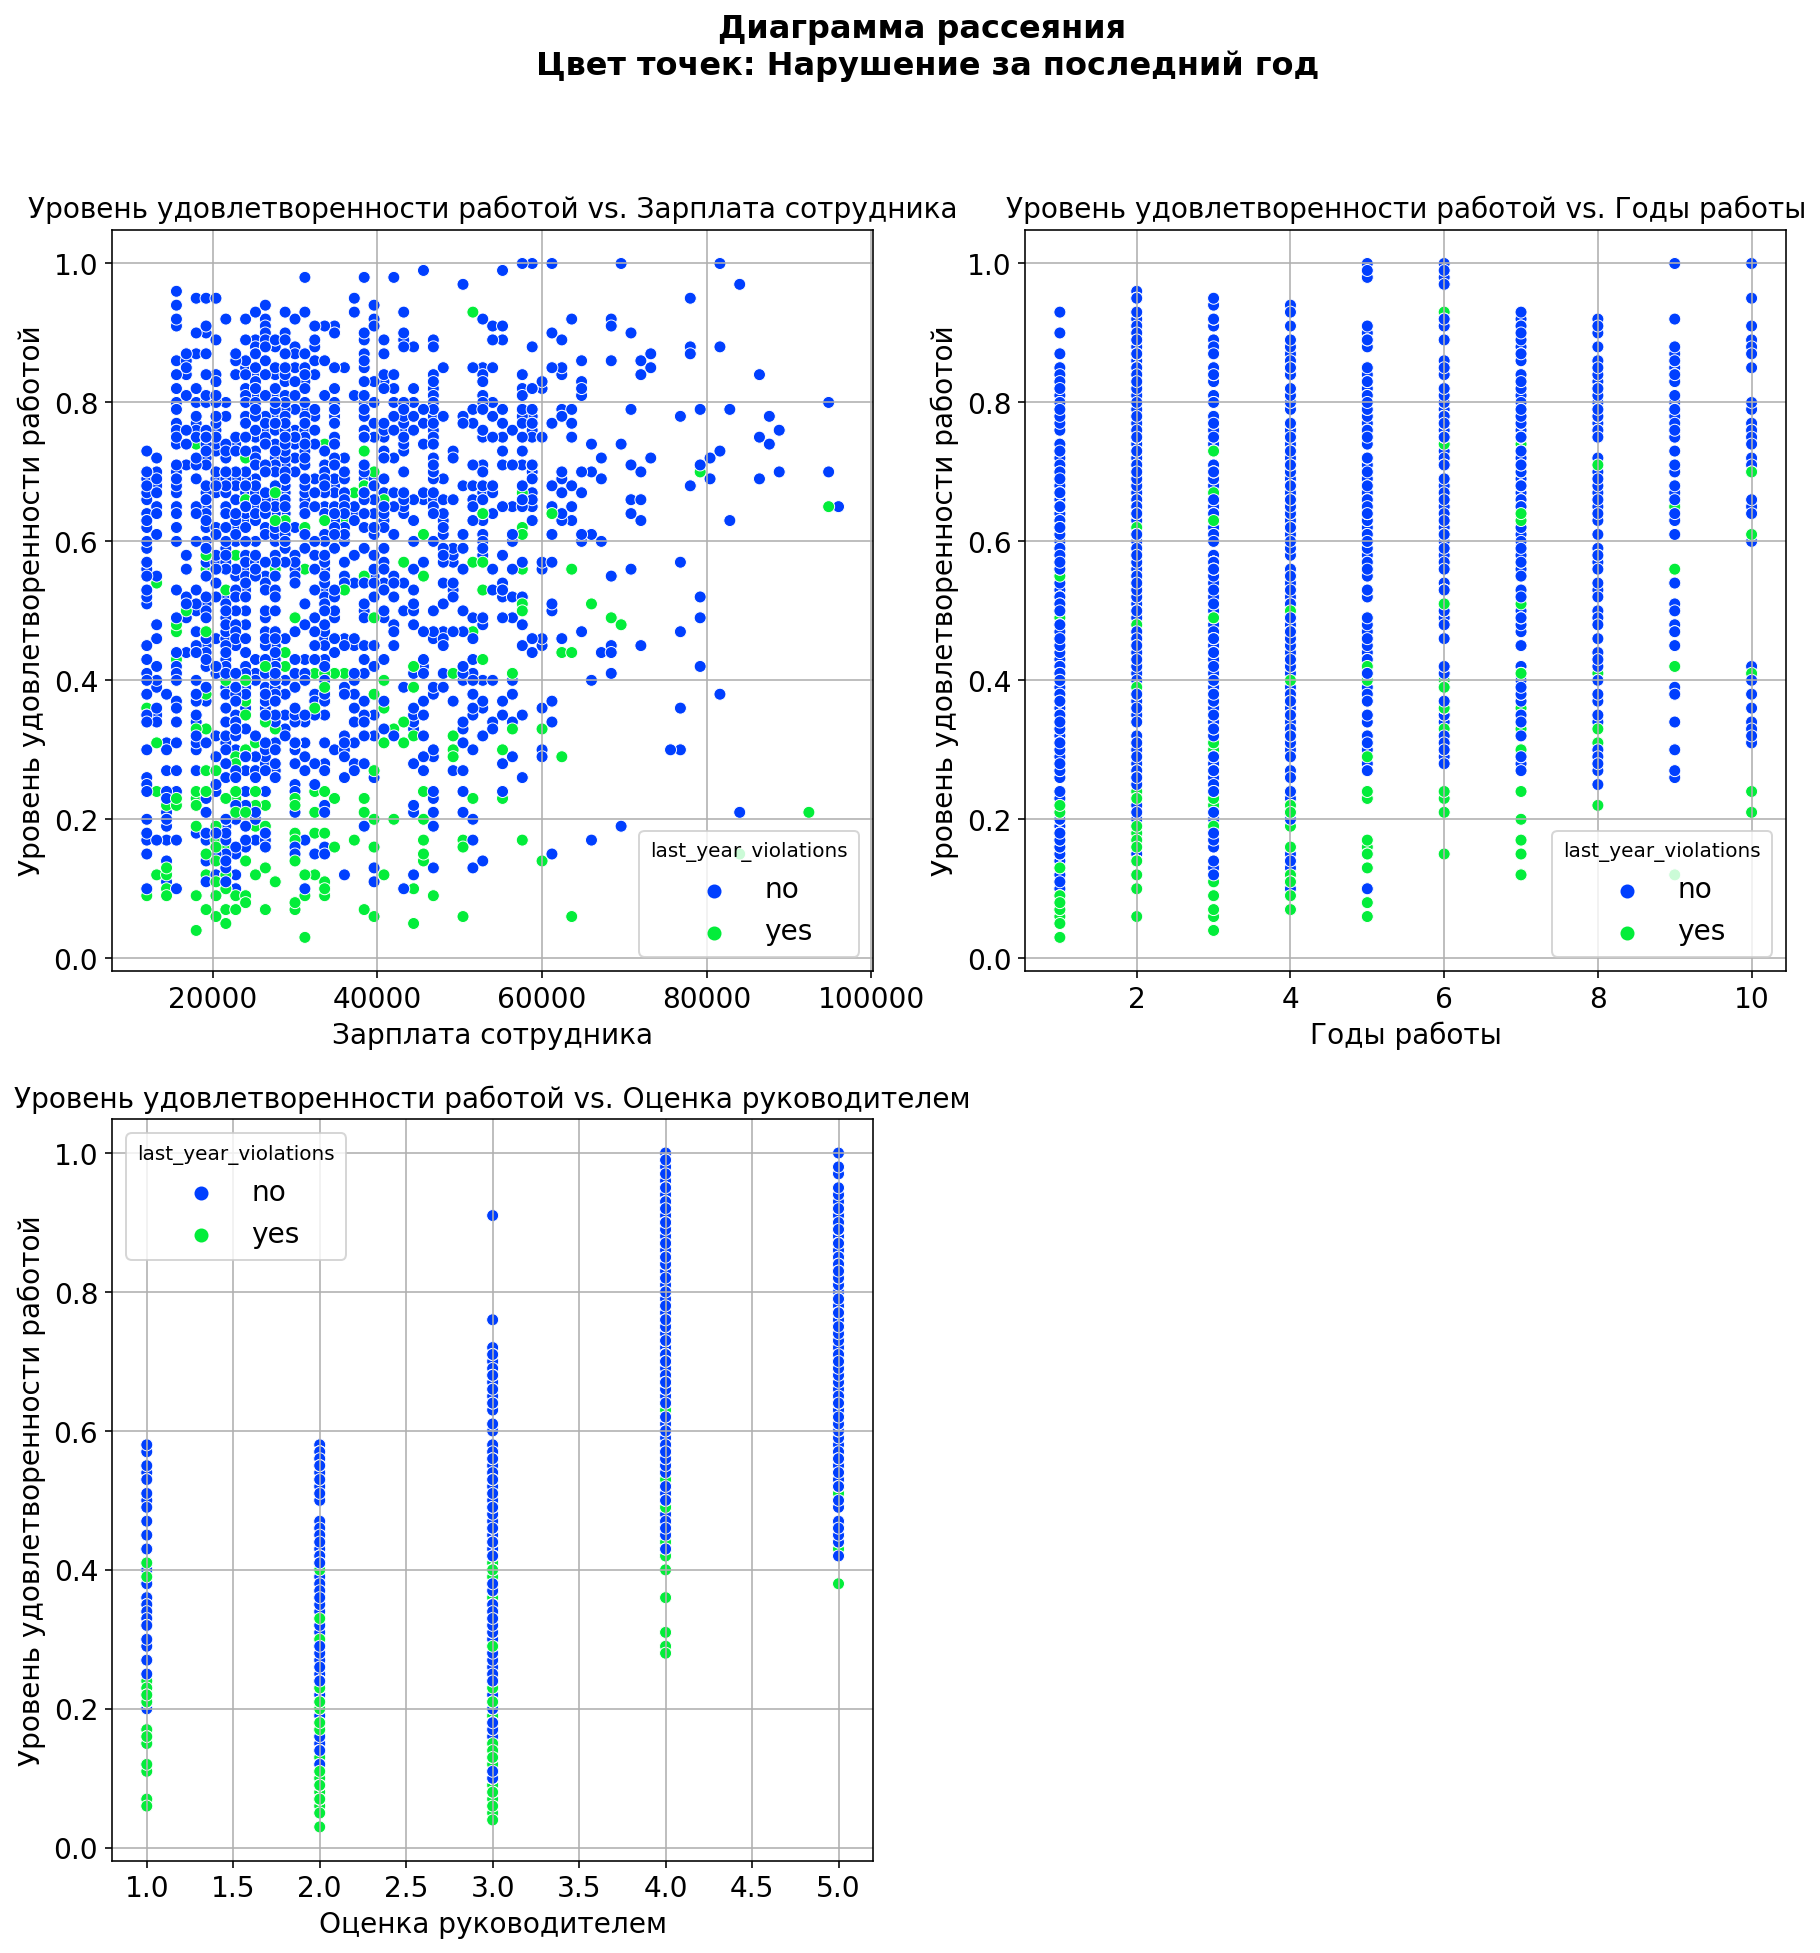

In [ ]:
build_in_loop('last_year_violations', 'Нарушение за последний год')

Уровень удовлетворенности работой среди сотрудников с нарушениями трудовой дисциплины преимущественно ниже 0.6. Нет четкой корреляции наличия нарушений и зарплаты, количество лет в компании и оценкой руководителя.

Рассчитаем коэффициенты корреляции между признаками разных типов данных. Для этого используем библиотеку phik.

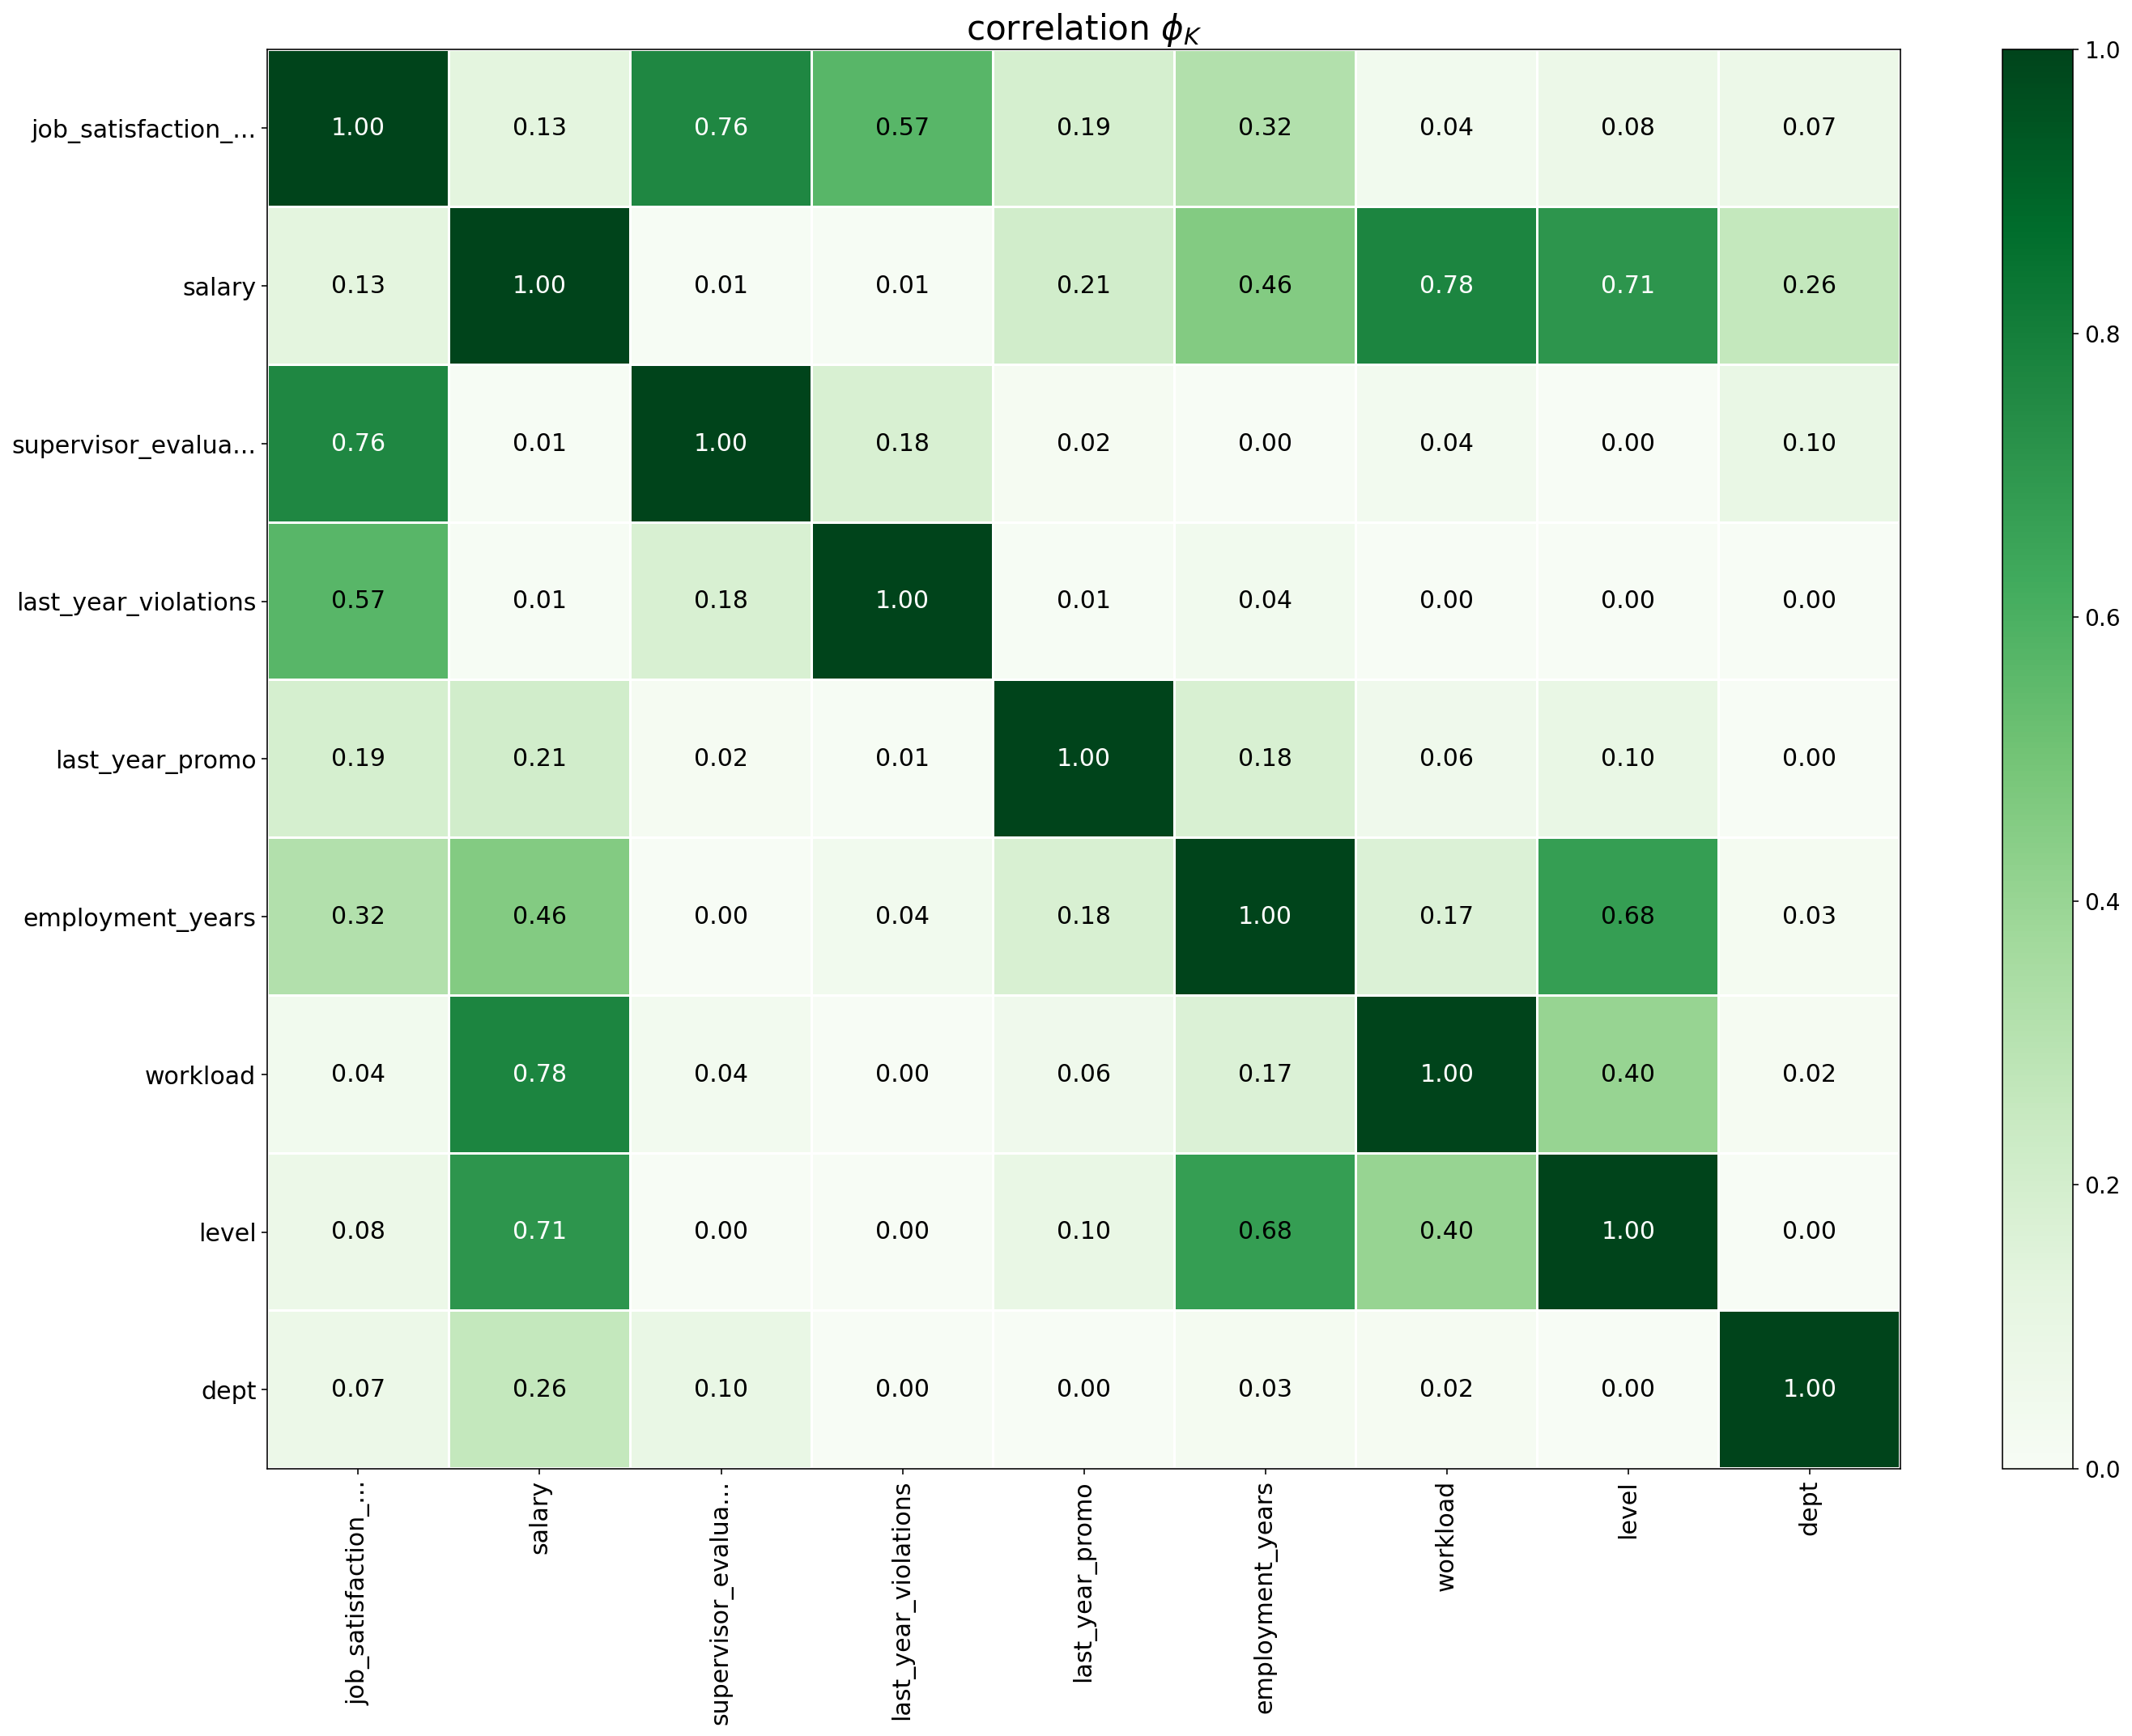

In [ ]:
# создаём список с наименованиями непрерывных признаков
interval_cols = ['salary', 'job_satisfaction_rate']

# считаем коэффициенты корреляции
phik_overview = phik_matrix(df_train, interval_cols=interval_cols)

# строим матрицу корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

Мультиколлинеарности нет.

На полученной тепловой карте показаны числовые оценки силы взаимосвязей между признаками, которые были описаны выше. Наибольшей корреляцией отмечаются признаки "salary" и "workload" (коэффициент корреляции равен 0.78), а также "job_satisfaction_rate" и "supervisor_evaluation" (0.76). На диаграммах рассеяния они также были заметны.

Признак "dept" имеет нулевую или очень слабую связь с остальными признаками, что также подтверждается диаграммами рассеяния.

### Подготовка данных и моделирование в пайплайне

Выполним подготовку признаков и моделирование в пайплайне.

Перечислим основные моменты и выводы:

1. Целевой признак - 'job_satisfaction_rate'
2. Категориальные номинальные признаки из столбцов 'dept', 'last_year_promo', 'last_year_violations' нужно кодировать с помощью OneHotEncoder.
4. Категориальный ранговые признаки из столбцов 'level', 'workload' закодируем с помощью OrdinalEncoder.
5. Добавим SimpleImputer для заполнения пропусков модой.
6. Количественные признаки из столбцов 'employment_years', 'supervisor_evaluation', 'salary' стандартизуем с помощью StandardScaler() и MinMaxScaler().
7. Признаков с высокой корреляцией с целевым признаком нет, поэтому утечки целевого признака быть не должно.
8. Используем метрику SMAPE при подборе гиперпараметров и оценке качества моделей.

In [ ]:
# задание константных значений
RANDOM_STATE = 42

# записываем входные данные в переменные Х_train и X_test, целевой признак в переменные у_train и y_test
X_train = df_train.drop(['job_satisfaction_rate'], axis=1)
y_train = df_train['job_satisfaction_rate']
X_test = df_test.drop(['job_satisfaction_rate'], axis=1)
y_test = df_test['job_satisfaction_rate']

# создаём списки с названиями признаков
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']


# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
# пайплайн для категориальных переменных из списка ohe_cols
ohe_pipe = Pipeline(
    [
    (
            'simpleImputer_before_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)),
    (
            'simpleImputer_after_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
    ]
    )

# пайплайн для категориальных переменных из списка ord_cols

ord_pipe = Pipeline(
    [
    (
            'simpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
     ('ord',OrdinalEncoder(
                categories=[
                    ['sinior', 'middle', 'junior'],
                    ['high', 'medium', 'low']
                ],
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
     ),
    (
            'simpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
    ]
    )

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)


In [ ]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__min_samples_split' : range(2, 15),
        'models__min_samples_leaf': range(1, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression(
            )],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

def smape(y_true, y_pred):
    # на вход: y_true - истинные значения,
    # y_pred - спрогнозированные
    return 100/len(y_true) * np.sum(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

# создаём пользовательскую метрику
scorer = make_scorer(smape, greater_is_better=False)

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring=scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_*(-1))

# рассчитаем прогноз и метрики на тестовых данных
y_test_pred = randomized_search.predict(X_test)
smape_test = smape(y_test, y_test_pred)
print(f'Метрика SMAPE на тестовой выборке: {round(smape_test, 3)}')


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_before_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('simpleImputer_after_ohe',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                              

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Наилучшей оказалась модель DecisionTreeRegressor с параметрами max_depth=13, min_samples_leaf=7, min_samples_split=10 и стандартизацией MinMaxScaler(). Ее метрика SMAPE на тренировочной выборке равна 15.7, на тестовой 14.07.

Посмотрим метрики по остальным моделям в топ-10 лучших моделей.

In [ ]:
result = pd.DataFrame(randomized_search.cv_results_)
result['mean_test_score'] = result['mean_test_score'] * (-1)

print(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']]
      .sort_values('rank_test_score'))

   rank_test_score                            param_models  mean_test_score  \
7                1  DecisionTreeRegressor(random_state=42)        15.748371   
6                2  DecisionTreeRegressor(random_state=42)        15.830571   
3                3  DecisionTreeRegressor(random_state=42)        16.135360   
2                4  DecisionTreeRegressor(random_state=42)        16.173466   
9                5  DecisionTreeRegressor(random_state=42)        16.337862   
1                6  DecisionTreeRegressor(random_state=42)        16.597732   
4                7  DecisionTreeRegressor(random_state=42)        17.409742   
5                8  DecisionTreeRegressor(random_state=42)        18.580558   
0                9  DecisionTreeRegressor(random_state=42)        22.691739   
8               10  DecisionTreeRegressor(random_state=42)        23.965105   

                                              params  
7  {'preprocessor__num': MinMaxScaler(), 'models_...  
6  {'preprocessor__n

Метрика SMAPE тем лучше, чем она меньше. Для наилучшей она равна 15.7.

In [ ]:
# создание и обучение модели DummyClassifier
dummy_model = DummyClassifier(random_state=RANDOM_STATE)
dummy_model.fit(X_train, y_train)

# предсказание на тестовых данных
dummy_model_preds = dummy_model.predict(X_test)

# оценка качества модели по метрике smape
smape_dummy = smape(y_test, dummy_model_preds)
print(f'Метрика SMAPE на тестовой выборке дамми-модели: {round(smape_dummy, 3)}')

Метрика SMAPE на тестовой выборке дамми-модели: 37.9


## Задача №2: Модель прогноза увольнения сотрудника

Считаем все исходные документы и сохраним их в соответствующие переменные.

In [ ]:
# сохранение данных тренировочной выборки
# в переменной df_train_quit
df_train_quit = pd.read_csv('/datasets/train_quit.csv')
df_train_quit.sample(10)

id        dept   level workload  employment_years last_year_promo  \
2981  360363          hr  junior      low                 4              no   
1879  499600       sales  sinior     high                 9              no   
45    366316  purchasing  sinior   medium                 8              no   
2153  775247  purchasing  middle      low                 5              no   
2182  748570  technology  middle      low                 5              no   
615   511259       sales  junior   medium                 2              no   
2128  460982  purchasing  middle   medium                 4              no   
1989  324098       sales  junior   medium                 5              no   
1314  233301       sales  junior   medium                 1              no   
1543  273342       sales  junior      low                 1              no   

     last_year_violations  supervisor_evaluation  salary quit  
2981                  yes                      3   15600  yes  
1879                   no                      4   64800   no  
45                     no                      5   62400   no  
2153                   no                      5   28800   no  
2182                   no                      2   21600   no  
615                    no                      3   20400   no  
2128                  yes                      3   33600   no  
1989                   no                      4   21600   no  
1314                   no                      5   28800   no  
1543                  yes                      4   19200  yes

In [ ]:
df_train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


<u>Выводы по первоначальному обзору данных в датафрейме **df_train_quit**</u>

- Названия столбцов менять не надо.
- Проверить неявные дубликаты в строковых столбцах.
- В таблице 4000 строчек и 10 столбцов.
- Пропусков нет.
- Типы данных преобразовывать не надо.

In [ ]:
# сохранение данных тренировочной выборки
# в переменной df_test_features
df_test_features = pd.read_csv('/datasets/test_features.csv')
df_test_features.sample(10)

id        dept   level workload  employment_years last_year_promo  \
1084  274022  purchasing  junior   medium                 1              no   
1399  327618       sales  junior   medium                 4              no   
597   927005   marketing  junior      low                 1              no   
903   847789          hr  junior   medium                 1              no   
1194  276080   marketing  middle   medium                 9              no   
703   415812  technology  junior      low                 3              no   
859   470642   marketing  junior   medium                 1              no   
786   861319  technology  middle   medium                 7              no   
157   160730  technology  middle      low                 5              no   
1285  853205  technology  junior   medium                 1              no   

     last_year_violations  supervisor_evaluation  salary  
1084                   no                      4   22800  
1399                   no                      4   27600  
597                    no                      5   20400  
903                    no                      3   26400  
1194                   no                      1   44400  
703                    no                      4   15600  
859                    no                      5   24000  
786                   yes                      3   50400  
157                    no                      3   33600  
1285                   no                      5   36000

In [ ]:
df_test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


<u>Выводы по первоначальному обзору данных в датафрейме **df_test_features**</u>

- Названия столбцов менять не надо.
- Проверить неявные дубликаты в строковых столбцах.
- В таблице 2000 строчек и 9 столбцов.
- 2 пропуска в столбце 'dept' и 1  в столбце 'level'.
- Типы данных преобразовывать не надо.

In [ ]:
# сохранение данных тренировочной выборки
# в переменной df_test_target
df_test_target = pd.read_csv('/datasets/test_target_quit.csv')
df_test_target

id quit
0     999029  yes
1     372846   no
2     726767   no
3     490105   no
4     416898  yes
...      ...  ...
1995  836109  yes
1996  180999  yes
1997  746018   no
1998  247658   no
1999  460332  yes

[2000 rows x 2 columns]

In [ ]:
df_test_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


<u>Выводы по первоначальному обзору данных в датафрейме **df_test_target**</u>

- Названия столбцов менять не надо.
- В таблице 2000 строчек и 2 столбца.
- Пропусков нет.
- Типы данных преобразовывать не надо.

Объединим сразу входные и целевой признак тестовой выборки по столбцу 'id'.

In [ ]:
# объединение входных и целевого признака тестовой выборки в переменной df_test_quit
df_test_quit = df_test_features.merge(df_test_target, on='id')

In [ ]:
# установка столбца 'id' в качестве индекса для датафреймов df_train_quit, df_test_quit
df_train_quit = df_train_quit.set_index('id')
df_test_quit = df_test_quit.set_index('id')

### Предобработка данных

In [ ]:
# список столбцов, в которых необходимо проверить дубликаты
object_columns = df_train_quit.select_dtypes(include=['object']).columns

# цикл для вывода на экран уникальных значений каждого столбца
for data, title in zip((df_train_quit, df_test_quit), ("df_train_quit", "df_test_quit"
                                                                        )):
    for c in object_columns:
        print(f'Датафрейм {title}, cтолбец {c}: {data[c].unique()} \n')

Датафрейм df_train_quit, cтолбец dept: ['sales' 'purchasing' 'marketing' 'technology' 'hr'] 

Датафрейм df_train_quit, cтолбец level: ['middle' 'junior' 'sinior'] 

Датафрейм df_train_quit, cтолбец workload: ['high' 'medium' 'low'] 

Датафрейм df_train_quit, cтолбец last_year_promo: ['no' 'yes'] 

Датафрейм df_train_quit, cтолбец last_year_violations: ['no' 'yes'] 

Датафрейм df_train_quit, cтолбец quit: ['no' 'yes'] 

Датафрейм df_test_quit, cтолбец dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' '] 

Датафрейм df_test_quit, cтолбец level: ['junior' 'middle' 'sinior' nan] 

Датафрейм df_test_quit, cтолбец workload: ['medium' 'low' 'high' ' '] 

Датафрейм df_test_quit, cтолбец last_year_promo: ['no' 'yes'] 

Датафрейм df_test_quit, cтолбец last_year_violations: ['no' 'yes'] 

Датафрейм df_test_quit, cтолбец quit: ['no' 'yes'] 



Неявных дубликатов нет. Есть пробелы в тестовой выборке в столбцах dept и workload.

Проверим явные дубликаты.

In [ ]:
# цикл для проверка явных дубликатов
for data, title in zip((df_train_quit, df_test_quit), ("df_train_quit", "df_test_quit")):
    print('Количество явных строк-дубликатов в датафрейме', title, data.duplicated().sum())

Количество явных строк-дубликатов в датафрейме df_train_quit 1413
Количество явных строк-дубликатов в датафрейме df_test_quit 504


В обоих датафреймах обнаружились дубликаты: в df_train_quit - 1413, в df_test_quit 504. Удалим их с помощью метода drop_duplicates().

In [ ]:
# удаление дубликатов в датафреймах df_train_quit и df_test_quit
for data in (df_train_quit, df_test_quit):
    data.drop_duplicates(inplace=True)

In [ ]:
# проверка удаления явных дубликатов
for data, title in zip((df_train_quit, df_test_quit), ("df_train_quit", "df_test_quit")):
    print('Количество явных строк-дубликатов в датафрейме', title, data.duplicated().sum())

Количество явных строк-дубликатов в датафрейме df_train_quit 0
Количество явных строк-дубликатов в датафрейме df_test_quit 0


**Вывод по этапу предобработки данных:**

- Пропуски есть в датафрейме df_test_quit. Они будут обработаны в пайплане.
- Типы данных распознаны при загрузке верно и их не надо преобразовывать.
- Названия столбцов менять не надо.
- Неявных дубликатов нет.
- Были обнаружены явные дубликаты в обоих датафреймах. Они были удалены.
- Есть пробелы в 2 столбцах тестовой выборки.

### Исследовательский анализ данных

Среди всех имеющихся признаков, только новый целевой "quit" еще не исследован. Построим для него круговые диаграммы.

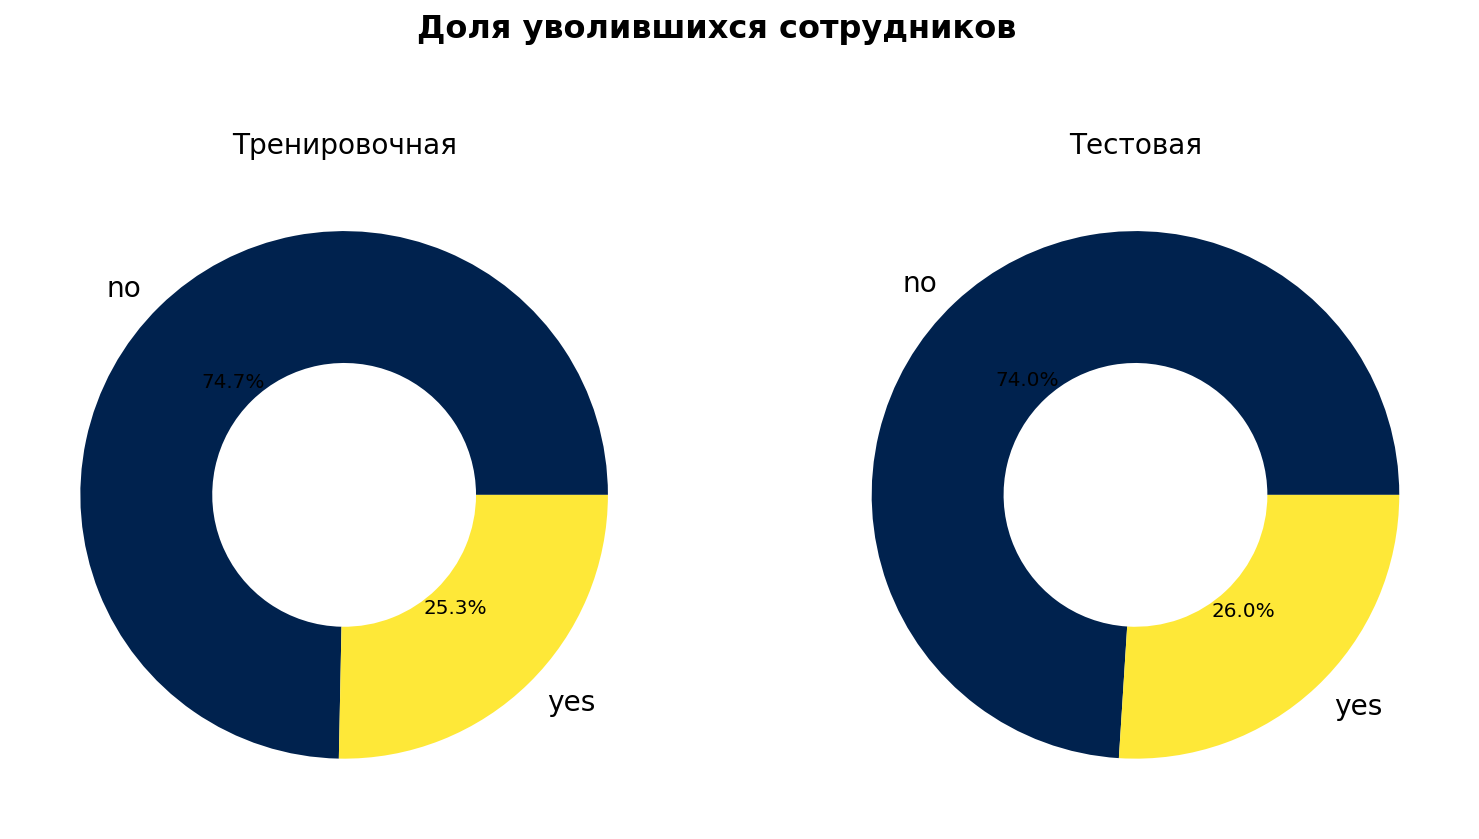

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 7))
plt.suptitle('Доля уволившихся сотрудников')
df_train_quit['quit'] \
    .value_counts() \
        .to_frame() \
            .plot(y='quit', kind='pie', ax=axes[0], autopct='%1.1f%%', legend=False, ylabel='',
                  cmap='cividis', wedgeprops=dict(width=0.5))
axes[0].set_title('Тренировочная')

df_test_quit['quit'] \
    .value_counts() \
        .to_frame() \
            .plot(y='quit', kind='pie', ax=axes[1], autopct='%1.1f%%', legend=False, ylabel='',
                  cmap='cividis', wedgeprops=dict(width=0.5))
axes[1].set_title('Тестовая')
plt.show()

Уволившиеся сотрудники составляют 28.2% от числа всех сотрудников. Данные в обеих выборках разделены пропорционально. Для того, чтобы изучить портрет уволившегося сотрудника, будем анализировать долю уволившихся сотрудников в каждом отделе, среди должностей всех уровней и другим характеристикам. Для начала необходимо заменить значения в целевом признаке "quit" на 1 и 0, где 1 - уволившийся сотрудник (значение "yes"), а 0 - оставшийся ("no").

In [ ]:
# замена в столбце "quit" значения "yes" на 1, "no" на 0  с помощью lambda функции
df_train_quit['quit'] = df_train_quit['quit'].apply(
    lambda x: 1 if x=='yes' else 0)
df_test_quit['quit'] = df_test_quit['quit'].apply(
    lambda x: 1 if x=='yes' else 0)

Изучим портрет уволившегося сотрудника. Для этого проанализируем долю уволившихся сотрудников в зависимости от отдела, уровня занимаемой должности, загруженности на работе, и исходя из того были ли повышения или нарушения тругодой дисциплины за последний год. Для того, чтобы расчитать долю уволившихся в каждой из категорий, необходимо сгруппировать по столбцу с интересующей категорией и рассчитать среднее (mean) для столбца "quit". Т.к. значения в столбце "quit" 1 ("уволился") или 0 ("не уволился"), то среднее как раз и покажет долю уволившихся сотрудников в общем коллективе.

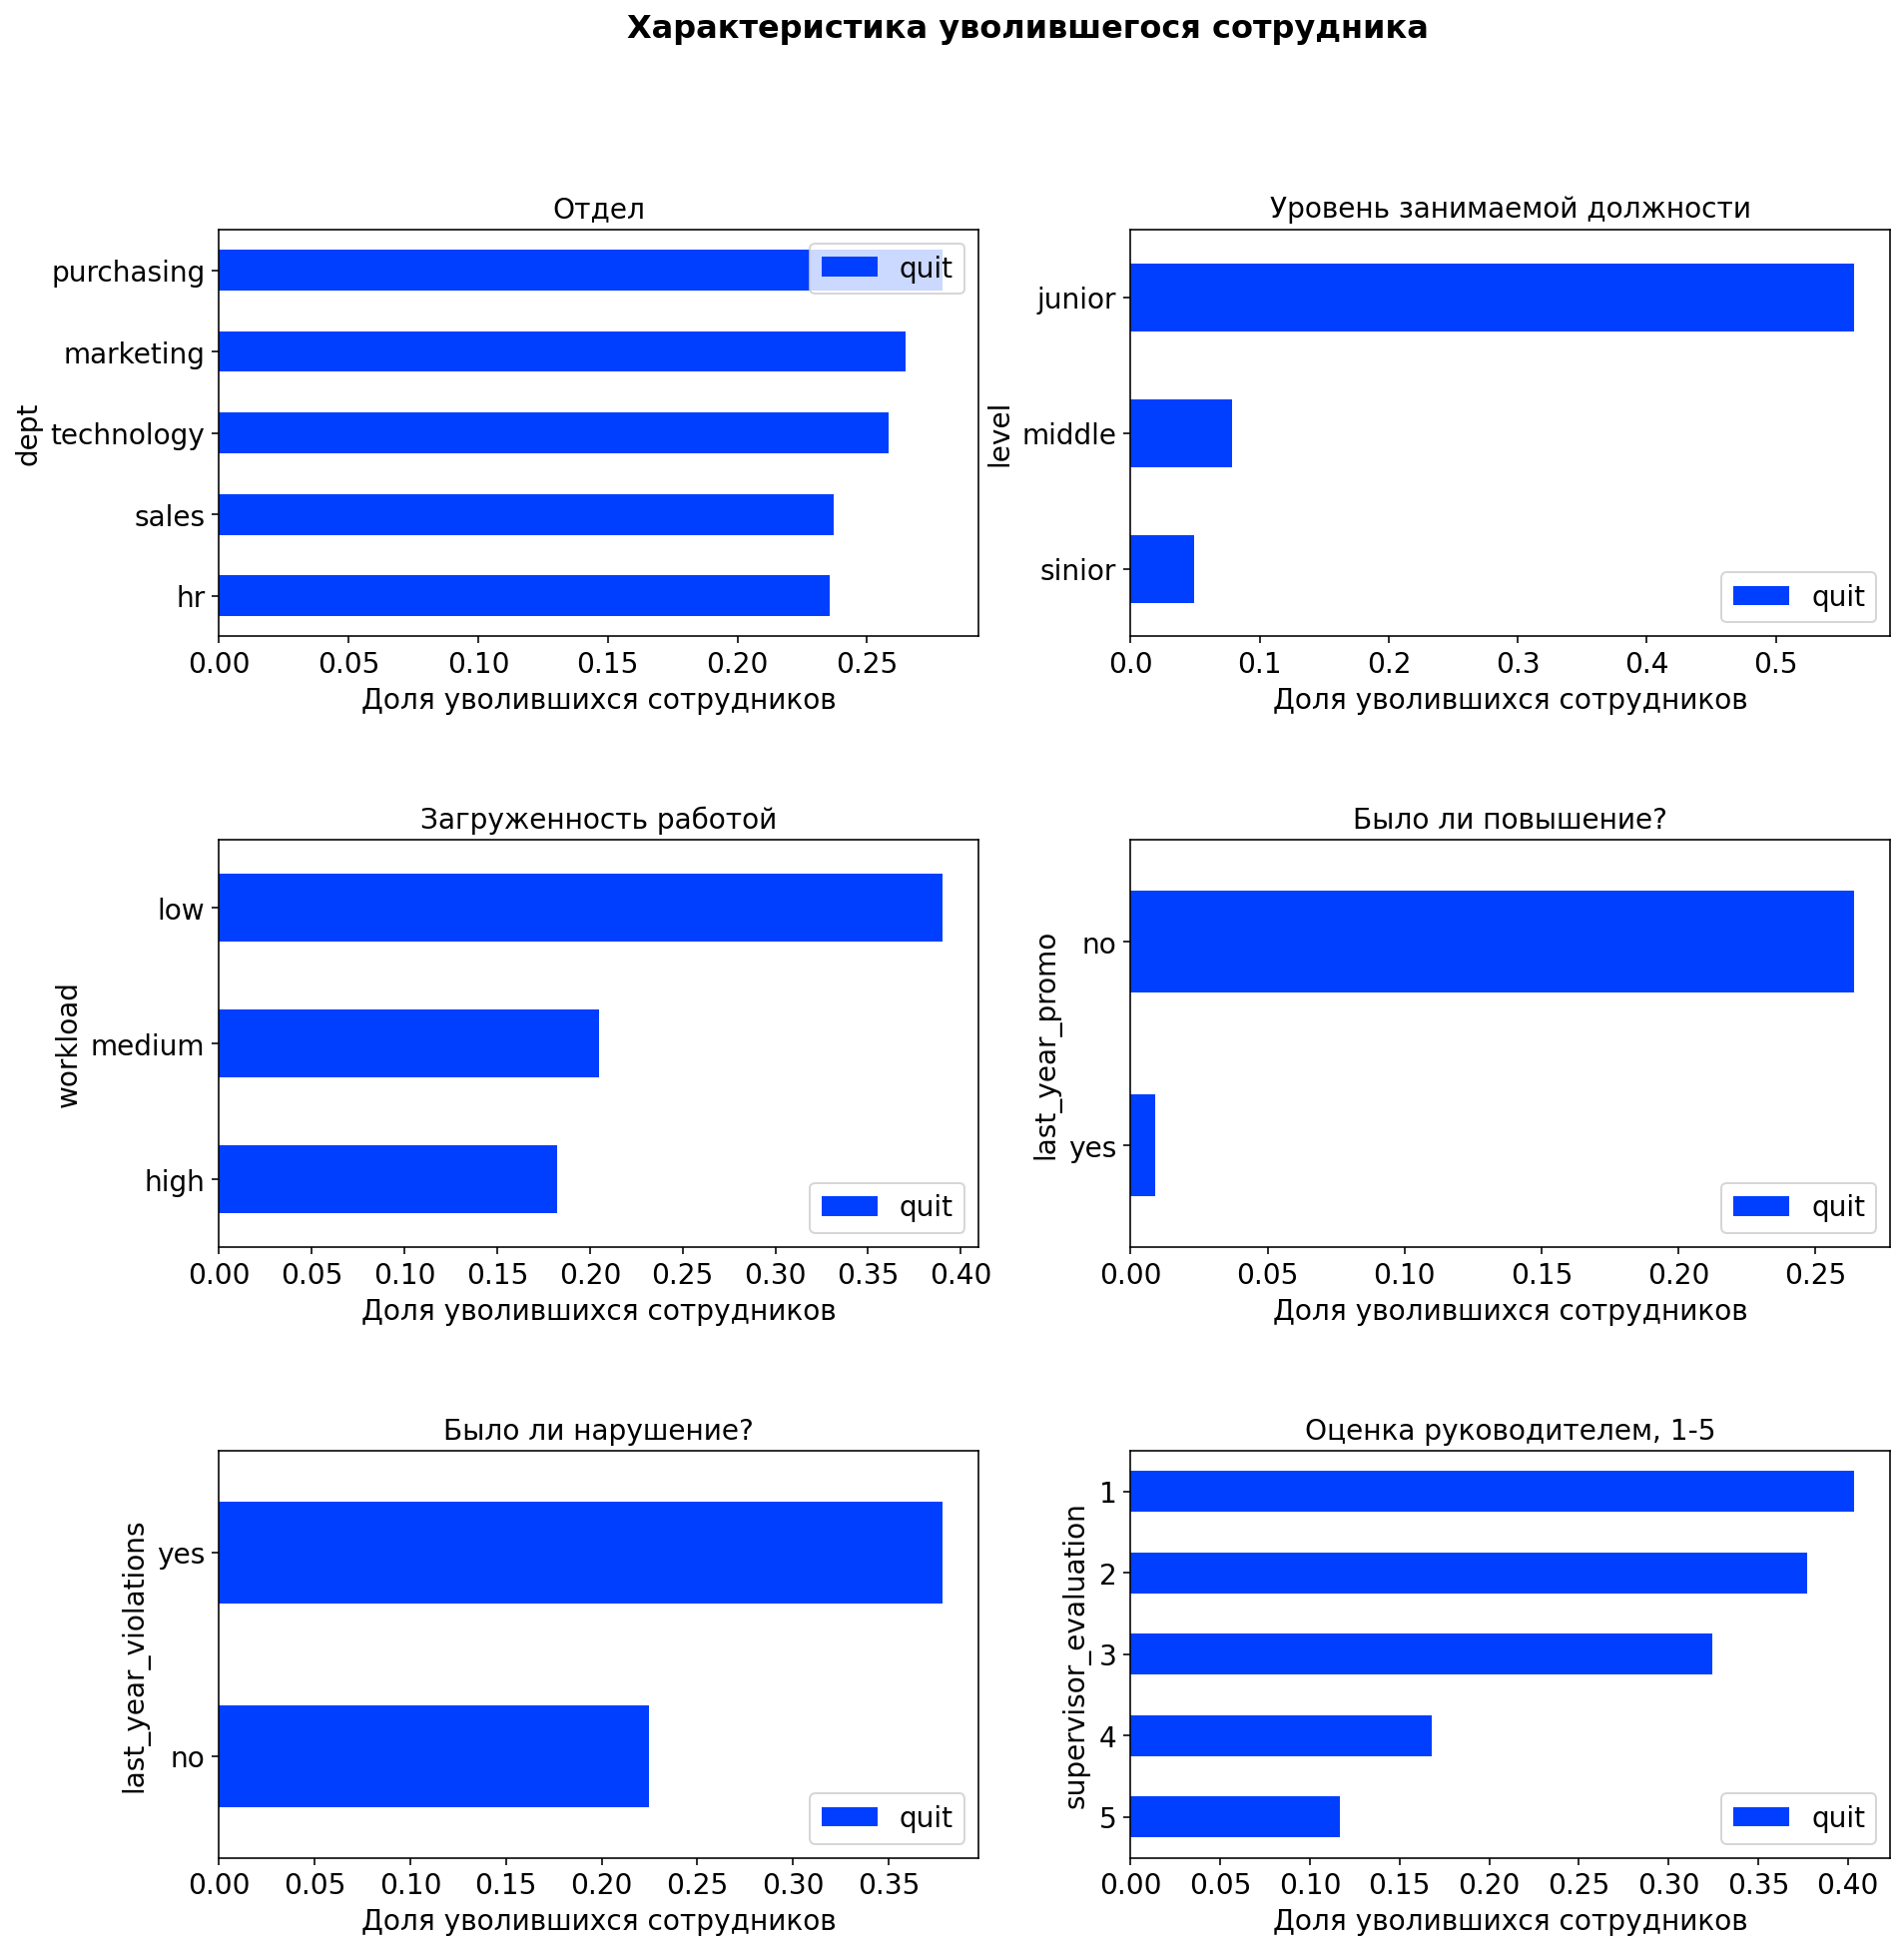

In [ ]:
features = [('dept', 'Отдел'), ('level', 'Уровень занимаемой должности'),
            ('workload', 'Загруженность работой'), ('last_year_promo', 'Было ли повышение?'),
            ('last_year_violations', 'Было ли нарушение?'), ('supervisor_evaluation', 'Оценка руководителем, 1-5')]

plt.figure(figsize=(15, 15))
plt.suptitle('Характеристика уволившегося сотрудника')
plt.subplots_adjust(hspace=0.5)

# цикл для перебора характеристик сотрудника с построением горизонтальной столбчатой диаграммы
for i, feature in enumerate(features):
    ax = plt.subplot(3, 2, i+1)
    ax.grid(True)
    ax.set_title(feature[1])
    ax.set_xlabel('Доля уволившихся сотрудников')
    ax.set_ylabel('')

    (df_train_quit
         .pivot_table(index=feature[0], values='quit', aggfunc='mean')
             .sort_values(by='quit')
                 .plot(kind='barh', ax=ax)
    )

Таким образом, уволившийся сотрудник с наибольшей долей вероятности из отдела Technology. Он на позиции junior. У него низкаязагрузка на работе. У него не было повышения, но было нарушение трудовой дисциплины за последний год. И с большой долей вероятности он получил самую низкую оценку своим руководителем (1).

Посмотрим также в среднем как различаются зарплаты ушедших и оставшихся сотрудников. Для этого построим боксплоты.

In [ ]:
def build_boxplot(feature, feature_name):
    # просмотр описательной статистики по зарплатам для каждого типа сотрудника
    print(df_train_quit.groupby('quit')[feature].describe())

    # построение диаграммы размаха
    df_train_quit.boxplot(column=feature, by='quit', figsize=(15, 7))
    plt.title('Диаграмма размаха в зависимости от признака '+feature_name)
    plt.xlabel('Оставшийся сотрудник (0) vs уволившийся (1)')
    plt.ylabel(feature_name)
    plt.show()

       count          mean           std      min      25%      50%      75%  \
quit                                                                           
0     1932.0  40952.173913  16085.739667  12000.0  27600.0  39000.0  51600.0   
1      655.0  25767.938931  10484.828614  12000.0  18000.0  24000.0  30600.0   

          max  
quit           
0     96000.0  
1     79200.0  


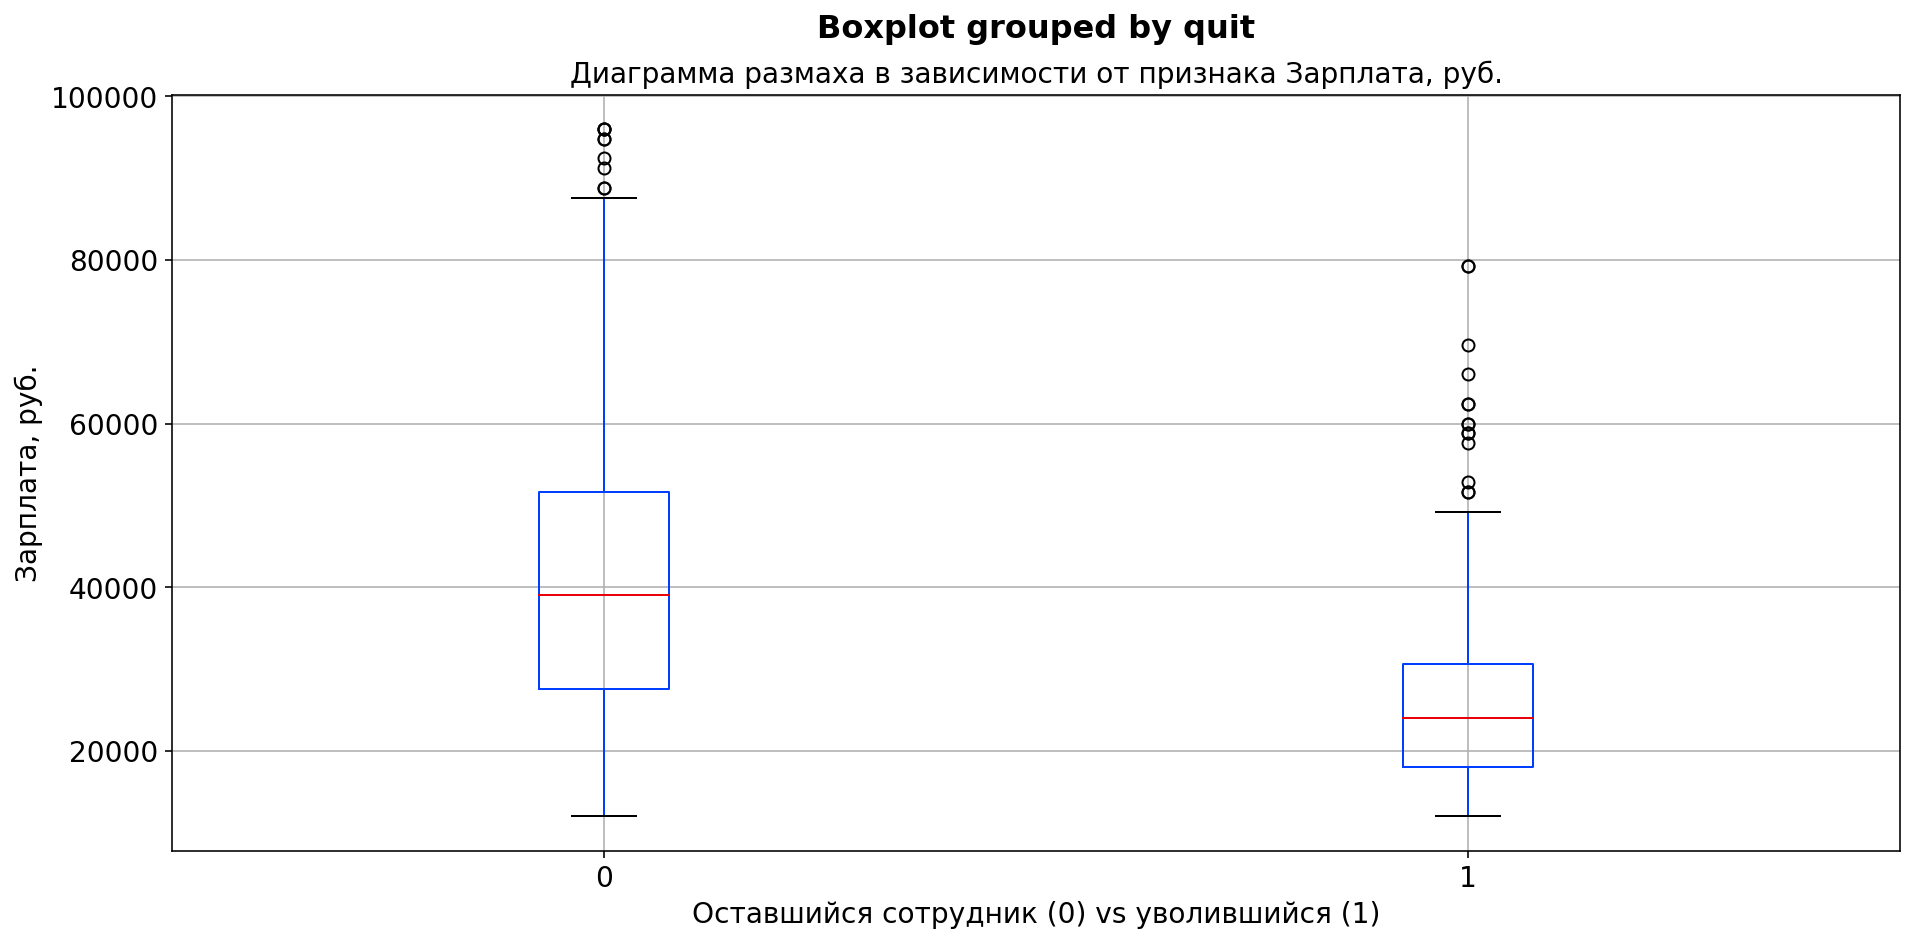

In [ ]:
build_boxplot('salary', 'Зарплата, руб.')

В среднем зарплата у уволившихся сотрудников на 13817 рублей ниже, чем у оставшихся. Присутствуют, однако, и ушедшие сотрудники с высокими зарплатами до 79200 руб/месяц.

       count      mean       std  min  25%  50%  75%   max
quit                                                      
0     1932.0  4.908903  2.527730  1.0  3.0  5.0  7.0  10.0
1      655.0  2.161832  1.497626  1.0  1.0  2.0  3.0  10.0


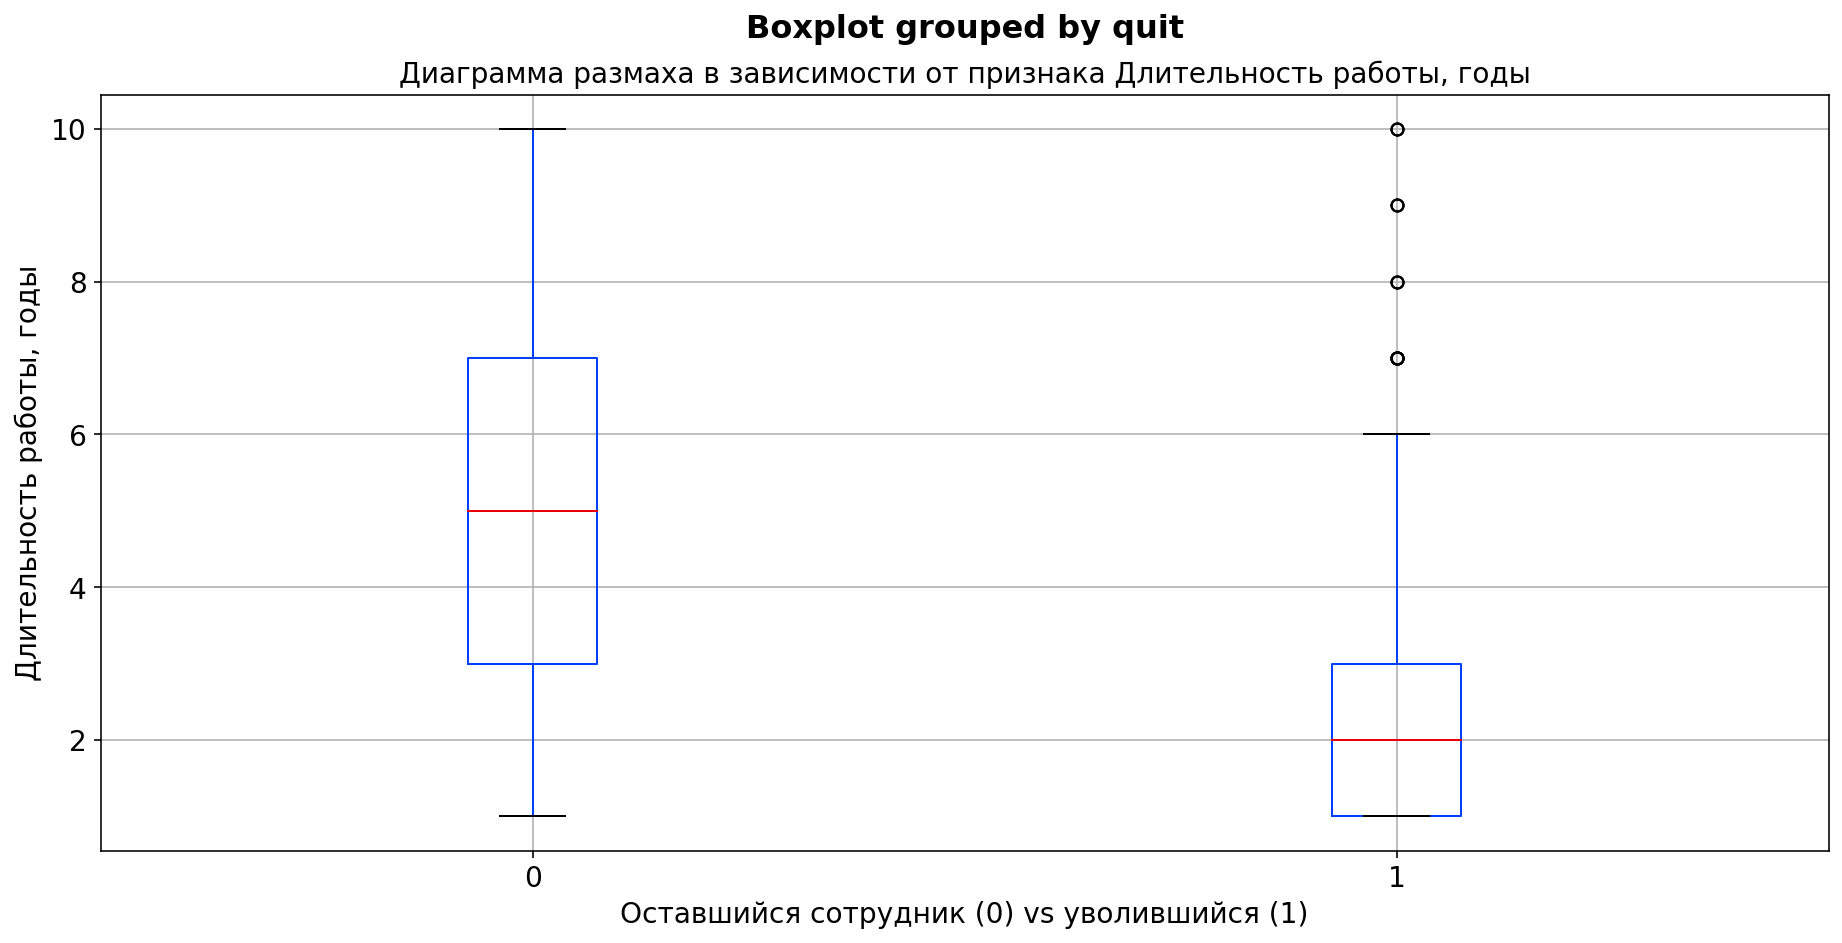

In [ ]:
build_boxplot('employment_years', 'Длительность работы, годы')

Наибольший риск ухода работника в первый год работы. Оставшиеся сотрудники в среднем работают уже более 4 лет.

### Проверка взаимосвязи уровня удовлетворенности работой и тем уволится ли сотрудник

Для начала добавим к тестовой выборке df_test_quit целевой признак из первой задачи. Обединение сделаем методом merge() по id сотрудника.

In [ ]:
df_test_quit = df_test_quit.merge(df_y_test, on='id')
df_test_quit

id        dept   level workload  employment_years last_year_promo  \
0     485046   marketing  junior   medium                 2              no   
1     686555          hr  junior   medium                 1              no   
2     467458       sales  middle      low                 5              no   
3     418655       sales  middle      low                 6              no   
4     789145          hr  middle   medium                 5              no   
...      ...         ...     ...      ...               ...             ...   
1491  609235          hr  sinior     high                 2              no   
1492  630684  technology  junior     high                 2              no   
1493  497976  technology  middle   medium                 3              no   
1494  109582  technology  middle      low                 3              no   
1495  771859  purchasing  middle   medium                 1              no   

     last_year_violations  supervisor_evaluation  salary  quit  \
0                      no                      5   28800     0   
1                      no                      4   30000     0   
2                      no                      4   19200     0   
3                      no                      4   19200     0   
4                      no                      5   40800     0   
...                   ...                    ...     ...   ...   
1491                   no                      3   81600     0   
1492                   no                      4   48000     0   
1493                   no                      4   52800     0   
1494                   no                      2   21600     1   
1495                   no                      4   38400     0   

      job_satisfaction_rate  
0                      0.79  
1                      0.72  
2                      0.64  
3                      0.60  
4                      0.75  
...                     ...  
1491                   0.38  
1492                   0.78  
1493                   0.70  
1494                   0.14  
1495                   0.67  

[1496 rows x 11 columns]

Статистика для уволившегося сотрудника count    389.000000
mean       0.388483
std        0.193311
min        0.040000
25%        0.240000
50%        0.370000
75%        0.490000
max        0.970000
Name: job_satisfaction_rate, dtype: float64


Статистика для оставшегося сотрудника count    1107.000000
mean        0.589268
std         0.208330
min         0.030000
25%         0.440000
50%         0.630000
75%         0.750000
max         1.000000
Name: job_satisfaction_rate, dtype: float64


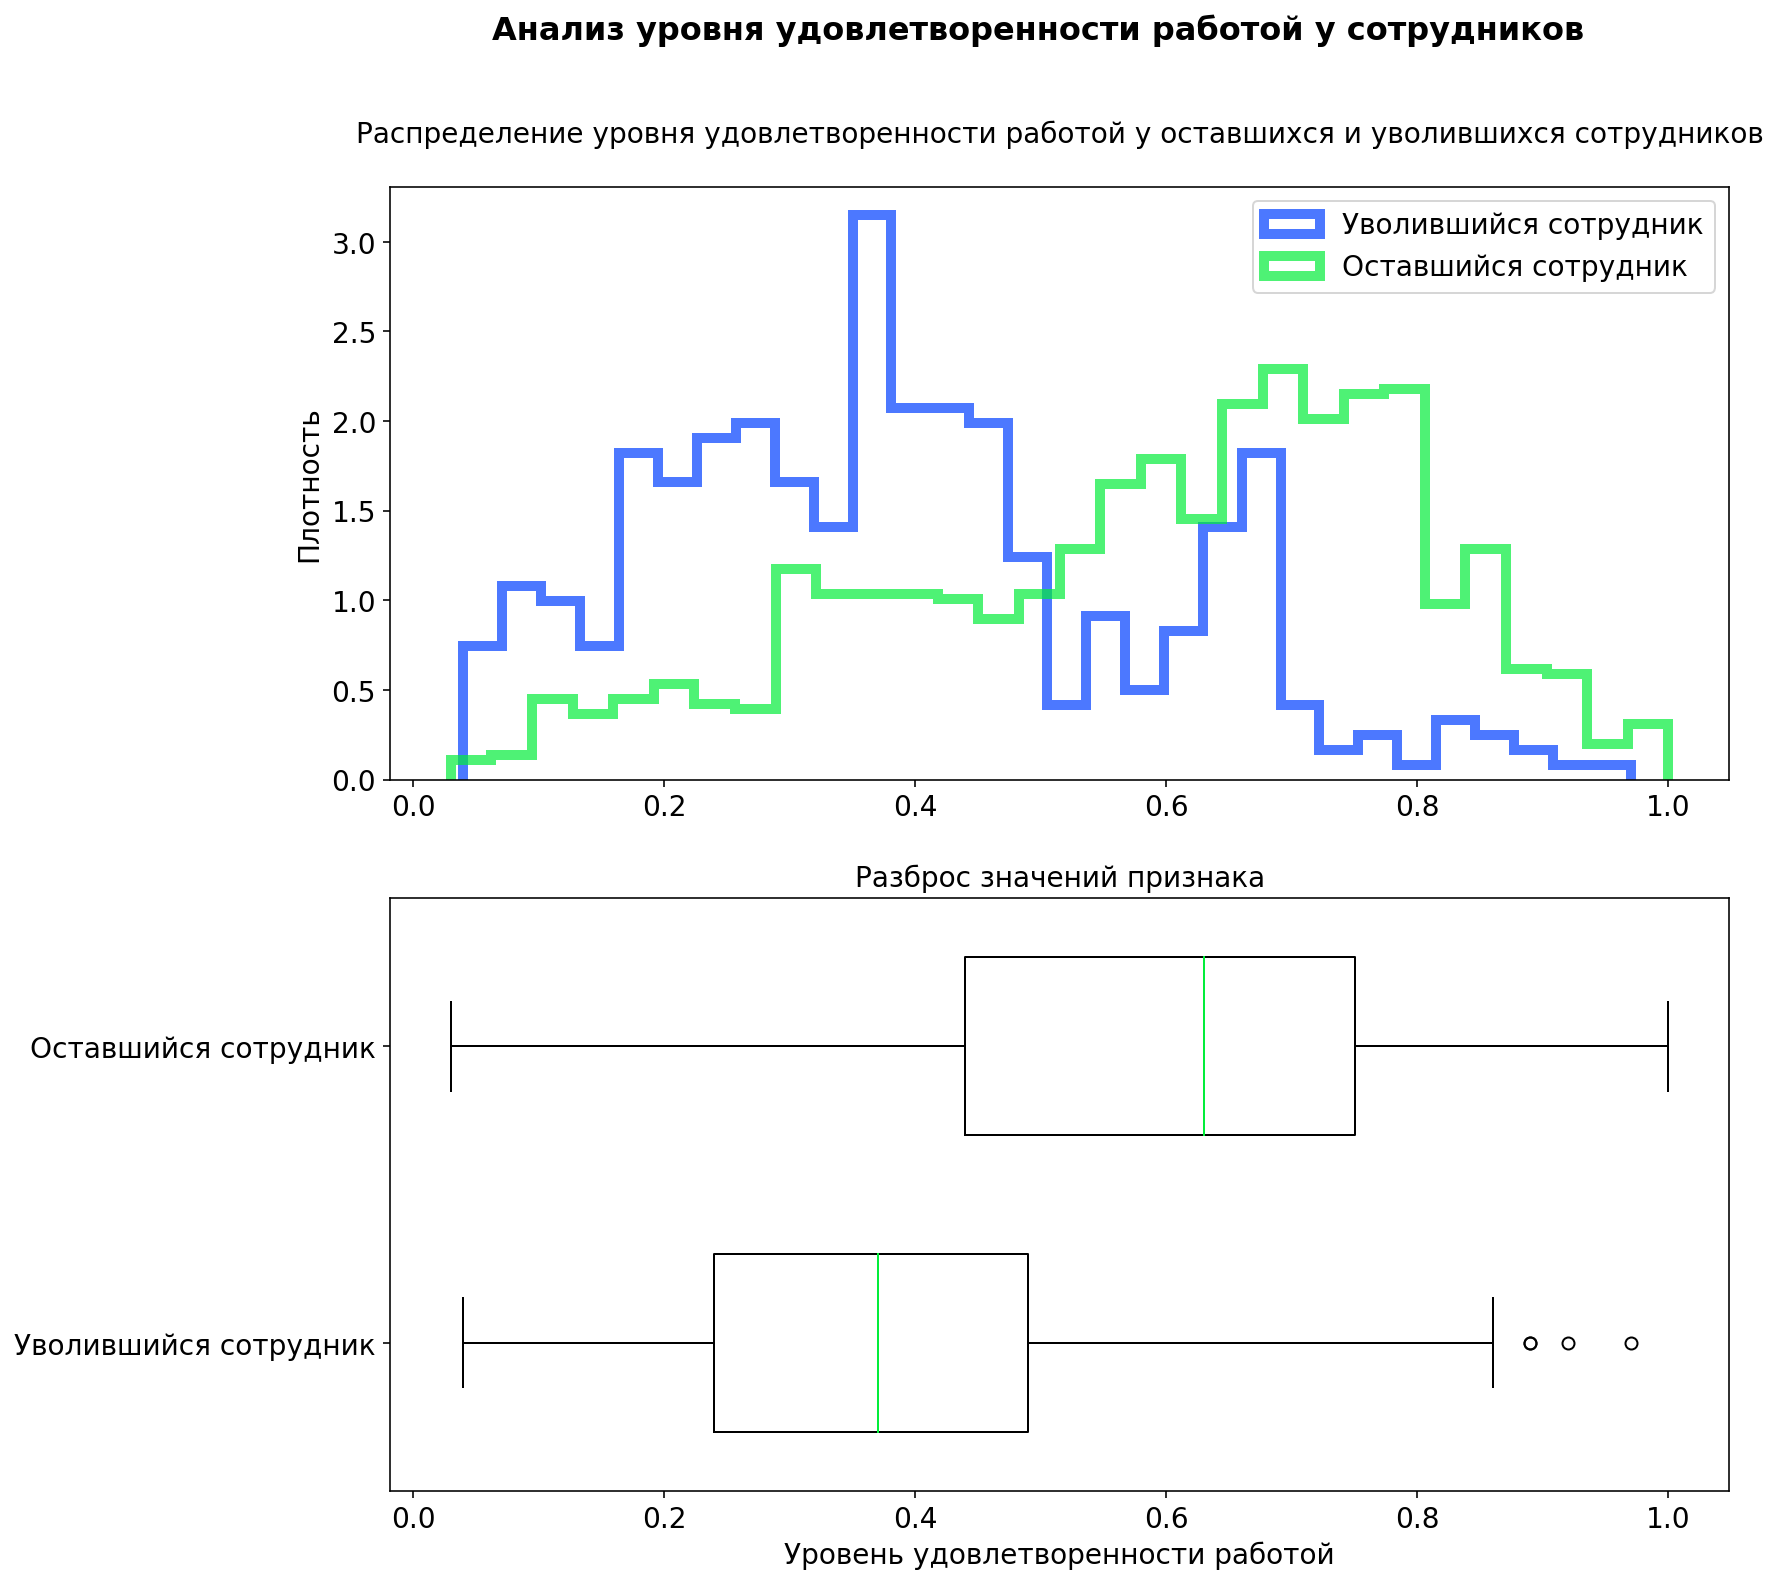

In [ ]:
quit = df_test_quit.query('quit == 1')
stay = df_test_quit.query('quit == 0')

print(f'Статистика для уволившегося сотрудника {quit["job_satisfaction_rate"].describe()}\n\n')
print(f'Статистика для оставшегося сотрудника {stay["job_satisfaction_rate"].describe()}')

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
plt.suptitle('Анализ уровня удовлетворенности работой у сотрудников')

axes[0].hist(quit['job_satisfaction_rate'], histtype='step', bins = 30, linewidth=5, alpha=0.7,
             label='Уволившийся сотрудник', density=True)
axes[0].hist(stay['job_satisfaction_rate'], histtype='step', bins = 30, linewidth=5, alpha=0.7,
             label='Оставшийся сотрудник', density=True)
axes[0].set_title('Распределение уровня удовлетворенности работой у оставшихся и уволившихся сотрудников\n')
axes[0].set_ylabel('Плотность')
axes[0].legend()

axes[1].boxplot(quit['job_satisfaction_rate'], positions=[1], widths=0.6, vert=False)
axes[1].boxplot(stay['job_satisfaction_rate'], positions=[2], widths=0.6, vert=False)
axes[1].set_title('Разброс значений признака')
axes[1].set_yticklabels(['Уволившийся сотрудник', 'Оставшийся сотрудник'])
axes[1].set_xlabel('Уровень удовлетворенности работой')
plt.show()

Анализ полученных графиков подтверждает мнение аналитиков компании: уровень удовлетворенности влияет на то уйдет или останется работник. Медианное значение уровня удовлетворенности работой оставшихся сотрудников почти в 2 раза выше, уволившихся: 0.66 к 0.37 соответственно.
Среди уволившихся тем не менее есть сотрудники с уровнем удовлетворенности выше 0.8. Возможно, им сделали еще более выгодное предложение по работе, от которого они не смогли отказаться. Либо они уволились в связи с личными обстоятельствами.
Среди оставшихся есть сотрудники с крайне низким уровнем удовлетворенности (ниже 0.1). Они находятся в зоне риска ухода из компании.

Проверим гипотезу о том, что **уровень удовлетворенности работой уволившегося сотрудника в среднем не превышает 0.4.**
    
Формулировку "не превышает 0.4" можно перефразировать как меньше или равно 0.4, т.е. имеется ввиду вероятность левого "хвоста". Т.к. в качестве нулевой гипотезы принято брать равенство средних значений, установим нулевую гипотезу (Н0) о том, что уровень удовлетворенности уволившегося сотрудника в среднем равен 0.4. В качестве альтернативной примем правостороннюю гипотезу (Н1) о том, что уровень **больше** этого значения.
Чтобы проверить такую гипотезу, нужно передать в метод **st.ttest_1samp()** сначала выборку с уровнем удовлетворенности уволившегося сотрудника (quit["job_satisfaction_rate"]), затем проверочное значение на равенство или неравенство которому проводится тест. В качестве alternative нужно указать 'greater', то есть "больше".

Установим уровень статистической значимости равным 1%.

In [ ]:
check_level = 0.4

alpha = 0.01 # уровень статистической значимости

results = st.ttest_1samp(
    quit["job_satisfaction_rate"],
    check_level,
      alternative='greater')

print('Средний уровень удовлетворенности работой уволившегося сотрудника равен', quit["job_satisfaction_rate"].mean())
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

Средний уровень удовлетворенности работой уволившегося сотрудника равен 0.3884832904884319
p-значение: 0.879647281838765
Не отвергаем нулевую гипотезу


Нулевая гипотеза не была опровергнута в пользу альтернативной, значит с достаточной степенью уверенности можно утверждать, что в среднем уровень удовлетворенности работой уволившегося сотрудника не более 0.4. Этот критерий также можно использовать для прогноза увольнения сотрудника.

Рассмотрим коэффициенты корреляции между признаками для каждого из двух классов целевой переменной.

In [ ]:
# создаём список с наименованиями непрерывных признаков
interval_cols = ['salary', 'job_satisfaction_rate']

# считаем коэффициенты корреляции
phik_quit= phik_matrix(quit, interval_cols=interval_cols)
phik_stay = phik_matrix(stay, interval_cols=interval_cols)

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable quit for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable id is large: 1107. Are you sure this is not an interval variable? Analysis for pairs of variables including id can be slow.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable quit for analysis 1. Dropping this column
  warnings.warn(


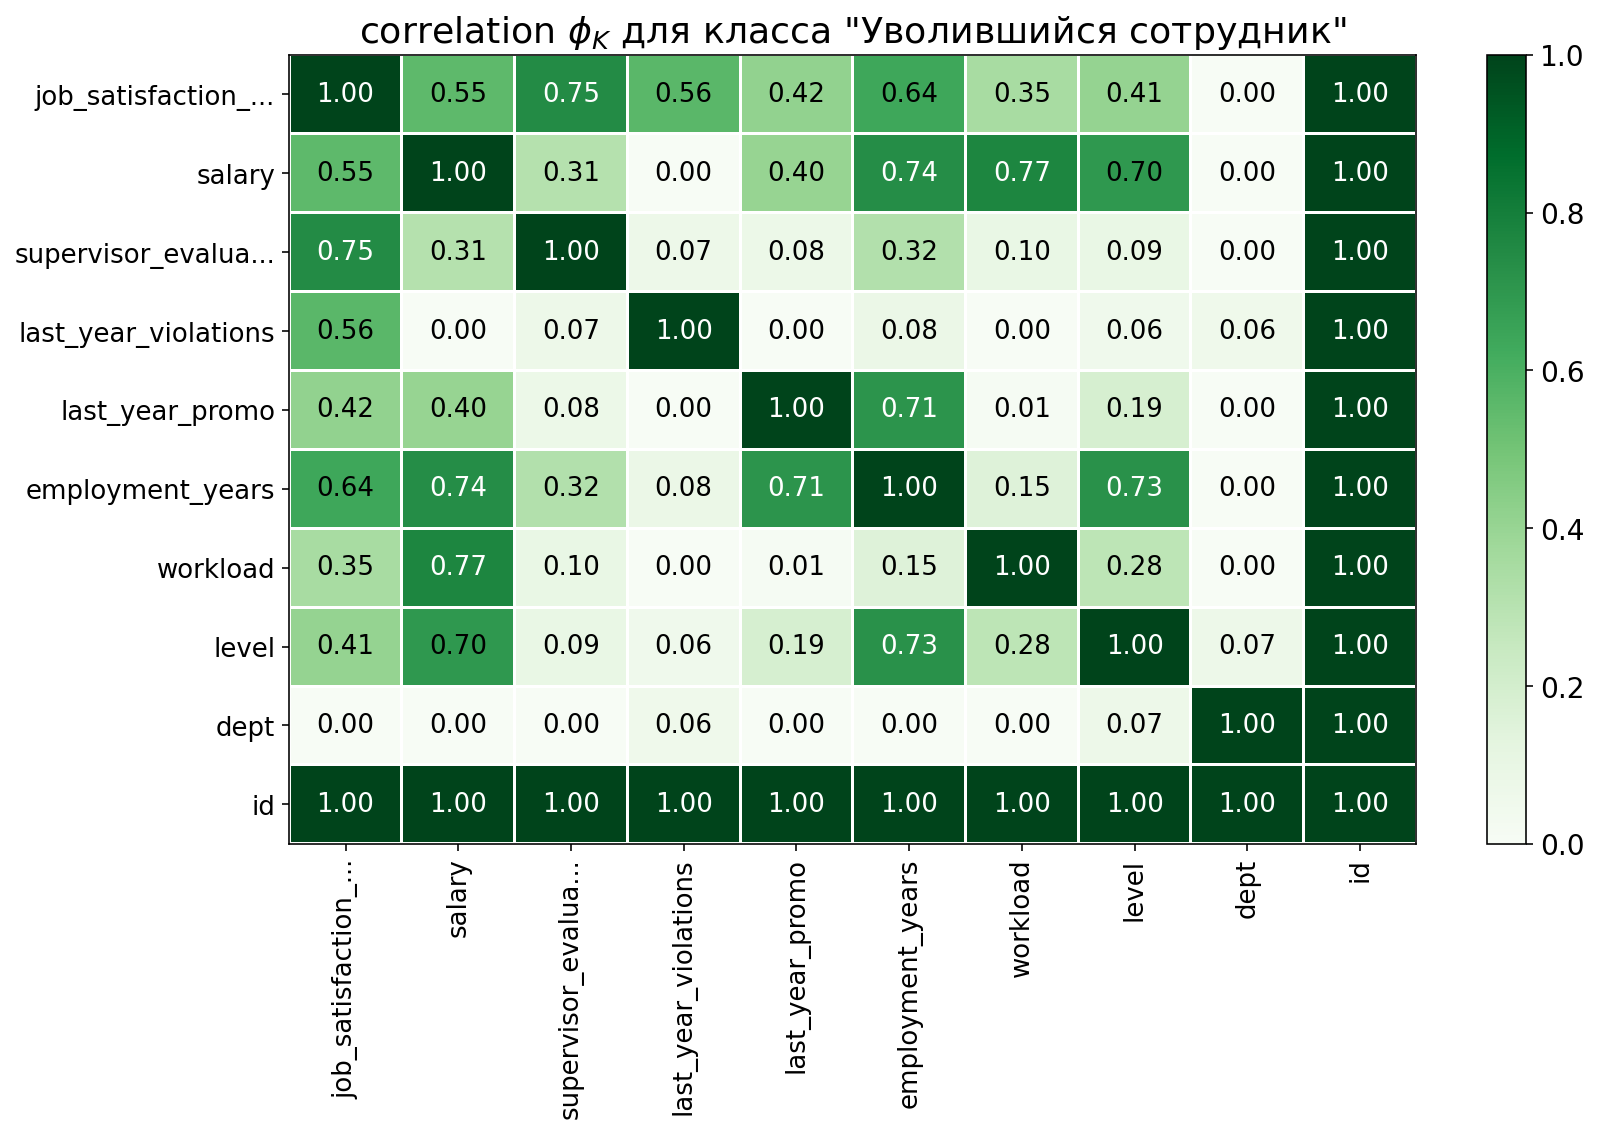

In [ ]:
# строим матрицу корреляции для класса 'Уволившийся сотрудник'
plot_correlation_matrix(
    phik_quit.values,
    x_labels=phik_quit.columns,
    y_labels=phik_quit.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$ для класса "Уволившийся сотрудник"',
    fontsize_factor=1.3,
    figsize=(12, 8)
)
plt.show()

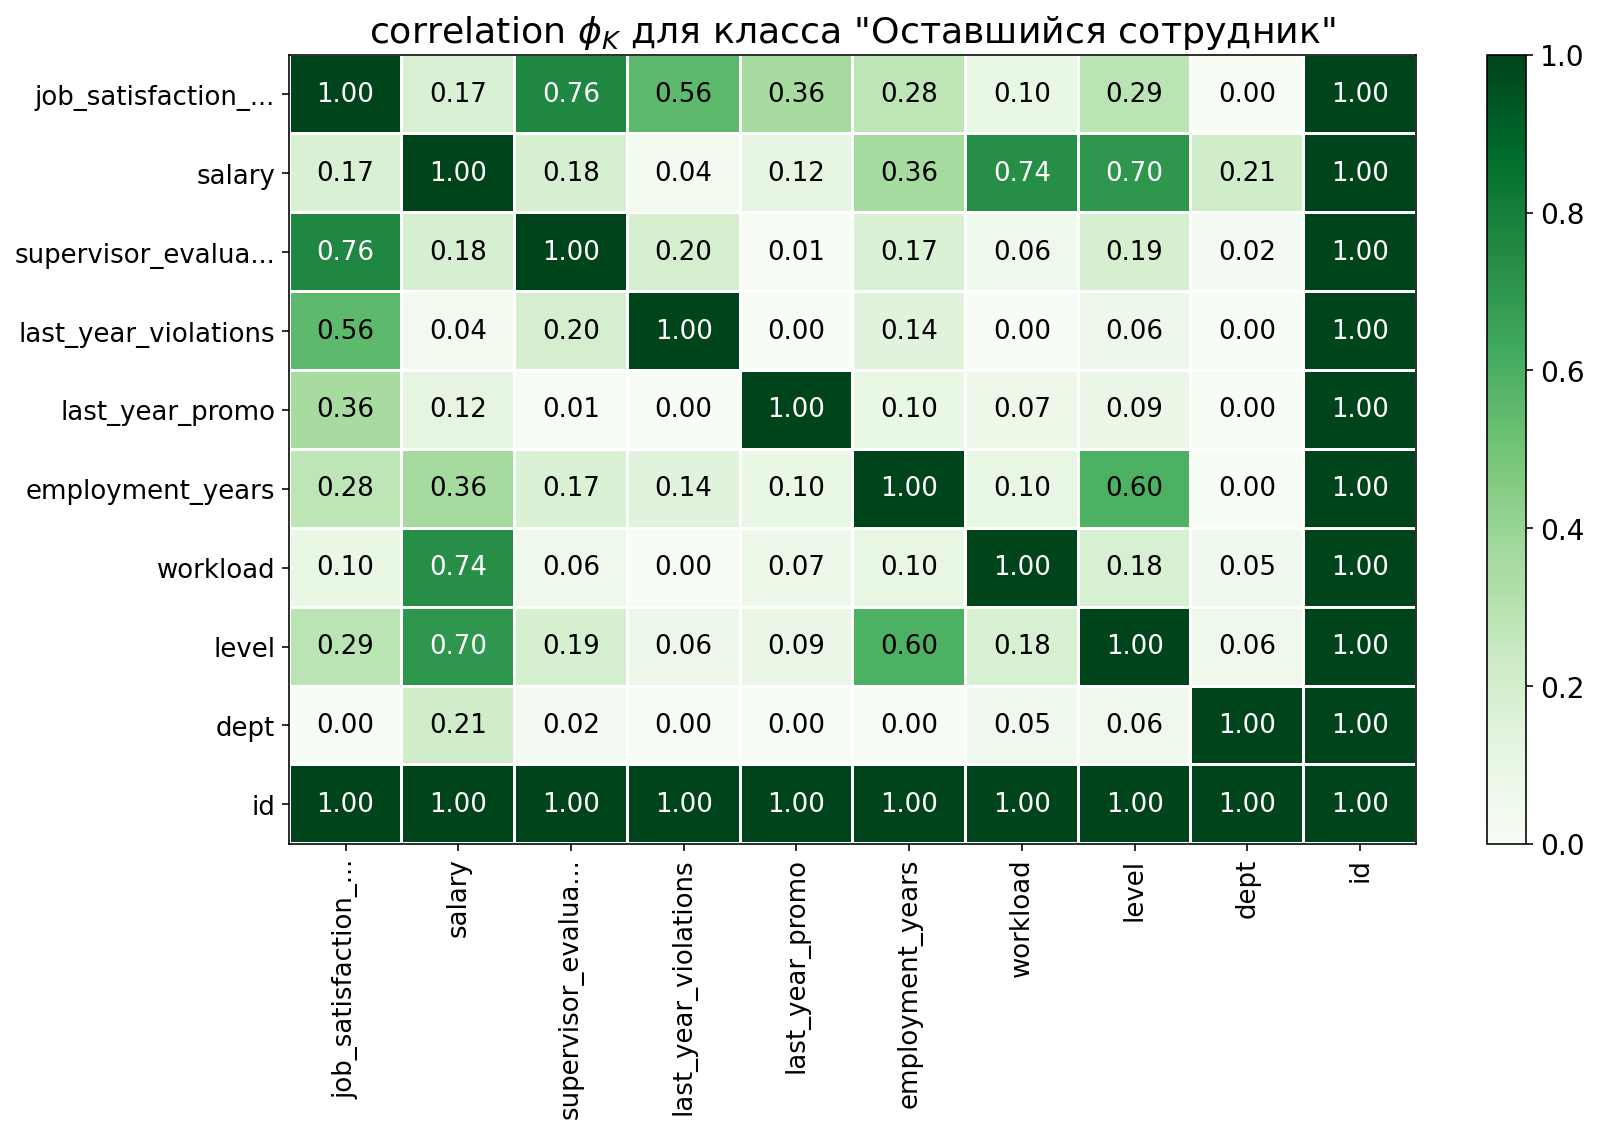

In [ ]:
# строим матрицу корреляции для класса 'Оставшийся сотрудник'
plot_correlation_matrix(
    phik_stay.values,
    x_labels=phik_stay.columns,
    y_labels=phik_stay.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$ для класса "Оставшийся сотрудник"',
    fontsize_factor=1.3,
    figsize=(12, 8)
)
plt.show()

Мультиколлинеарность не наблюдается ни для одного из классов.

В целом для класса "Уволившийся сотрудник" для большего количества ячеек наблюдаются более тёмные цвета, соответственно для этого класса выше связь между признаками, чем для класса "Оставшийся сотрудник". 6 взаимосвязей признаков из класса "Уволившийся сотрудник" характеризуются высокой силой по шкале Чеддока, а именно от 0.7 до 0.79. Наиболее тесная связь наблюдается между загруженностью работой (workload) и величиной зарплаты (salary) - 0.79.

В классе "Оставшийся сотрудник" только 3 пары признаков имеют тесноту связи выше 0.7. Наиболее тесная связь наблюдается между оценкой руководителя (supervisor_evaluation) и уровнем удовлетворенности работы (job_satisfaction_rate) равная 0.77.

Для признака с названием отдела (dept) для обоих классов наблюдается нулевая или очень слабая (0.24) связь с другими признаками. Возможно его стоит удалить из моделирования для повышения качества модели.

### Подготовка данных и моделирование

Подготовку и моделирование сделаем в пайплайне.

In [ ]:
# задание константных значений
RANDOM_STATE = 42

# записываем входные данные в переменные Х_train и X_test, целевой признак в переменные у_train и y_test
X_train = df_train_quit.drop(['quit'], axis=1)
y_train = df_train_quit['quit']
X_test = df_test_quit.drop(['quit', 'job_satisfaction_rate'], axis=1)
y_test = df_test_quit['quit']

# создаём списки с названиями признаков
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']


# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'simple_imputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

# SimpleImputer + Ord + SimpleImputer
ord_pipe = Pipeline(
    [
        (
            'simple_imputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high']
                ],
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simple_imputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели KNeighborsClassifier()
    {
        # название модели
        'models': [KNeighborsClassifier()],
        # указываем гиперпараметр модели n_neighbors
        'models__n_neighbors': range(1, 10),
        # указываем список методов масштабирования
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__min_samples_split': range(2, 11),
        'models__min_samples_leaf': range(1, 11),
        'models__max_depth': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели SVC()
    {
        'models': [SVC(
            random_state=RANDOM_STATE,
            kernel='linear')],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']

    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            penalty='l1',
            solver='saga')],
        'models__C': [0.1, 0.5, 0.6, 0.8, 1, 2, 5, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

# рассчитаем прогноз и метрики на тестовых данных
y_test_pred = randomized_search.predict(X_test)
y_pred = randomized_search.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_pred)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_test, 3)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simple_imputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                           

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Наилучшей моделью оказалась модель DecisionTreeClassifier с параметрами max_depth=6, min_samples_leaf=8, min_samples_split=4 и масштабированием MinMaxScaler(). Ее метрика на тренировочной выборке ROC-AUC=0.902. На тестовой выборке метрика ROC-AUC чуть меньше, равна 0.899.

Посмотрим также на матрицу ошибок.

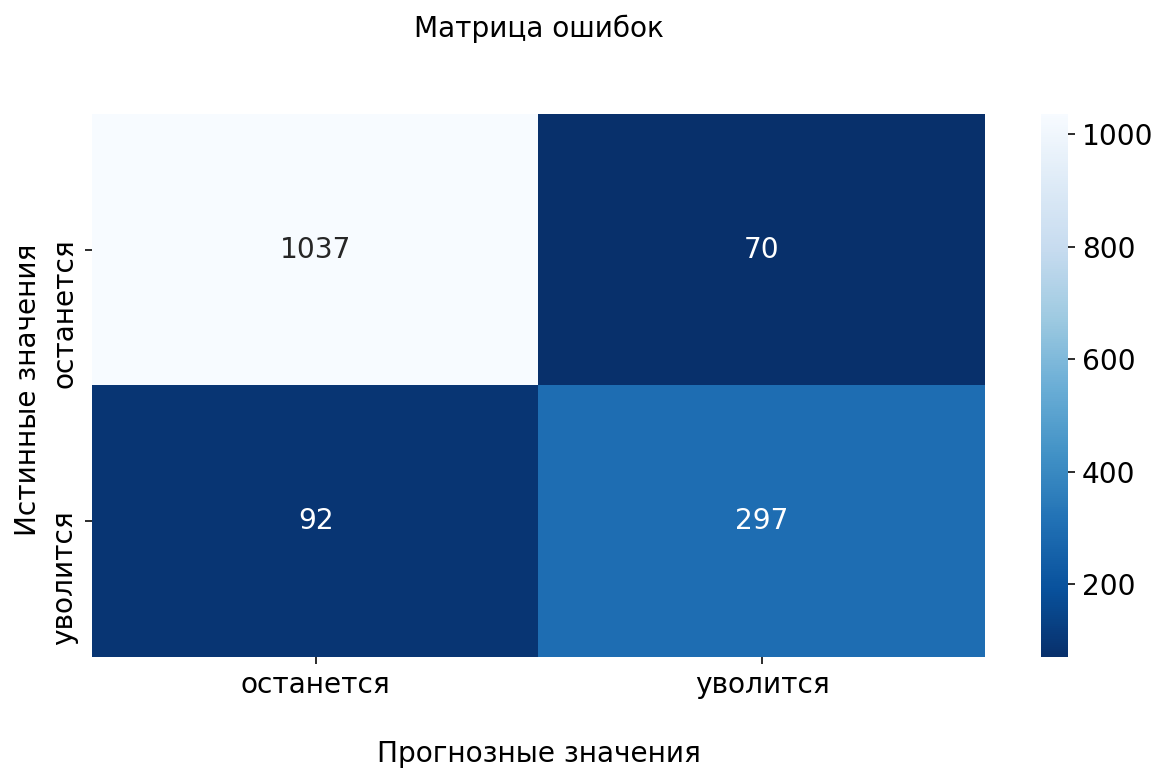

In [ ]:
# расчет матрицы ошибок
cm = confusion_matrix(y_test, y_test_pred)

# визуализация матрицы ошибок с помощью тепловой карты
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.heatmap(cm, annot=True, cmap='Blues_r', annot_kws={"size":14}, fmt=".0f")

ax.set_title('Матрица ошибок\n\n');
ax.set_xlabel('\nПрогнозные значения')
ax.set_ylabel('Истинные значения ')

ax.xaxis.set_ticklabels(['останется', 'уволится'])
ax.yaxis.set_ticklabels(['останется', 'уволится'])


plt.show()

Матрица ошибок показала хороший результат: верно были предсказаны 1802 (TP+TN), а неверно 198
(FP+FN). Для 112 случаев модель выдала ложноотрицательный результат, а для 86 - ложноположительный.

## Общий вывод

В ходе данного проекта были изучены данные по сотрудникам компании. Было построено 2 модели, которые наилучшим образом помогут решить 2 задачи:
1. Предсказать уровень удовлетворённости сотрудника.
2. Предсказать то, что сотрудник уволится из компании.

В компании всего 6000 сотрудников. 4000 из них попали в тренировочную выборку, 2000 - в тестовую. Пересечений в выборках нет.

Перед проведением анализа и моделирования была сделана <u>предобработка данных</u>, в ходе которой были выявлены следующие моменты и проведены следующие действия:
- Пропуски есть в обоих датафреймах df_train и df_test. Они были обработаны в пайплане.
- Типы данных распознаны при загрузке верно и их не надо преобразовывать.
- Названия столбцов менять не надо.
- Явные дубликаты обнаружены в обоих датафреймах. Они были удалены.
- Неявных дубликатов нет.
- Есть пробелы в 2 столбцах тестовой выборки. Это было учтено в пайплайне.

На этапе <u>исследовательского анализа данных</u> было изучено:
- распределение и описательные статистики всех количественных признаков.
- построены круговые диаграммы для всех категориальных признаков для понимания распределения различных классов данных в датасете

Был составлен **портрет уволившегося сотрудника:**
С наибольшей долей вероятности из отдела Technology. Он на позиции junior. У него низкая загрузка на работе. У него не было повышения, но было нарушение трудовой дисциплины за последний год. И с большой долей вероятности он получил самую низкую оценку своим руководителем (1). В среднем зарплата у уволившихся сотрудников на 13817 рублей ниже, чем у оставшихся. А также наибольший риск уйти с работы у работников, работающих в компании 1 год.

Была проверена гипотеза о том, что **уровень удовлетворенности работой уволившегося сотрудника в среднем не превышает 0.4.** Эта гипотеза подтвердилась, значит с достаточной степенью уверенности можно утверждать, что в среднем уровень удовлетворенности работой уволившегося сотрудника не более 0.4. Этот критерий также можно использовать для прогноза увольнения сотрудника.

В ходе <u>корреляционного анализа данных</u> были расчитаны матрицы корреляции коэффициента Фи. Было выявлено, что мультиколлинеарность не наблюдается. Наибольший корреляция целевого признака 'job_satisfaction_rate' с оценкой руководителя 'supervisor_evaluation' равная 0.76.

Для первой задачи при помощи пайплайнов было протестировано 2 модели: DecisionTreeRegressor и LinearRegression. Наилучшей оказалась модель **DecisionTreeRegressor с параметрами max_depth=13, min_samples_leaf=7, min_samples_split=10 и стандартизацией MinMaxScaler().** Ее метрика SMAPE на тренировочной выборке равна 15.07, на тестовой 14.2.

Для второй задачи были протестированы 4 модели: KNeighborsClassifier(), DecisionTreeClassifier(), SVC(), LogisticRegression() с различными гиперпараметрами. Лучшей оказалась модель **DecisionTreeClassifier с параметрами max_depth=6, min_samples_leaf=8, min_samples_split=4 и масштабированием MinMaxScaler().** Ее метрика ROC-AUC на тренировочной выборке оказалась равной 0.902, на тестовой - 0.899.


**Рекомендации:**
- Для повышения уровня удовлетворенности работой рекомендуется избегать слишком критичной оценки руководителем, чтобы не демотивировать работника.
- Для снижения риска увольнения сотрудника, исходя из портрета уволившегося сотрудника можно рекомендовать специальные поддерживающие программы для молодых сотрудников уровня junior, а также для новых сотрудников в первый год работы. Необходимо следить за их загруженностью работой. А также стараться избегать оценки "1" для таких сотрудников.
- Продолжать периодически проводить анкетирование сотрудников для отслеживания иих уровня удовлетворенности и своевременного выявления потенциально желающих уволиться.